In [1]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
from simhelper import helper_plt as hplt
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

# Plot settings
reload(hplt)
hplt.plt_config() # Default plotting styles
%config InlineBackend.figure_format='retina'
save_fig = hplt.Save_fig(fig_prefix="plots/", exts="pdf,jpg",dpi=200,SAVE=True)

Welcome to JupyROOT 6.28/10


In [2]:
llp_file_dict = {0: 'deweighted_LLP_0.0774597.txt',
 1: 'deweighted_LLP_0.274545.txt',
 2: 'deweighted_LLP_0.678553.txt',
 3: 'deweighted_LLP_0.878742.txt',
 4: 'deweighted_LLP_1.9.txt',
 5: 'deweighted_LLP_3.47544.txt',
 6: 'deweighted_LLP_3.74996.txt',
 7: 'deweighted_LLP_4.7.txt',
 8: 'deweighted_LLP_RHN_Umu_0.1.txt',
 9: 'deweighted_LLP_RHN_Umu_0.273842.txt',
 10: 'deweighted_LLP_RHN_Umu_0.649382.txt',
 11: 'deweighted_LLP_RHN_Umu_0.865964.txt',
 12: 'deweighted_LLP_RHN_Umu_1.90365.txt',
 13: 'deweighted_LLP_RHN_Umu_3.08517.txt',
 14: 'deweighted_LLP_RHN_Umu_3.85.txt',
 15: 'deweighted_LLP_RHN_Umu_4.8028.txt'}

In [33]:
efficiency=0.95
data_dir="/home/tomren/geant_projects/musim_test/"

# filenames = {\
#     "bkg p": f"{data_dir}/cedar/cosmic/cosmic_p/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg n": f"{data_dir}/cedar/cosmic/cosmic_n/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg mu": f"{data_dir}/cedar/muon/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg v": f"{data_dir}/cedar/neutrino/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "sig 0.08": f"{data_dir}/llp_sms/rrq/rrq_sig_1_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 0.88": f"{data_dir}/llp_sms/rrq/rrq_sig_3_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 1.90": f"{data_dir}/llp_sms/rrq/rrq_sig_4_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 3.48": f"{data_dir}/llp_sms/rrq/rrq_sig_5_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 4.70": f"{data_dir}/llp_sms/rrq/rrq_sig_7_cosmic_eff{efficiency:.2f}.joblib",\
# }

filenames = {\
    "bkg p":  f"{data_dir}/llp_sms/rrq/rrq_bkg_p_eff{efficiency:.2f}.joblib",\
    "bkg n":  f"{data_dir}/llp_sms/rrq/rrq_bkg_n_eff{efficiency:.2f}.joblib",\
    "bkg mu": f"{data_dir}/llp_sms/rrq/rrq_bkg_mv_eff{efficiency:.2f}.joblib",\
    "bkg v":  f"{data_dir}/llp_sms/rrq/rrq_bkg_v_eff{efficiency:.2f}.joblib",\
    "sig 0.08": f"{data_dir}/llp_sms/rrq/rrq_sig_1_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 0.88": f"{data_dir}/llp_sms/rrq/rrq_sig_3_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 1.90": f"{data_dir}/llp_sms/rrq/rrq_sig_4_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 3.48": f"{data_dir}/llp_sms/rrq/rrq_sig_5_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 4.70": f"{data_dir}/llp_sms/rrq/rrq_sig_7_cosmic_eff{efficiency:.2f}.joblib",\
}

In [34]:
## Load raw data
raw = {item: joblib.load(filenames[item]) for item in filenames}

In [35]:
## Convert raw data to an object that manages cuts
data = {item: cut_functions.RQ_dict(raw[item]) for item in filenames}

# Add cuts

In [36]:
def c_fid(res):
    pillar_locations = [[i*10700,j*10700] for i in range(-2,2) for j in range(-2,3)]
    pillar_locations_right = [[i*10700,j*10700] for i in [2] for j in range(-2,3)]
    cut_range = 1000
    cut_range_right = 1200
    mask = np.ones_like(res["vertex_ndigi"], dtype=bool)
    for x,y in pillar_locations:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range))

    for x,y in pillar_locations_right:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range_right) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range_right))    
    return mask

lim_vertex_track_dist = 1
c_vertex_track_dist = lambda res: res["vertex_track_dist"]/1e3/res["vertex_ntracks"] < lim_vertex_track_dist

lim_track_veto_dist = 15
c_track_veto_dist = lambda res: res["vertex_track_to_veto_dist"]/1000 > lim_track_veto_dist

lim_n_veto_hits = 3
c_nveto = lambda res: res["vertex_ndigi_veto_after"] <=lim_n_veto_hits 


f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)
c_ndown = lambda res: (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])< f_ndown_cut(res["event_ntracks"])

def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y
c_nhits = lambda res: (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut(res["vertex_ndigi_active_after_comp"])


def f_nhits_cut2(x):
    x0 = 9.5
    squeeze = 1.5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
c_nhits2 = lambda res: (res["event_nhits"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut2(res["event_track_nhits"])

c_track_before = lambda res: res["vertex_ndigi_before_limited"] <= 0

cut_angel_v1 = 0.3
cut_angel_v2 = 0.35
# c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        # (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))
c_angle_hv = lambda res:  \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))


cut_open_angle = [0.15,0.5]
c_open_angle = lambda res: (res["vertex_open_angle"] > cut_open_angle[0]) & (res["vertex_open_angle"] < cut_open_angle[1])

for i, res in data.items():
    # More than 2 tracks:
    ## A cut called "More than 2 tracks" is automatically added already.
    
    # More than 3 tracks
    res.add_cut(lambda res: res["vertex_ntracks"]>3, "More than 3 tracks")   

    # Fiducial volume
    res.add_cut(c_fid, "Fiducial volume")

    # Avg distance between tracks and vertex
    res.add_cut(c_vertex_track_dist, "Track-vertex distance")
    
    # min distance between tracks and veto hits
    res.add_cut(c_track_veto_dist, "Track-veto distance")

    # N veto hits
    res.add_cut(c_nveto, "N_veto")    

    # Number of veto hits versus consistent hits
    res.add_cut(c_nhits, "N_hits vs N_veto")

    # Number of veto hits versus consistent hits version 2
    res.add_cut(c_nhits2, "N_hits vs N_veto 2")
    
    # Numeber of downward track
    res.add_cut(c_ndown, "N track downward")

    # Speed of slowest track
    res.add_cut(lambda res: (res["vertex_slowest_track"]> 250) & (res["vertex_slowest_track"]<320), "Track velocity")
    
    # Number of hits before the vertex
    res.add_cut(c_track_before, "N digi before")

    # Align with CMS
    res.add_cut(c_angle_hv, "Angle to CMS")

    # Open angle
    res.add_cut(c_open_angle, "Open angle")


In [37]:
## Show all cuts added
## You don't need to use all of them
data["bkg n"].list_cut()

Cut 0 : More than 2 tracks  , npassed   3423, passage fraction 0.0156367
Cut 1 : True                , npassed 218908, passage fraction 1.0000000
Cut 2 : More than 3 tracks  , npassed    216, passage fraction 0.0009867
Cut 3 : Fiducial volume     , npassed 200440, passage fraction 0.9156358
Cut 4 : Track-vertex distance, npassed 169968, passage fraction 0.7764358
Cut 5 : Track-veto distance , npassed  52357, passage fraction 0.2391735
Cut 6 : N_veto              , npassed 156209, passage fraction 0.7135829
Cut 7 : N_hits vs N_veto    , npassed 110216, passage fraction 0.5034809
Cut 8 : N_hits vs N_veto 2  , npassed  63399, passage fraction 0.2896148
Cut 9 : N track downward    , npassed 154691, passage fraction 0.7066485
Cut 10: Track velocity      , npassed 152006, passage fraction 0.6943830
Cut 11: N digi before       , npassed  69847, passage fraction 0.3190701
Cut 12: Angle to CMS        , npassed   4362, passage fraction 0.0199262
Cut 13: Open angle          , npassed  76899, pass

# Show cutflow with "more than 2 tracks" cut

In [38]:
cut_info_a = {}
cut_info_b = {}

cols = []
for name, res in data.items():
    cut_fiducial = []
    cuts_indirect = [3,4,5,6,9,10,11,12,13]
    cuts_direct = [7,8]
    
    res.cuts_active = cut_fiducial + cuts_indirect + cuts_direct
    info_a = res.print_active(show=False)

    res.cuts_active = cut_fiducial + cuts_direct + cuts_indirect
    info_b = res.print_active(show=False)

    cut_functions.append_info_dict(cut_info_a, info_a)
    cut_functions.append_info_dict(cut_info_b, info_b)
    cols.append(name)

In [40]:
info_a = cut_functions.print_info_dict(cut_info_a, cols)
info_b = cut_functions.print_info_dict(cut_info_b, cols)
with open("info_a_2track_sms.csv", "w+") as f:
    f.write(info_a)
with open("info_b_2track_sms.csv", "w+") as f:
    f.write(info_b)    

# abcd_p = cut_info_a["Angle to CMS"][0]*cut_info_b["N_hits vs N_veto 2"][0]/cut_info_a["Total"][0] * 32
# abcd_n = cut_info_a["Angle to CMS"][1]*cut_info_b["N_hits vs N_veto 2"][1]/cut_info_a["Total"][1] * 27
# print("Extrapolated 5-year background for proton:", abcd_p)
# print("Extrapolated 5-year background for neutron:", abcd_n)

                         bkg p     bkg n    bkg mu     bkg v  sig 0.08  sig 0.88  sig 1.90  sig 3.48  sig 4.70
Total                   638739    218908     23689        24      2854      1252      1798      3045      3681
Fiducial volume         566577    200440     23056        22      2835      1225      1756      2976      3600
Track-vertex distance    400860    155000     20589        16      2611      1046      1447      2401      2808
Track-veto distance      43554     38882         9         4      2570      1008      1336      1958      2131
N_veto                   26880     34146         8         4      2558       986      1292      1786      1898
N track downward         13603     26394         5         4      2443       907      1127      1487      1560
Track velocity           10567     20791         3         3      2238       806      1016      1331      1409
N digi before             5911     16799         1         0      2198       790       990      1304      1380


---

Looking into individual cuts

In [8]:
NTRACK = 1

In [9]:
pltconfig = namedtuple("pltconfig", ["color","label","marker","markersize", "histtype", "alpha_marker"])

plot_settings = {\
    "sig 0.88": pltconfig("C0", "SG 0.9","s", 6, "step", 0.5),\
    "sig 1.90": pltconfig("C2", "SG 1.9","s", 6, "step", 0.5),\
    "sig 3.48": pltconfig("C8", "SG 3.5","s", 6, "step", 0.5),\
    "bkg p":  pltconfig("C1", "BG p", "p", 4, "bar", 0.2),\
    "bkg n":  pltconfig("C3", "BG n", "p", 4, "bar", 0.2),\
    "bkg mu": pltconfig("C4", "BG mu","^", 4, "bar", 0.2),\
    "bkg v":  pltconfig("C5", "BG v", "v", 4, "bar", 0.2),\
}

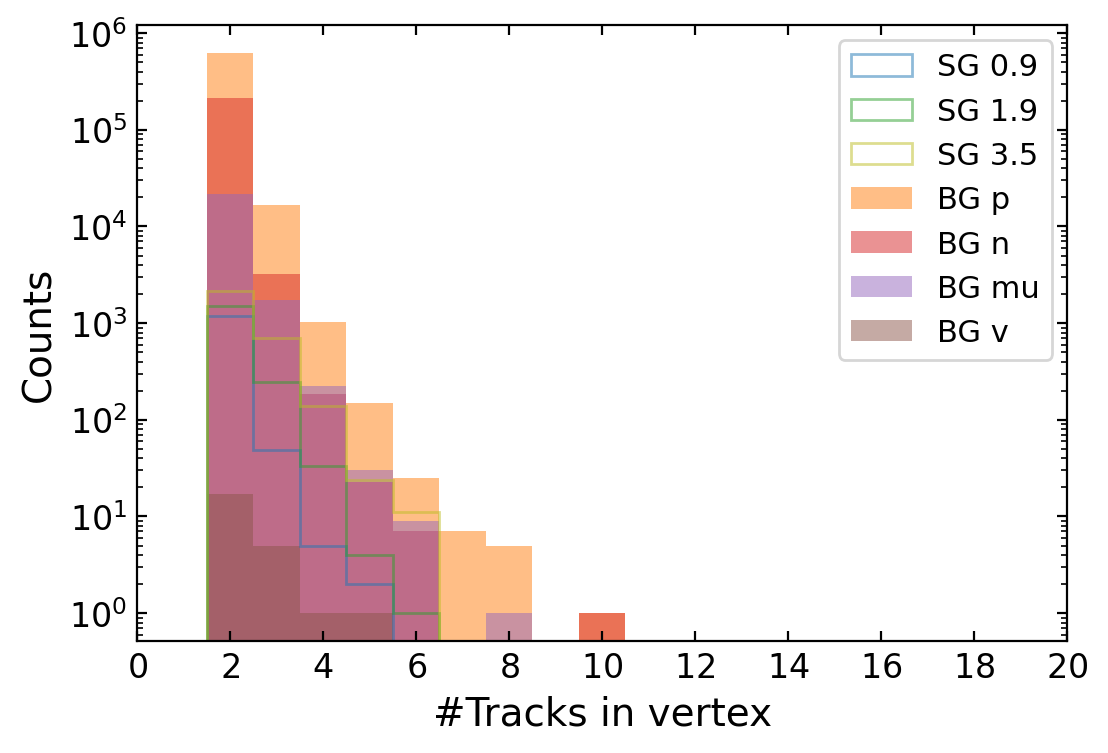

In [10]:
for name, cfg in plot_settings.items():
    res = data[name]
    plt.hist(res["vertex_ntracks"], bins=21,range=(-0.5,20.5), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


# plt.axvspan(0,NTRACK+0.5,color="r", alpha=0.1, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0,20)
save_fig("comb_ntrack_hits")
plt.show()

In [11]:
# for name, cfg in plot_settings.items():
#     res = data[name]
#     plt.hist(res["vertex_topfrac"][res["vertex_ntracks"]==2], bins=21,range=(0,1), alpha=0.5, 
#              color=cfg.color, label=cfg.label, histtype=cfg.histtype)




# plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
# plt.yscale("log")
# plt.xlabel("#Tracks in vertex")
# plt.ylabel("Counts")
# plt.legend(loc=(1.01,0))
# plt.show()

1225
0.0 4.0


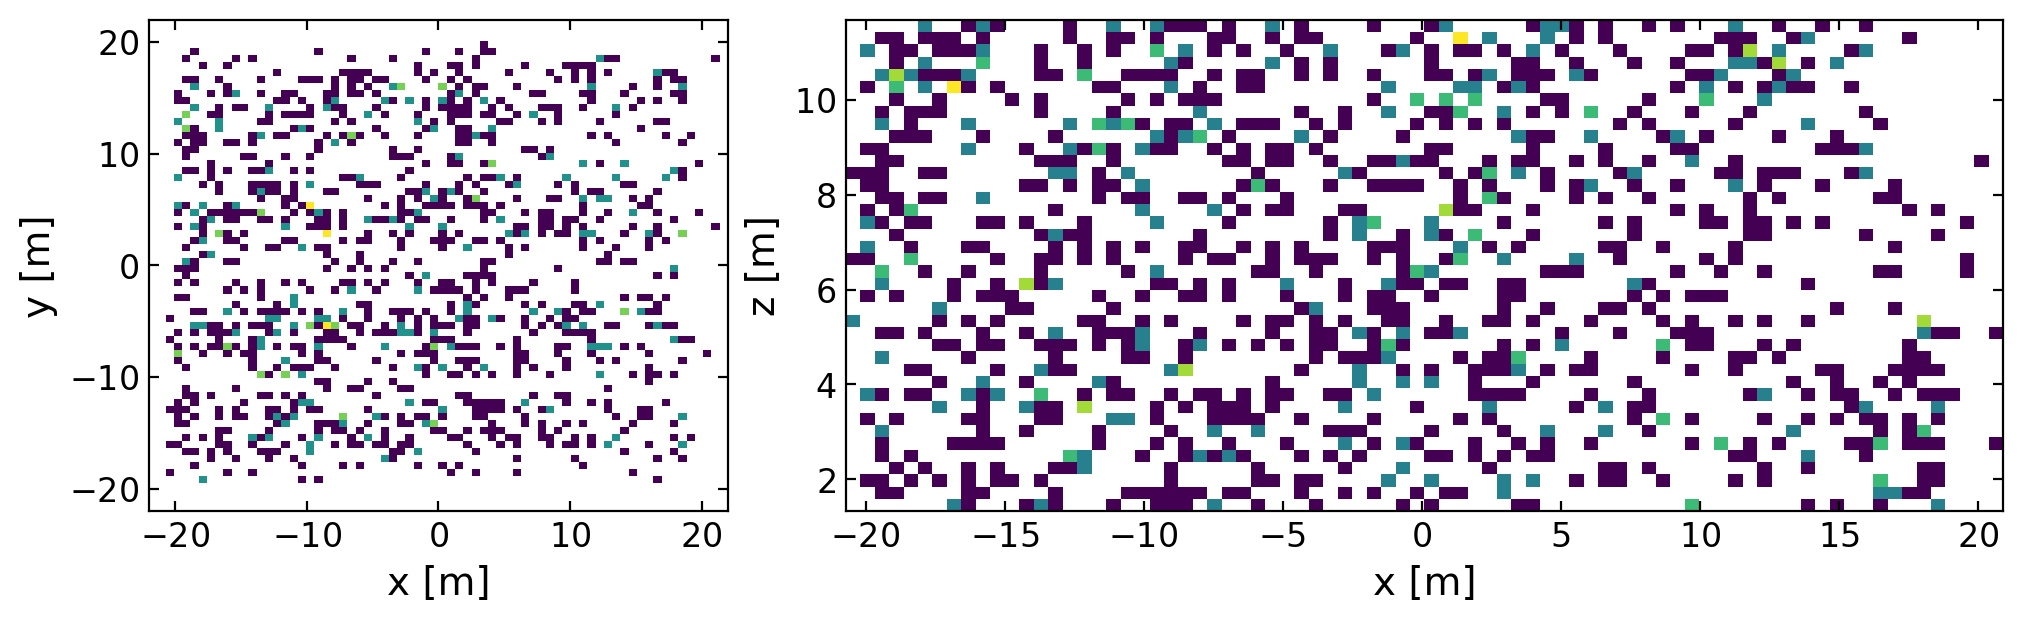

1756
0.0 5.0


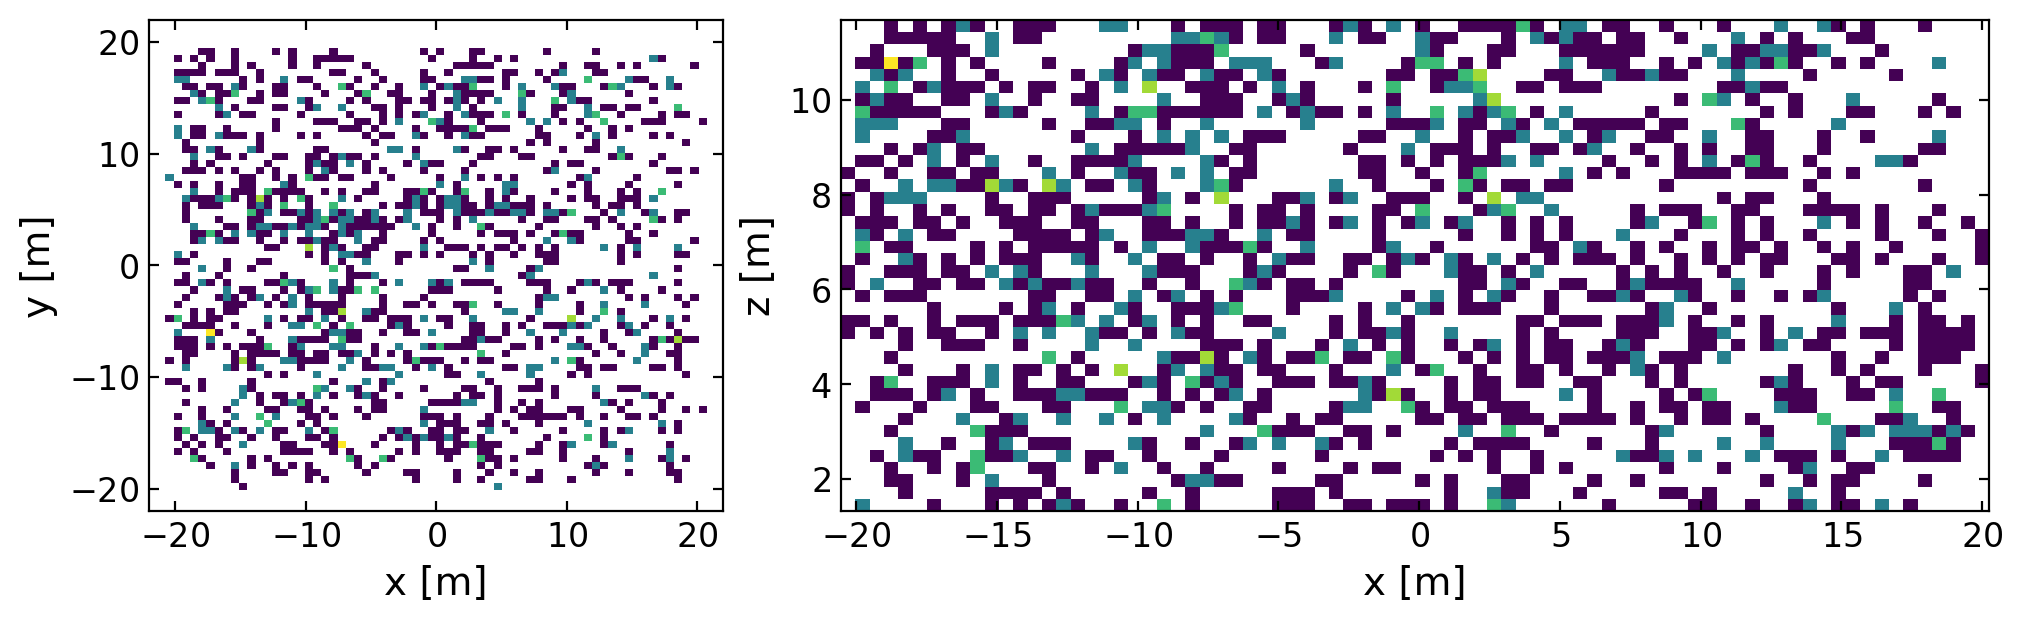

2976
0.0 7.0


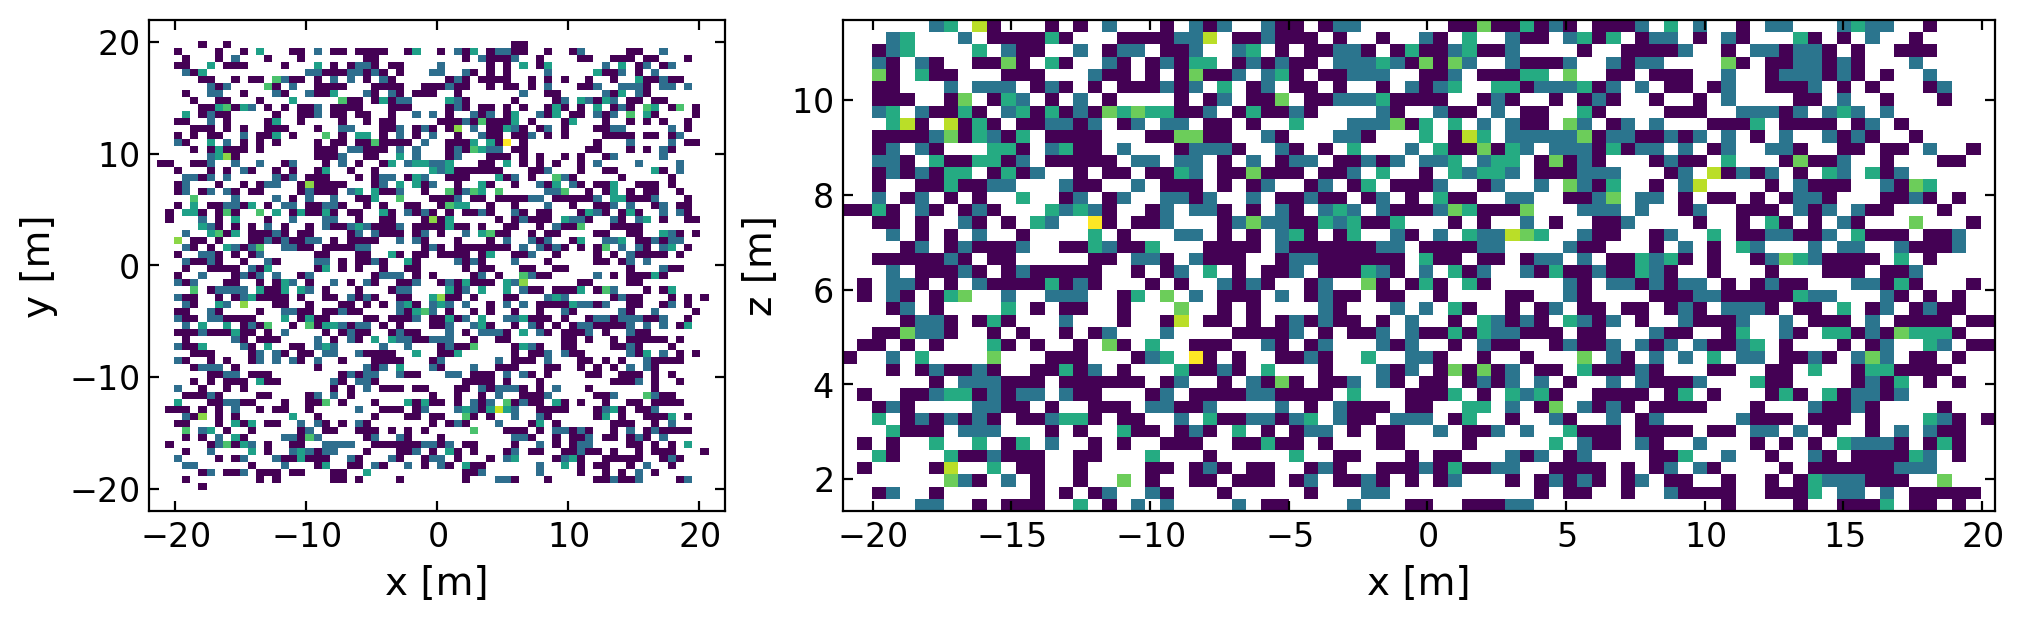

566577
0.0 576.0


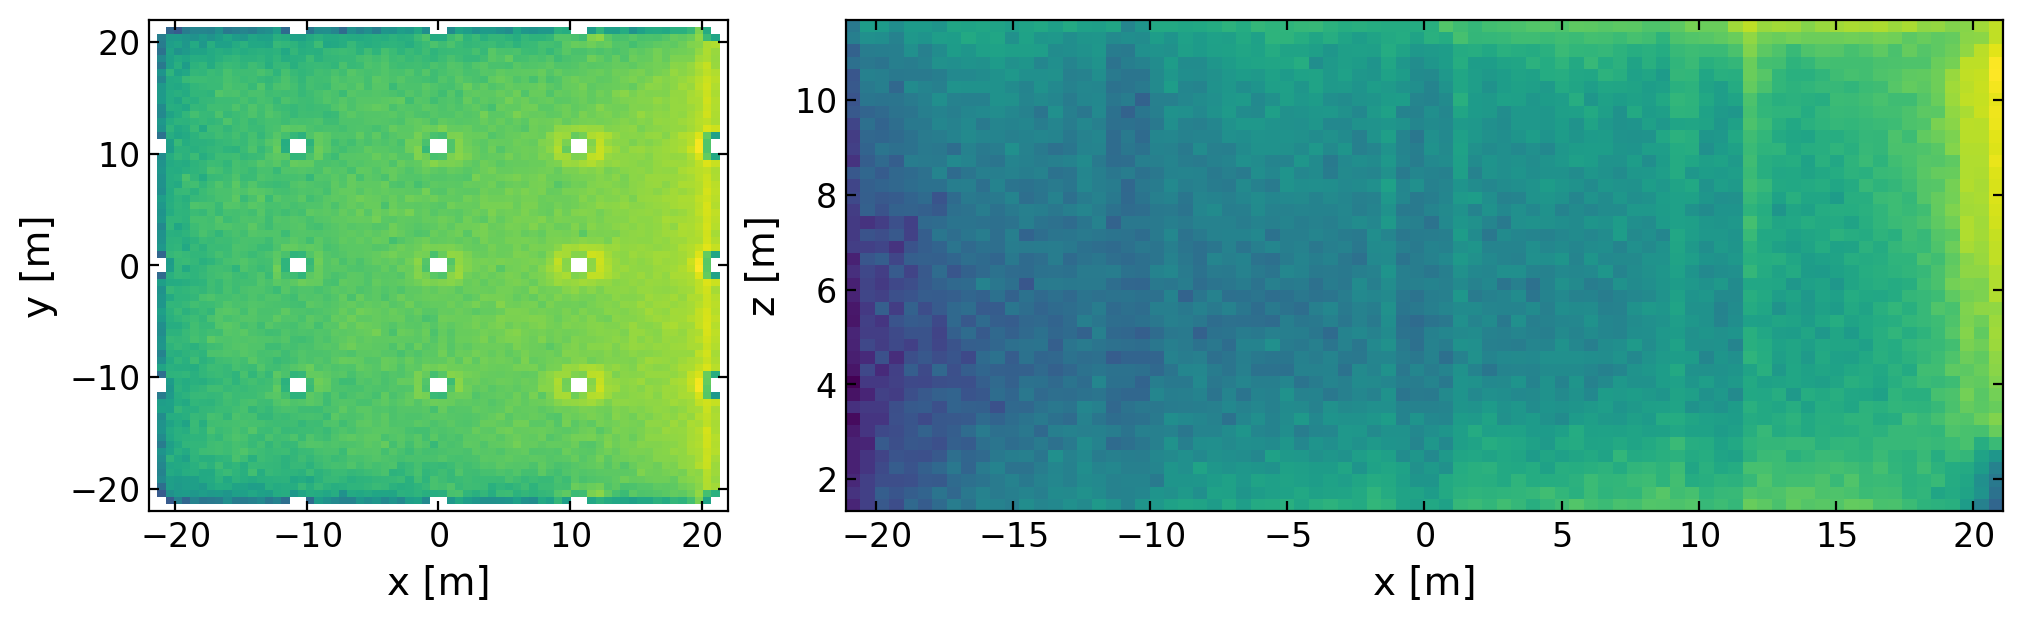

200440
0.0 141.0


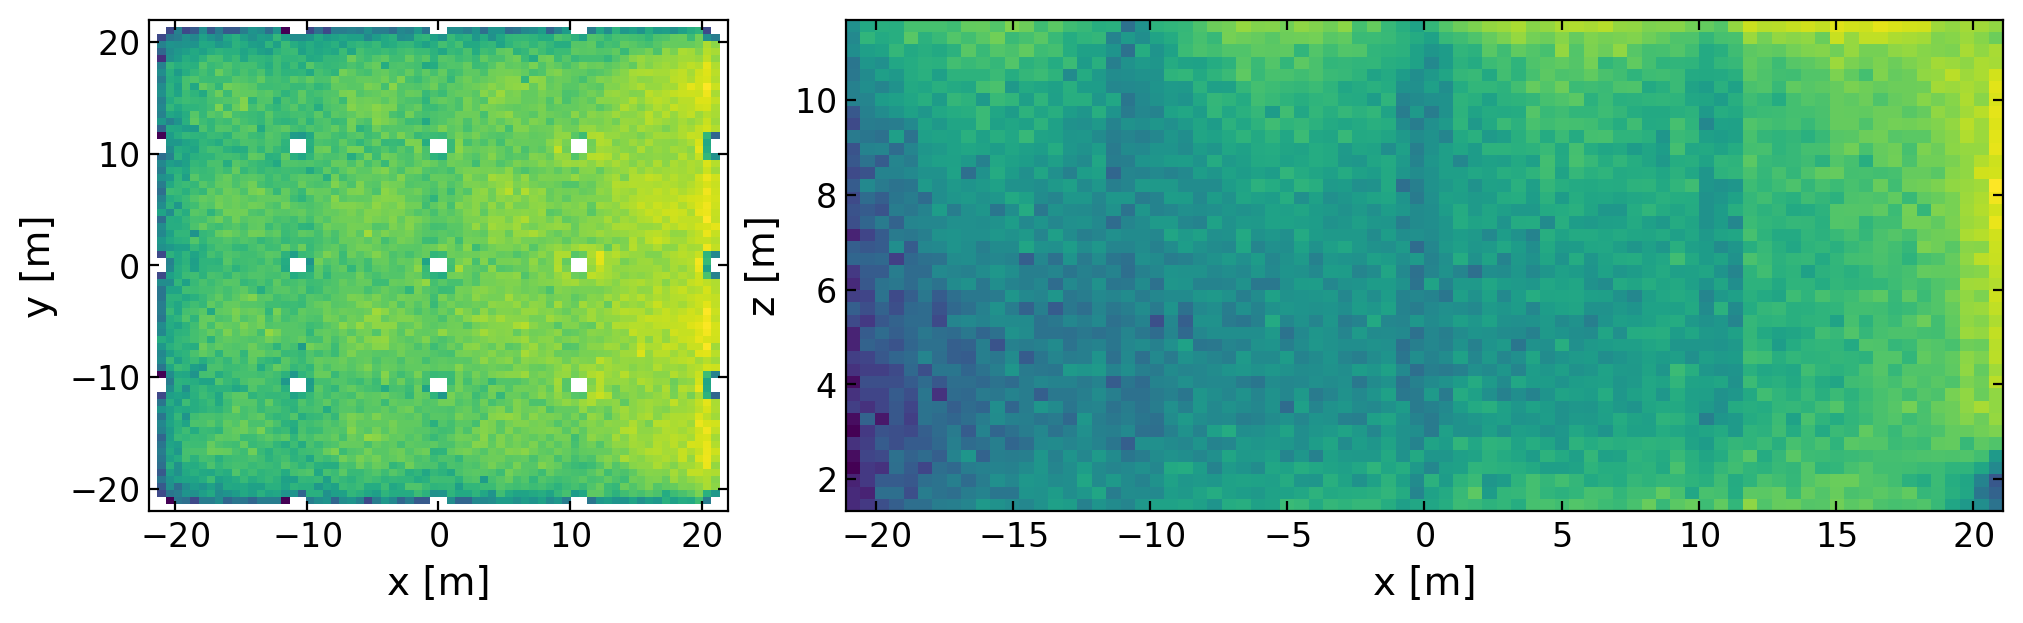

23056
0.0 27.0


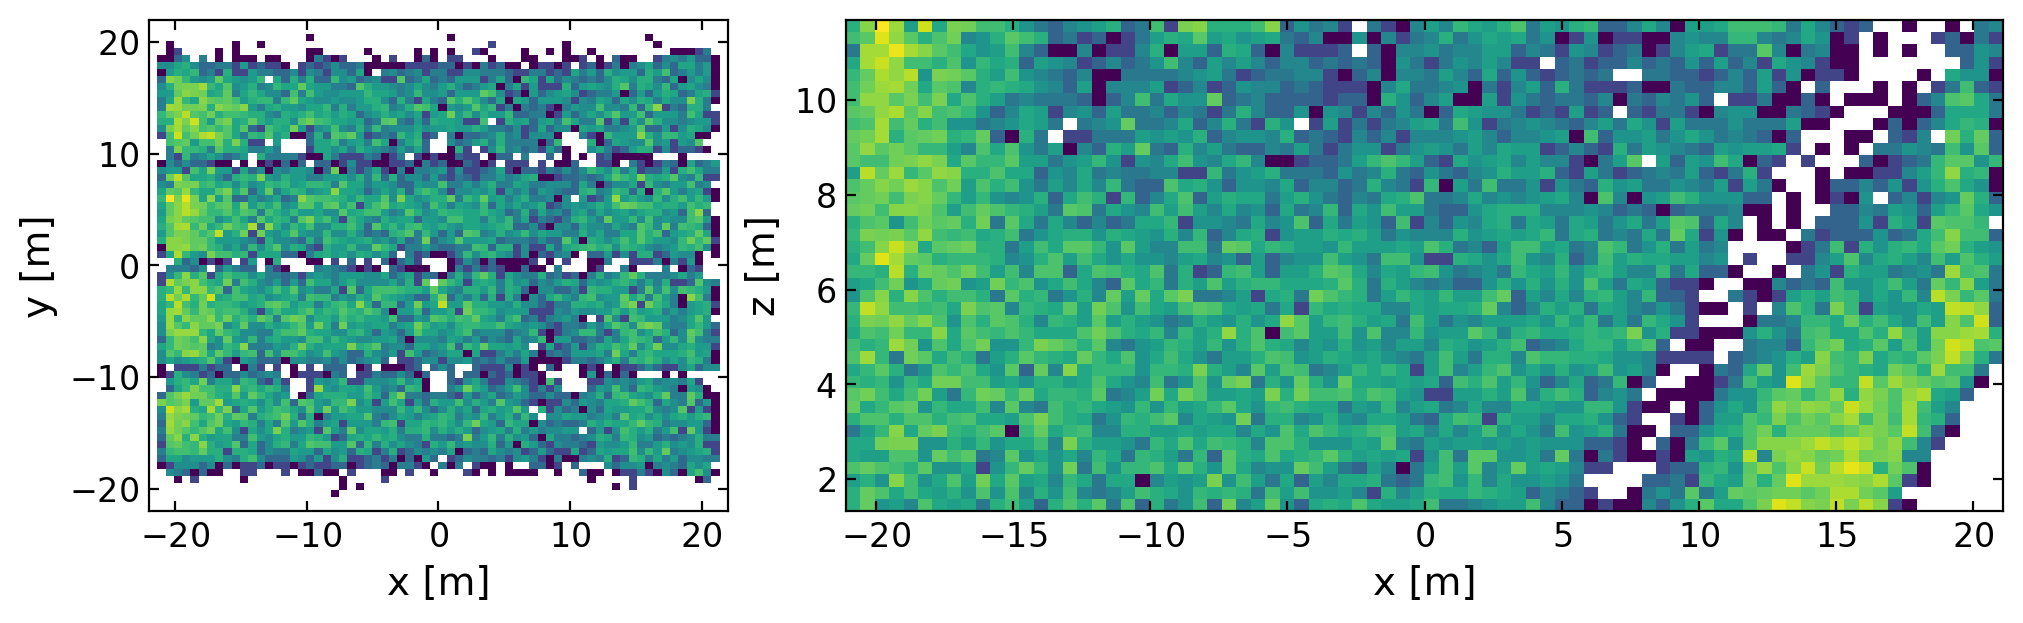

22
0.0 2.0


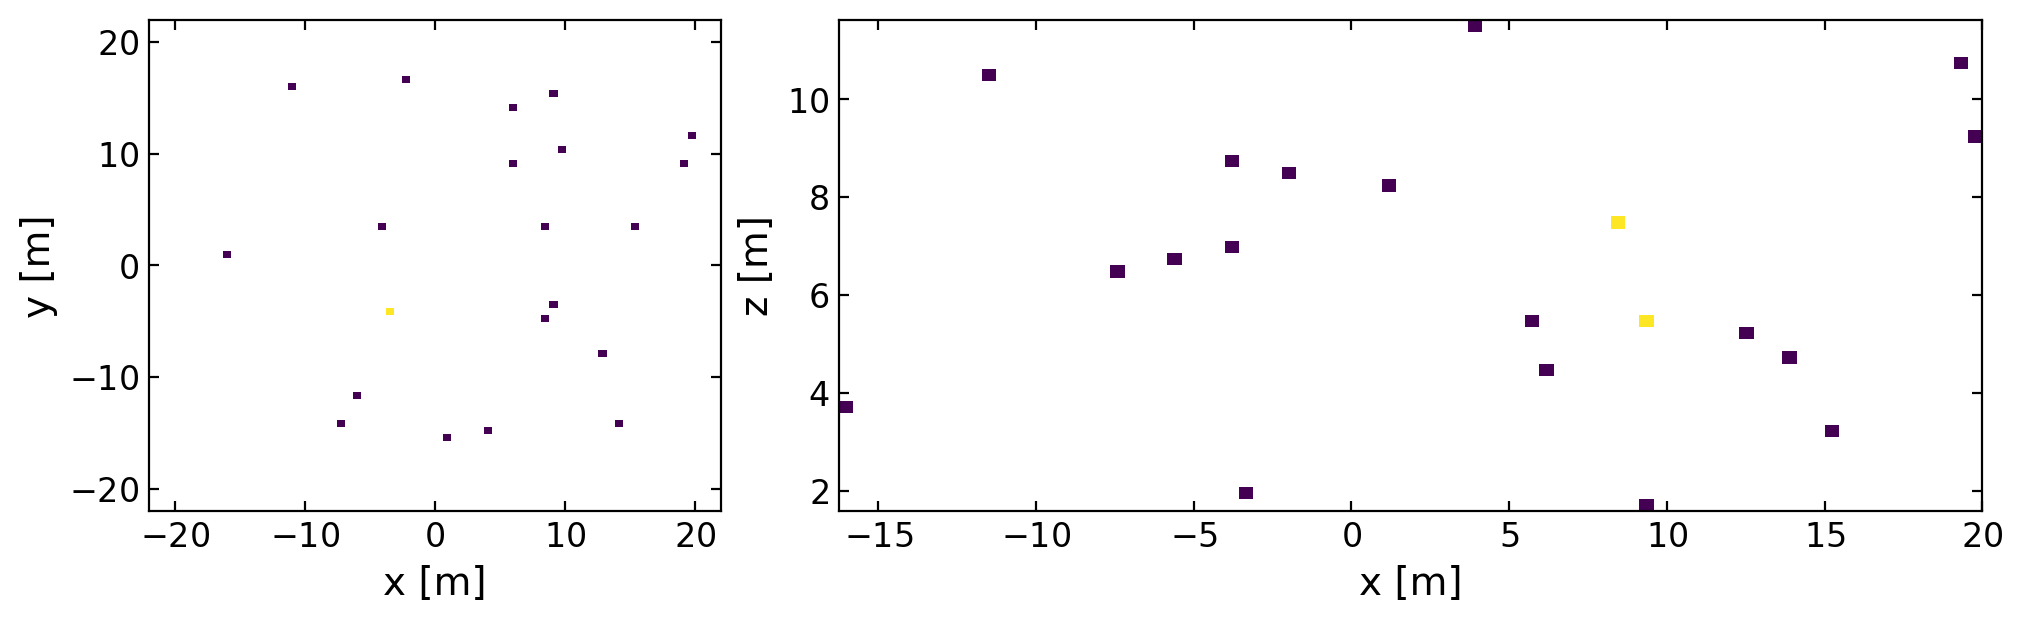

In [13]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask =  res.get_cut("Fiducial volume") # & res.get_cut("N track downward")#| res.get_cut("True") res.get_cut(f"More than 2 tracks") #
    mask_fid = res.get_cut("Fiducial volume")#| res.get_cut("True")
    print(sum(mask_fid))
    
    fig = plt.figure(figsize=(10,3), layout="constrained")
    spec = fig.add_gridspec(1,3)
    
    ax1 = fig.add_subplot(spec[:, :1])
    ax2 = fig.add_subplot(spec[:, 1:])


    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,1])[mask]/1000
    x_reject = (res["vertex_xyzt"][:,0])[mask&mask_fid]/1000
    y_reject = (res["vertex_xyzt"][:,1])[mask&mask_fid] /1000   
    h,xe,ye = hp.histogram2d(x, y, bins=(70,70), range=((-22,22),(-22,22)))
    print(np.min(h), np.max(h))
    ax1.hist2d(x, y, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.hist2d(x_reject, y_reject, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.scatter(x_reject, y_reject, alpha=0.83, s=1, color="r")
    # plt.colorbar()
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")

    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,2])[mask]/1000
    ax2.hist2d(x, y, bins=(80,40), norm=mpl.colors.LogNorm())
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("z [m]")
    
    plt.show()

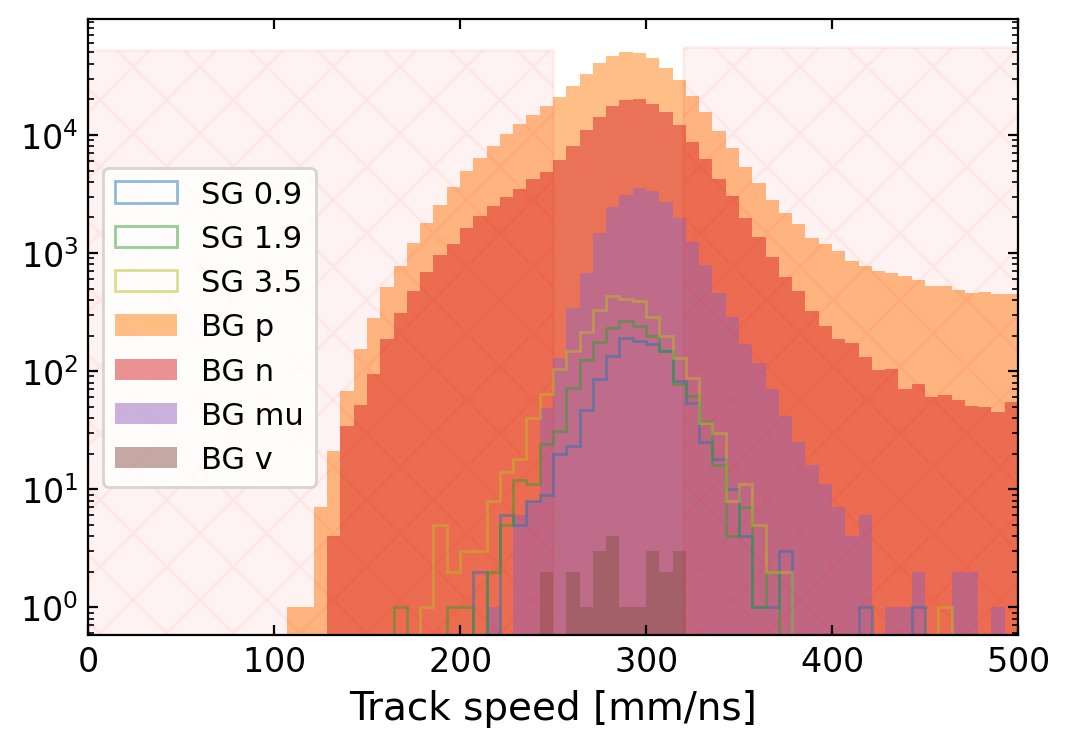

In [14]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask = res.get_cut("Fiducial volume")#& res.get_cut("N track downward")
    # mask = res.get_cut(f"More than {NTRACK} tracks") & res.get_cut("Fiducial volume")
    
    plt.hist(res["vertex_slowest_track"][mask], bins=70,range=(0,500),alpha=0.5, color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    
plt.xlabel("Track speed [mm/ns]")
# plt.ylim(1,2e3)
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 250, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 320, 500, color="r", alpha=0.05, hatch="X")

plt.xlim(0,500)
plt.yscale("log")
plt.legend()
save_fig("comb_track_speed")
plt.show()

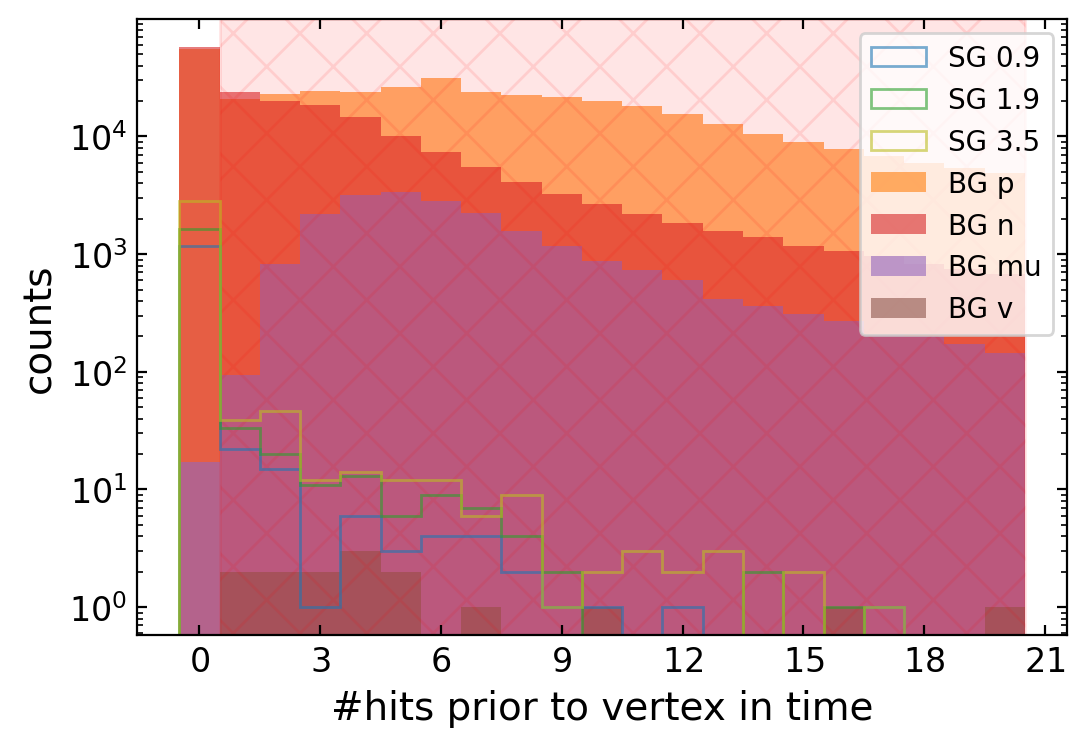

In [15]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask =  res.get_cut("Fiducial volume") # res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2") #| res.get_cut("True") res.get_cut("N track downward") & res.get_cut("Track velocity") &
    plt.hist(res["vertex_ndigi_before_limited"][mask], range=(-0.5,20.5), bins=21, alpha=0.6,\
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))

plt.xlabel("#hits prior to vertex in time")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.axvspan(0.5,20.5,color="r", alpha=0.1, hatch="X")

lh = plt.legend(fontsize=10)
save_fig("comb_nhits_prior")


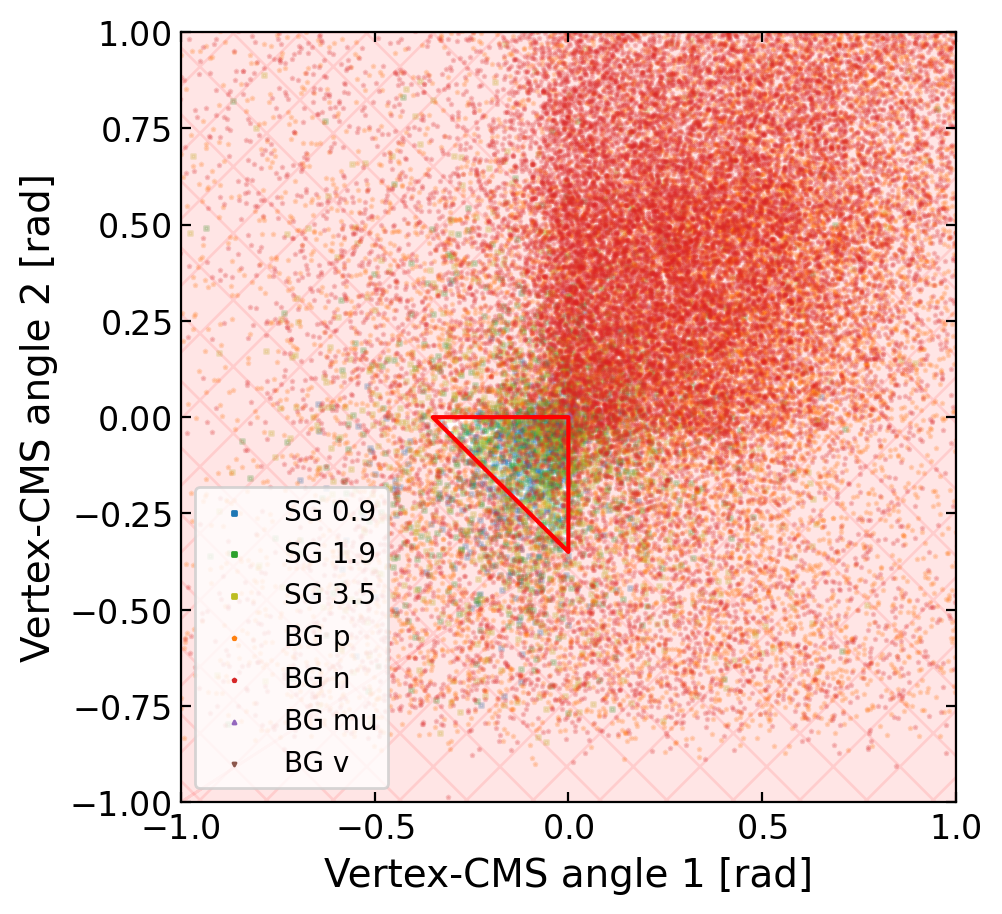

In [19]:
plt.figure(figsize=(5,5))
for name, cfg in plot_settings.items():
    res = data[name]

    # if "bkg" in name:
    #     continue
    
    c2 = res.get_cut("More than 2 tracks")
    mask =  (~c2) & res.get_cut("N track downward") & res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") #& res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    
    x = (res["vertex_cms_angle_h"])[mask]
    y = res["vertex_cms_angle_v"][mask]
    alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize*0.3)
    


# Plot the cut region
# poly = [[-cut_angel_v1,0], [0, cut_angel_v1], [cut_angel_v1,0], [0, -cut_angel_v1], [0,-cut_angel_v2], [-cut_angel_v2,0]]
poly = [[0,0], [0,-cut_angel_v2], [-cut_angel_v2,0]]
polt_out = np.transpose(hplt.fill_outside(np.transpose(poly)[0],np.transpose(poly)[1], [-1,-1],[1,1]))

col1 = mpl.collections.PolyCollection([poly], edgecolors="r")
col1.set_linewidth(1.5)
col1.set_facecolor("none")  # Transparent face
col = mpl.collections.PolyCollection([polt_out], edgecolors="r", alpha=0.1, hatch="X")
col.set_facecolor('r')  # Transparent face
plt.gca().add_collection(col1)
plt.gca().add_collection(col)




plt.xlabel("Vertex-CMS angle 1 [rad]")
plt.ylabel("Vertex-CMS angle 2 [rad]")
# plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(-1,1)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque

save_fig("comb_cms_angle")

In [21]:
# plt.figure(figsize=(5,5))
# for name, cfg in plot_settings.items():
#     res = data[name]

#     # if "bkg" in name:
#     #     continue
    
#     c2 = res.get_cut("More than 2 tracks")
#     mask =  (~c2) & res.get_cut("N track downward") & res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") #& res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    
#     x = (res["vertex_cms_angle_v_span"])[mask]
#     y = res["vertex_cms_angle_v"][mask]
#     alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
#     plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize*0.3)
    






# plt.xlabel("Vertex-CMS angle 1 span [rad]")
# plt.ylabel("Vertex-CMS angle 1 dev [rad]")
# # plt.yscale("log")
# plt.xlim(-1,1)
# plt.ylim(-1,1)

# lh = plt.legend(fontsize=10)
# # make legend non-transparent
# for handle in lh.legend_handles:
#     handle.set_alpha(1.0)  # Make legend items fully opaque

In [24]:
# f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)

# for name, cfg in plot_settings.items():
#     # if "bkg" in name:
#     #     continue
    
#     res = data[name]
#     # mask = res.get_cut("Fiducial volume")
#     mask =  res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")# & res.get_cut("N track downward") 
    
#     x = (res["event_ntracks"])[mask]
#     y = (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])[mask]
#     # y = (res["event_ndownward_track"])[mask]
#     # plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize*4)

#     plt.hist(y, bins=np.linspace(0,10,10), histtype=cfg.histtype, log=1, alpha=cfg.alpha_marker)


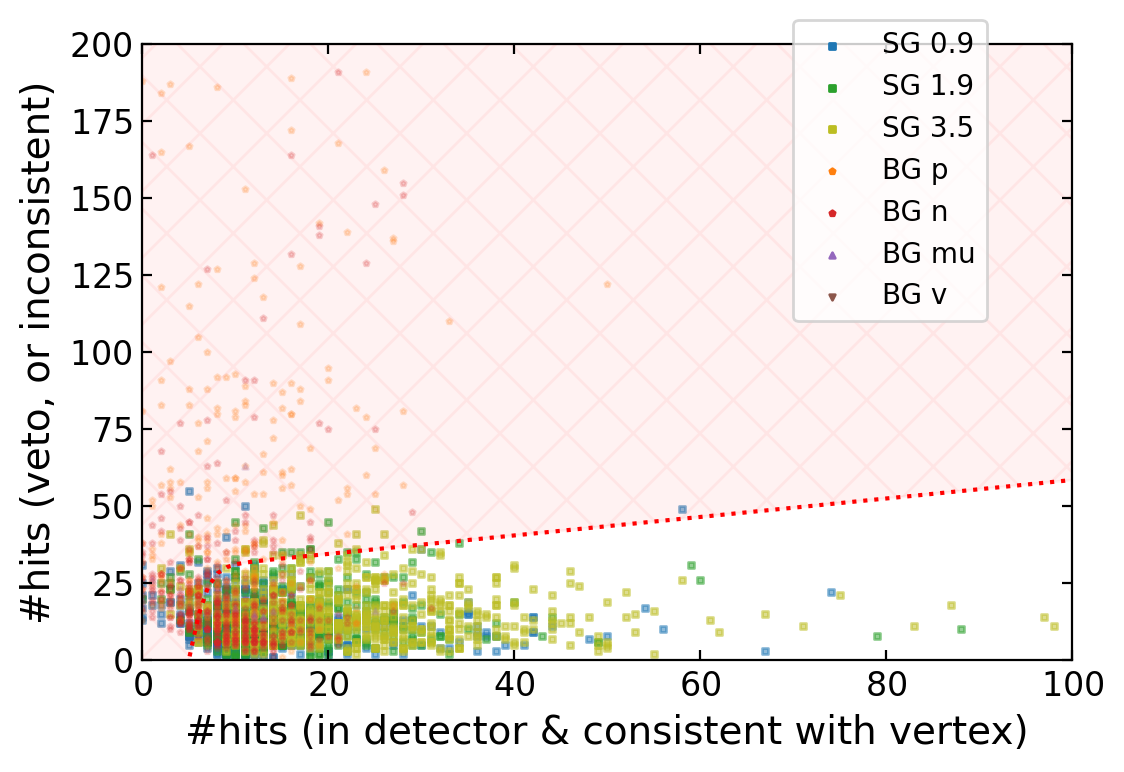

In [25]:
def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y

for name, cfg in plot_settings.items():
    res = data[name]

    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") 
    x = (res["vertex_ndigi_active_after_comp"])[mask]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)


xlim = 100
ylim = 200
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
plt.xlabel("#hits (in detector & consistent with vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10, loc=(0.7,0.55))
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque


save_fig("comb_n_veto_cut_1")

580
466
545
101
292
7
0


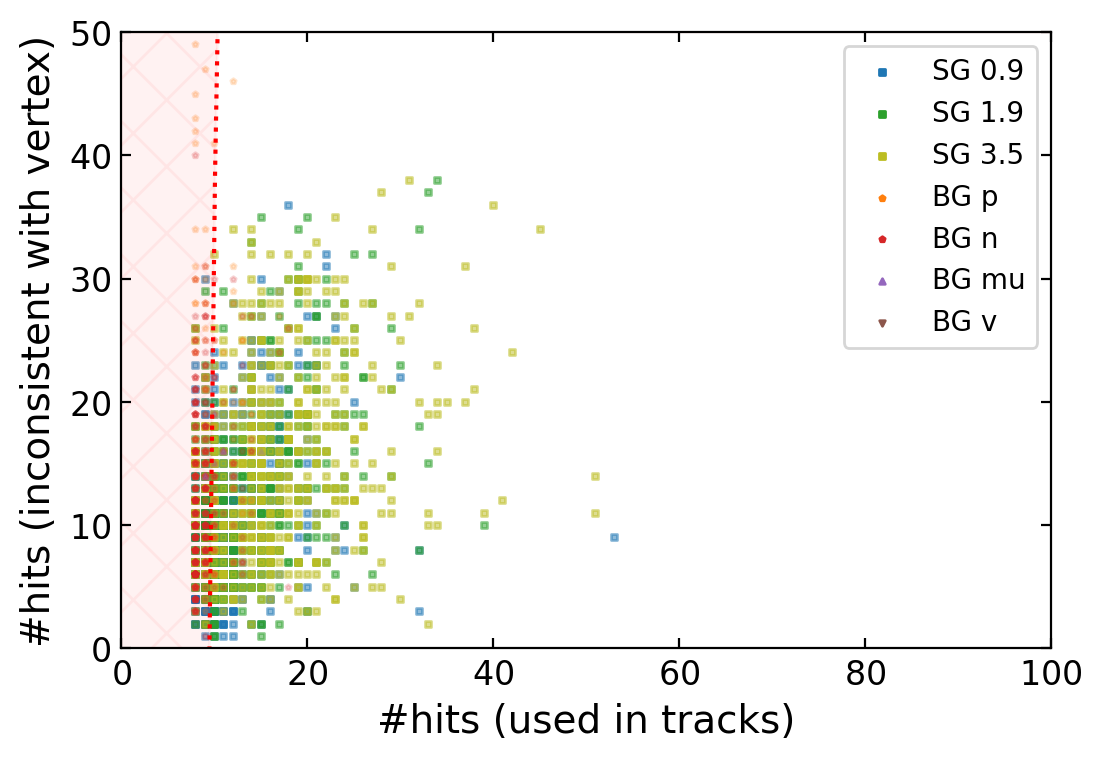

In [43]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")

    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"]- res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)
    print(sum(mask))

xlim=100
ylim=50
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05, hatch="X")

plt.xlabel("#hits (used in tracks)")
plt.ylabel("#hits (inconsistent with vertex)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque
    
save_fig("comb_n_veto_cut_2")

(0.0, 50.0)

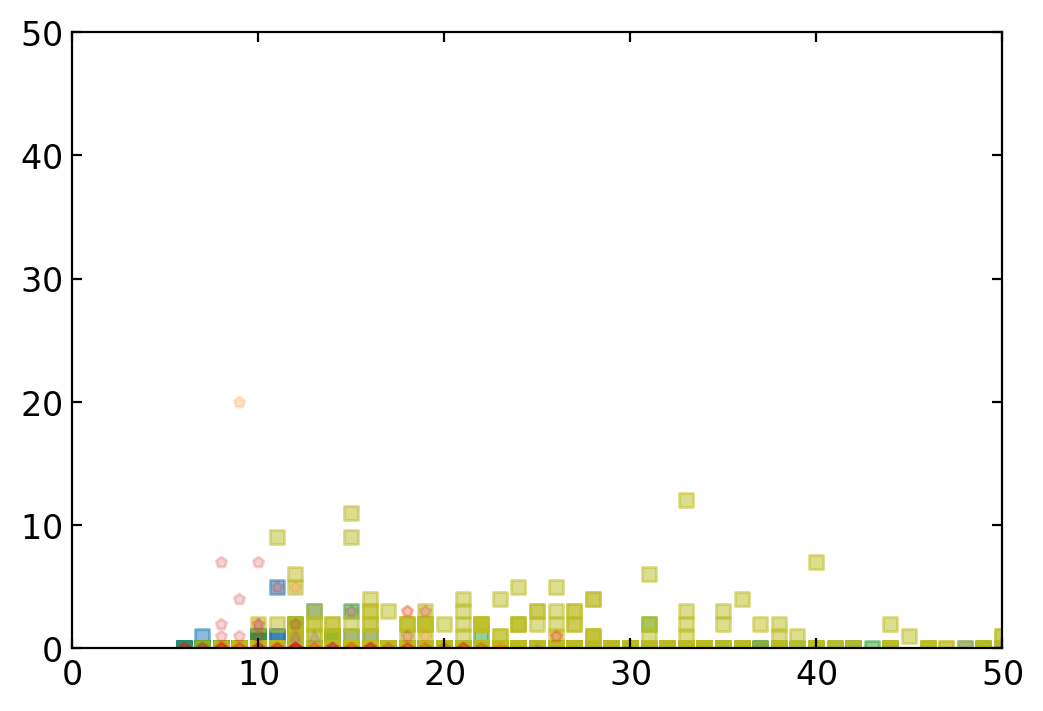

In [85]:

for name, cfg in plot_settings.items():
#     # if "bkg" in name:
#     #     continue
    
    res = data[name]
    # mask = res.get_cut("Fiducial volume")
    mask =  res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2")
    
    x = (res["vertex_ndigi_active_after_comp"])[mask]
    y = ( res["vertex_ndigi_veto_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize*4)

plt.xlim(0,50)
plt.ylim(0,50)

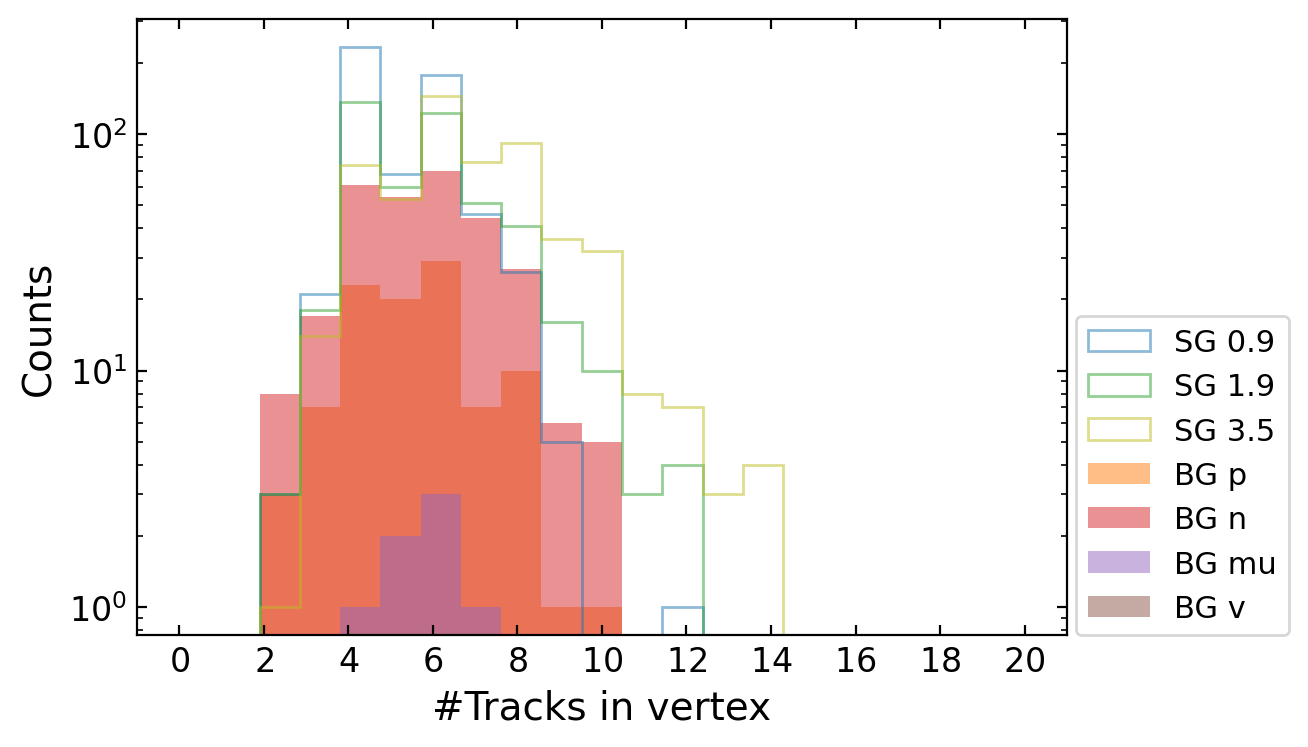

In [27]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")
    plt.hist((res["vertex_ntracks"]+ res["vertex_ntracklet_3+"])[mask], bins=21,range=(0,20), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)




plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

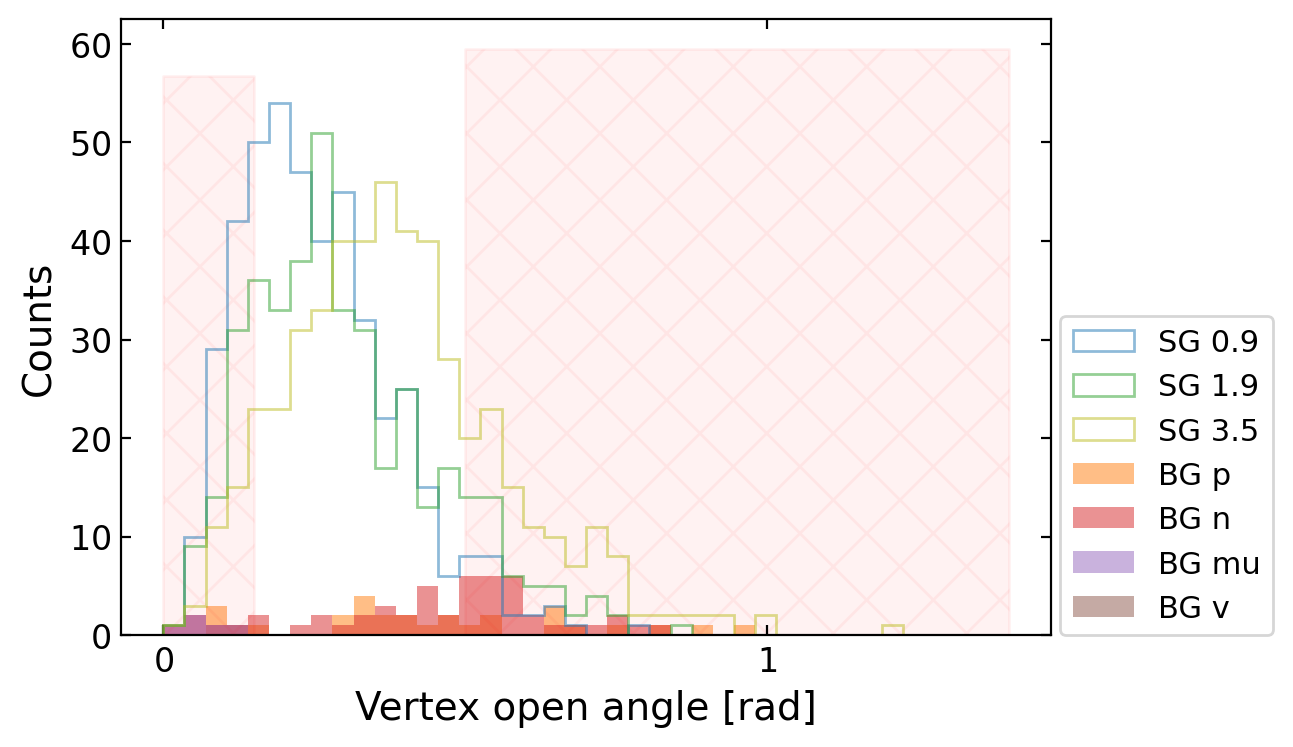

In [84]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto") #&res.get_cut("N_hits vs N_veto 2")
    plt.hist((res["vertex_open_angle"])[mask], bins=40,range=(0,1.4), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 0.15, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0.5,1.4, color="r", alpha=0.05, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
# plt.yscale("log")
plt.xlabel("Vertex open angle [rad]")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

---
Plot event

In [675]:
i=3
fname_recon_sig  =   f"{data_dir}/llp_sms/run_{i}_digi_cosmic_recon_skim.root"
fsig1 = root.tfile_reader(fname_recon_sig)
fsig1.get_tree("metadata_digi")
metadata_digi = fsig1.get_entry(0)
fsig1.get_tree("data;1")
print(f"Entries", fsig1.entries)

Entries 1445


116


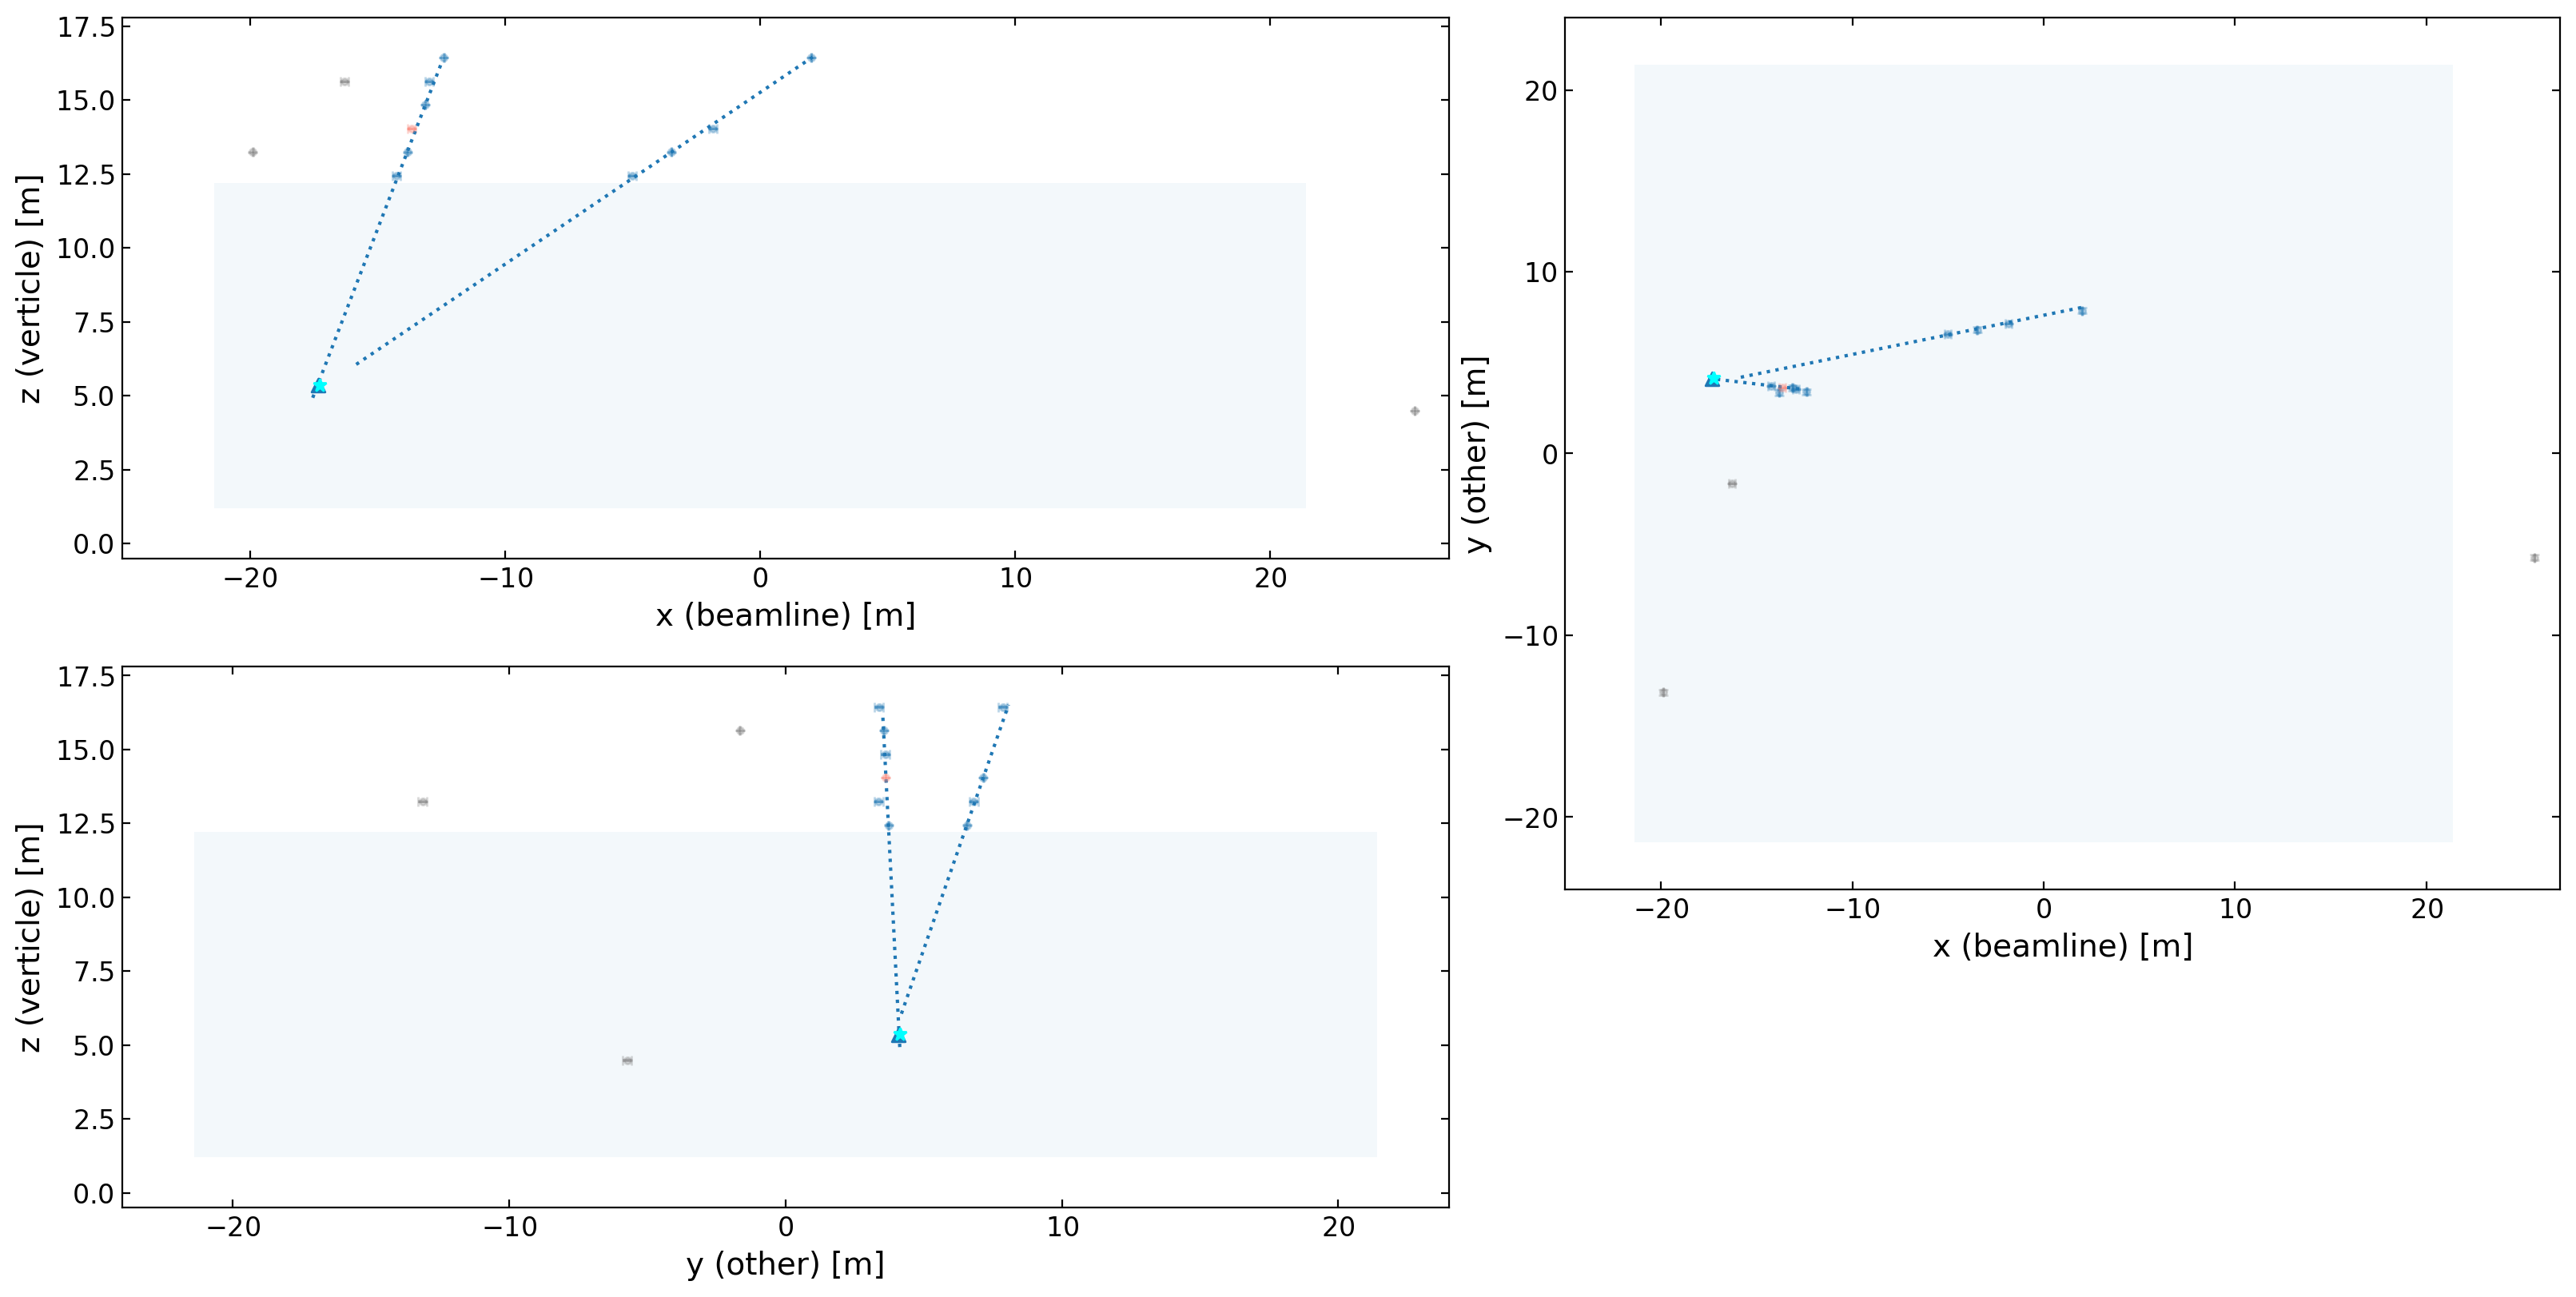

In [788]:
i+=1
# i=0
print(i)

rawdata = fsig1.get_entry(i)
event = datatypes.Event(rawdata, metadata_digi)  
event.plot()


# x = (res["vertex_ndigi_active_after_comp"])[k]
# y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[k]

# print(res["vertex_ntracklet_3+"][rq_inds[i]])
# print(res["vertex_xyzt"][rq_inds[i]])
# print(res["vertex_open_angle"][rq_inds[i]])
# print("consistent, inconsistent", x,y)


In [16]:
fname_comb_p = f"{data_dir}/cedar/cosmic/cosmic_p/merged_p_1200runs.root"
fname_comb_n = f"{data_dir}/cedar/cosmic/cosmic_n/merged_n_2172runs.root"
fname_comb_v = f"{data_dir}/cedar/neutrino/merged.root" # On cedar: /project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/v2_recon_and_skim/merged.root
fname_comb_mu = f"{data_dir}/cedar/muon/merged.root"# On cedar: /project/6049244/data/MATHUSLA/simulation//run-2024-07-mathusla40-full/v2_recon_and_skim/merged.root

fbkg = root.tfile_reader(fname_comb_p)
fbkg.ls()
## Get metadata
fbkg.get_tree("metadata_digi")
metadata_digi = fbkg.get_entry(0)
fbkg.get_tree("data;1")
print("Entries", fbkg.entries)

fbkg_n = root.tfile_reader(fname_comb_n)
# fbkg_n.ls()
fbkg_n.get_tree("data;1")
print("Entries", fbkg_n.entries)

fbkg_v = root.tfile_reader(fname_comb_v)
# fbkg_n.ls()
fbkg_v.get_tree("data;1")
print("Entries", fbkg_v.entries)

fbkg_mu = root.tfile_reader(fname_comb_mu)
# fbkg_n.ls()
fbkg_mu.get_tree("data;1")
print("Entries", fbkg_mu.entries)

None
Entries 839934
Entries 290908
Entries 30
Entries 24729
TFile**		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
 TFile*		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TParameter<int>	N_MERGED;1	
  KEY: TTree	data;1	Reconstruction Tree Skimmed


In [17]:
Fiducial volume       566577  200440   23056      22    2835    1225    1756    2976    3600
N digi before          55494   57386      17       0    2706    1163    1647    2811    3375
Track velocity         33213   36904      17       0    2457    1013    1466    2469    2995
Angle to CMS             651     667      13       0    2423     671     560     687     902
Open angle               229     220       0       0     233     506     405     463     592
N track downward         148     197       0       0     225     470     365     404     547
N_hits vs N_veto          50     123       0       0     180     433     338     379     508
N_hits vs N_veto 2        14      22       0       0     122     328     292     341     471

SyntaxError: invalid syntax (2666854818.py, line 1)

In [23]:
res = data['bkg p']
mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")  & res.get_cut("Open angle") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto")  &res.get_cut("N_hits vs N_veto 2")

rq_inds = np.flatnonzero(mask)
plot_inds = res["ROOT_entry"][mask]

In [20]:
i=0

In [21]:
reload(datatypes)

<module 'simhelper.datatypes' from '/home/tomren/geant_projects/mathusla-newsim/studies/mathusla40/llp_rhnmu_sms/../../../python/simhelper/datatypes.py'>

0 14535
3
[8523.475 9946.501 8861.252 -787.849]
0.38487826760519556
consistent, inconsistent 13 20


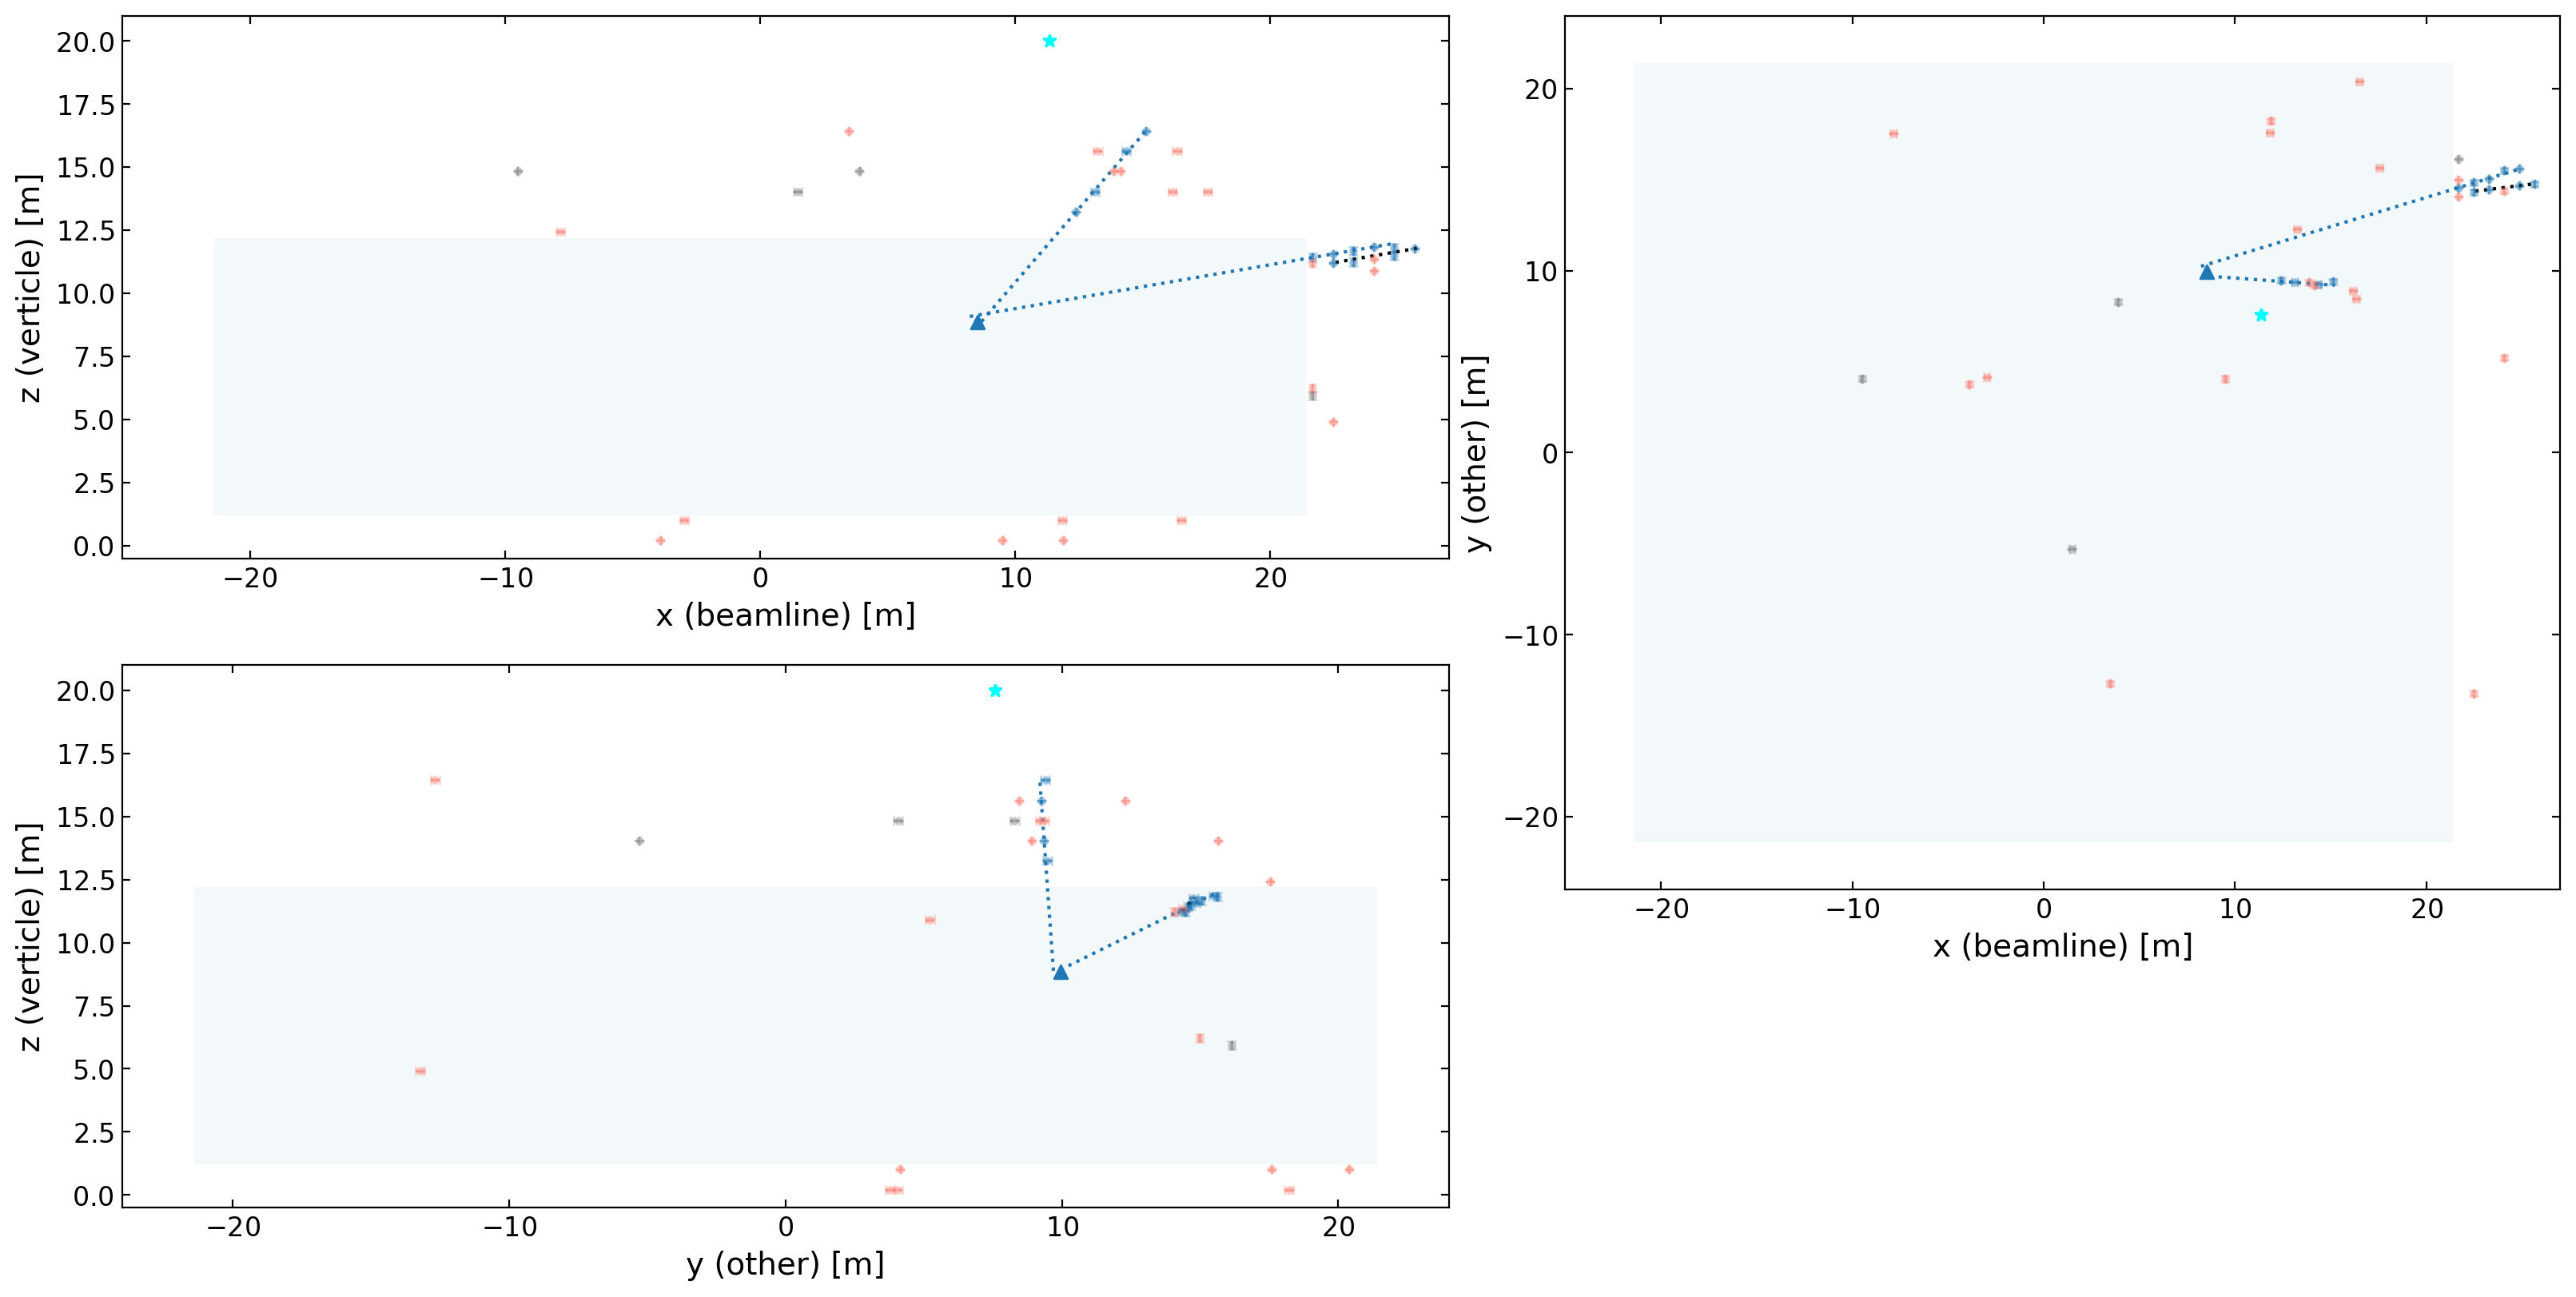

1 58733
2
[  1529.994 -11049.396   5129.236   -348.946]
0.3346238935269618
consistent, inconsistent 12 30


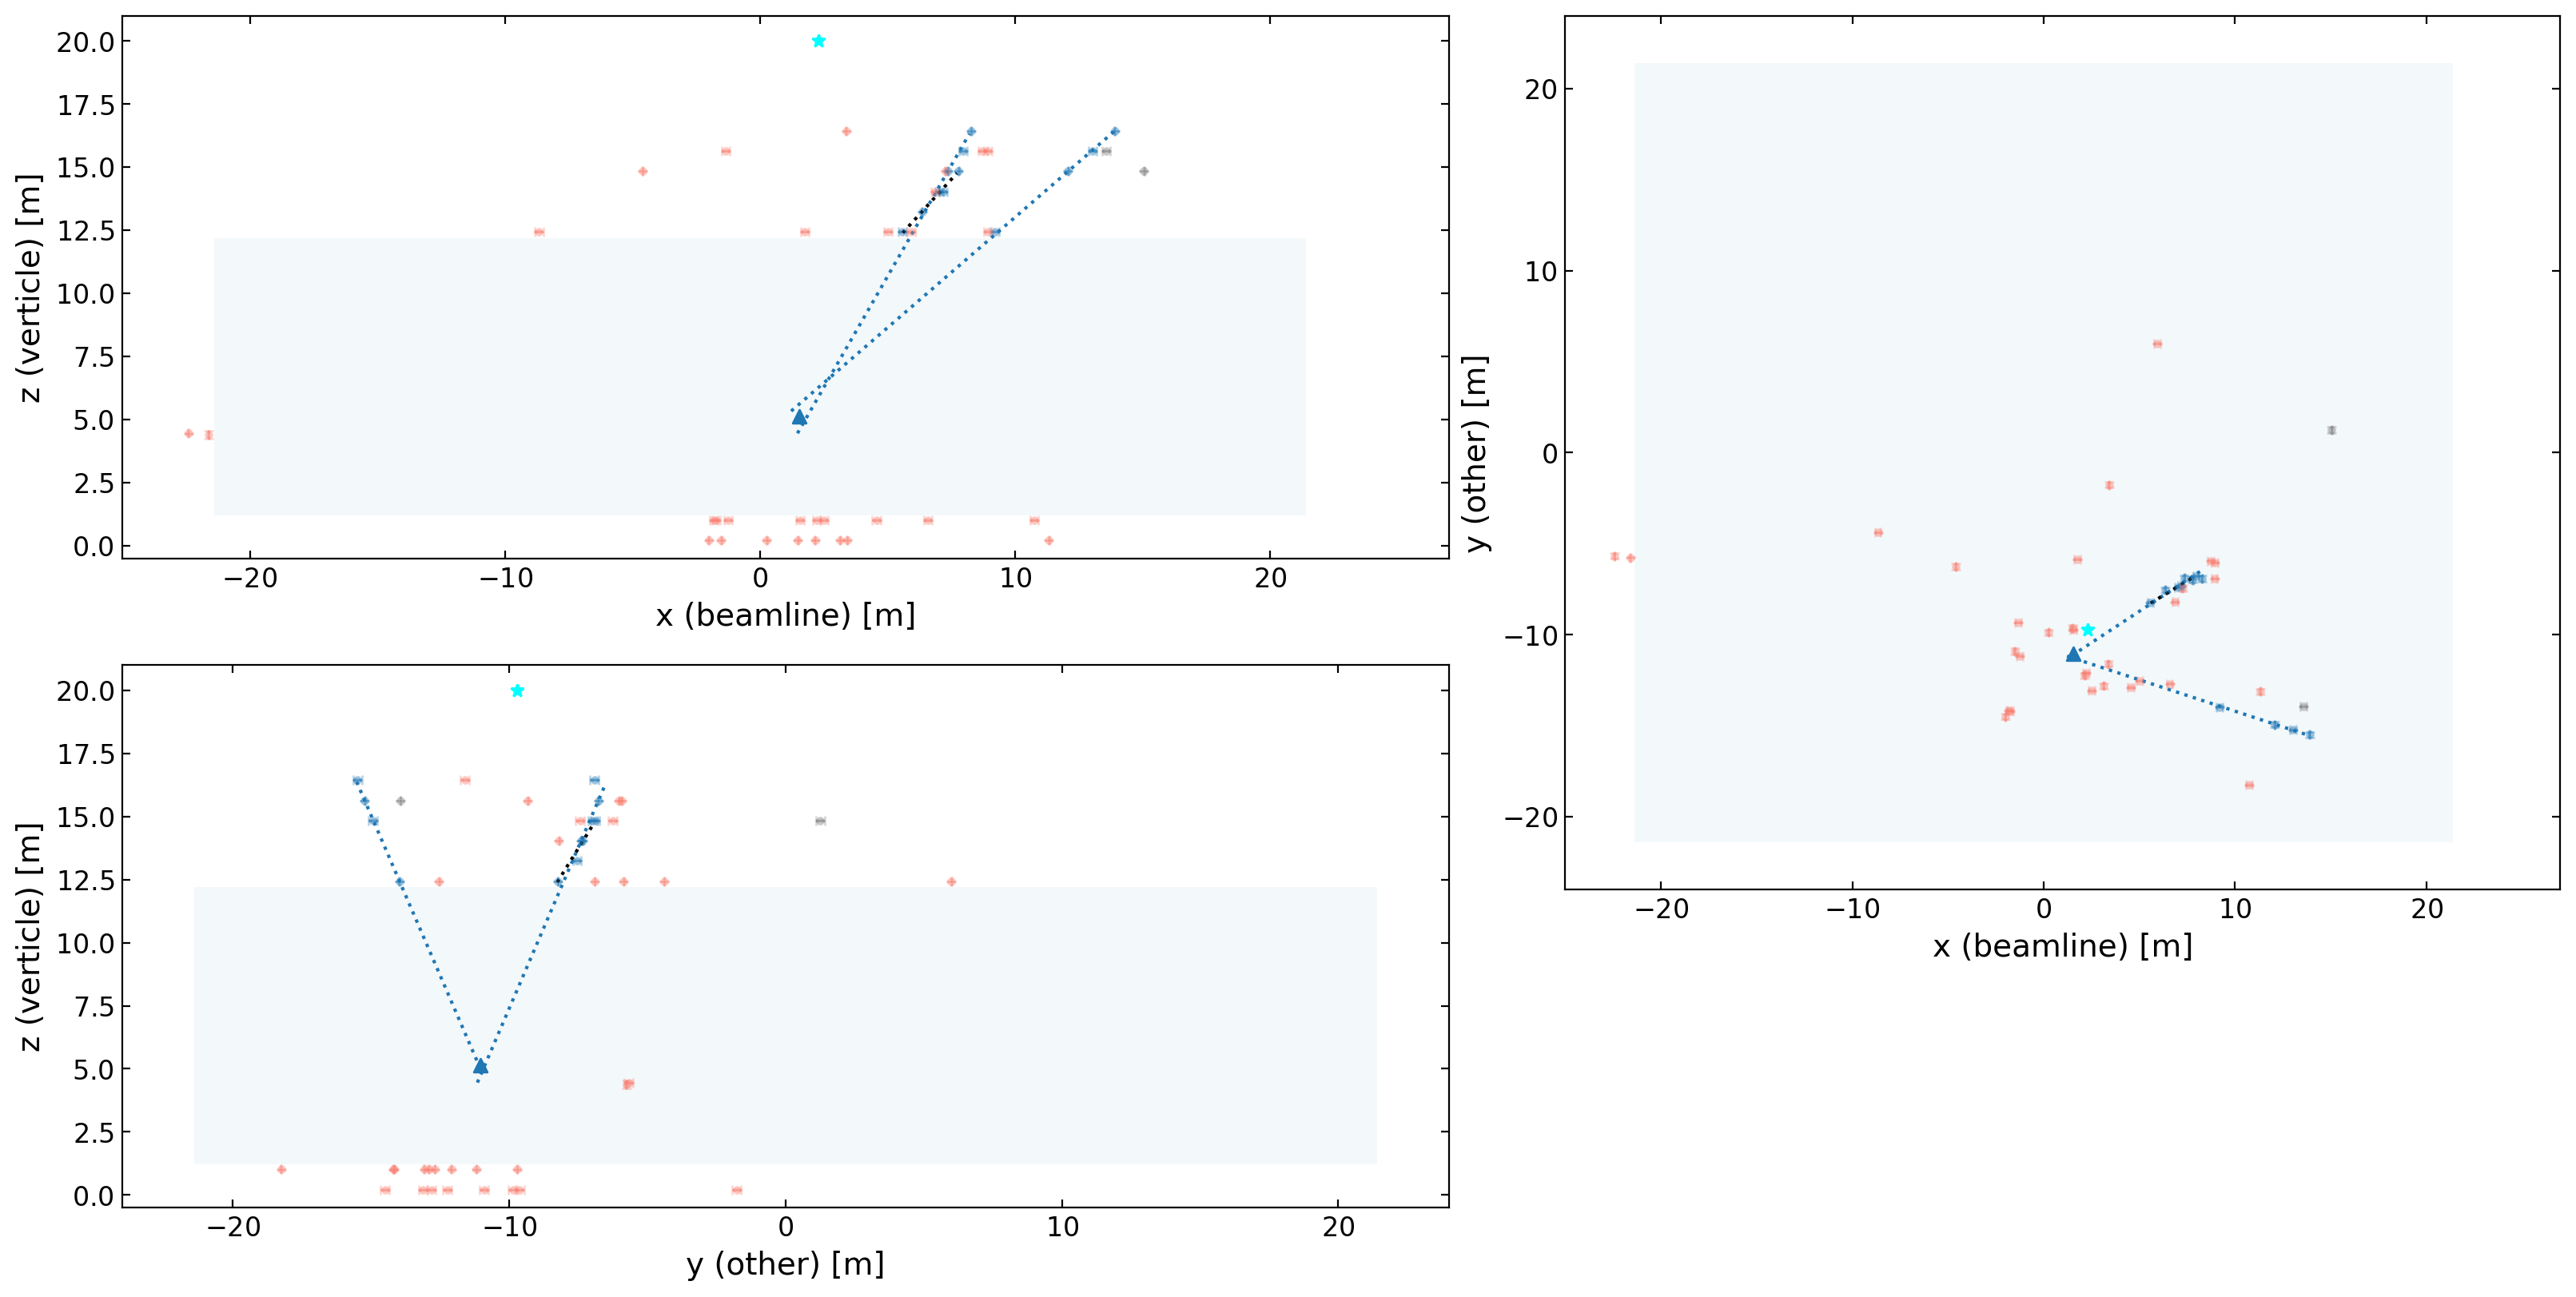

2 76133
6
[-1203.146 -9313.564  8612.396   859.481]
0.28262769915578306
consistent, inconsistent 21 7


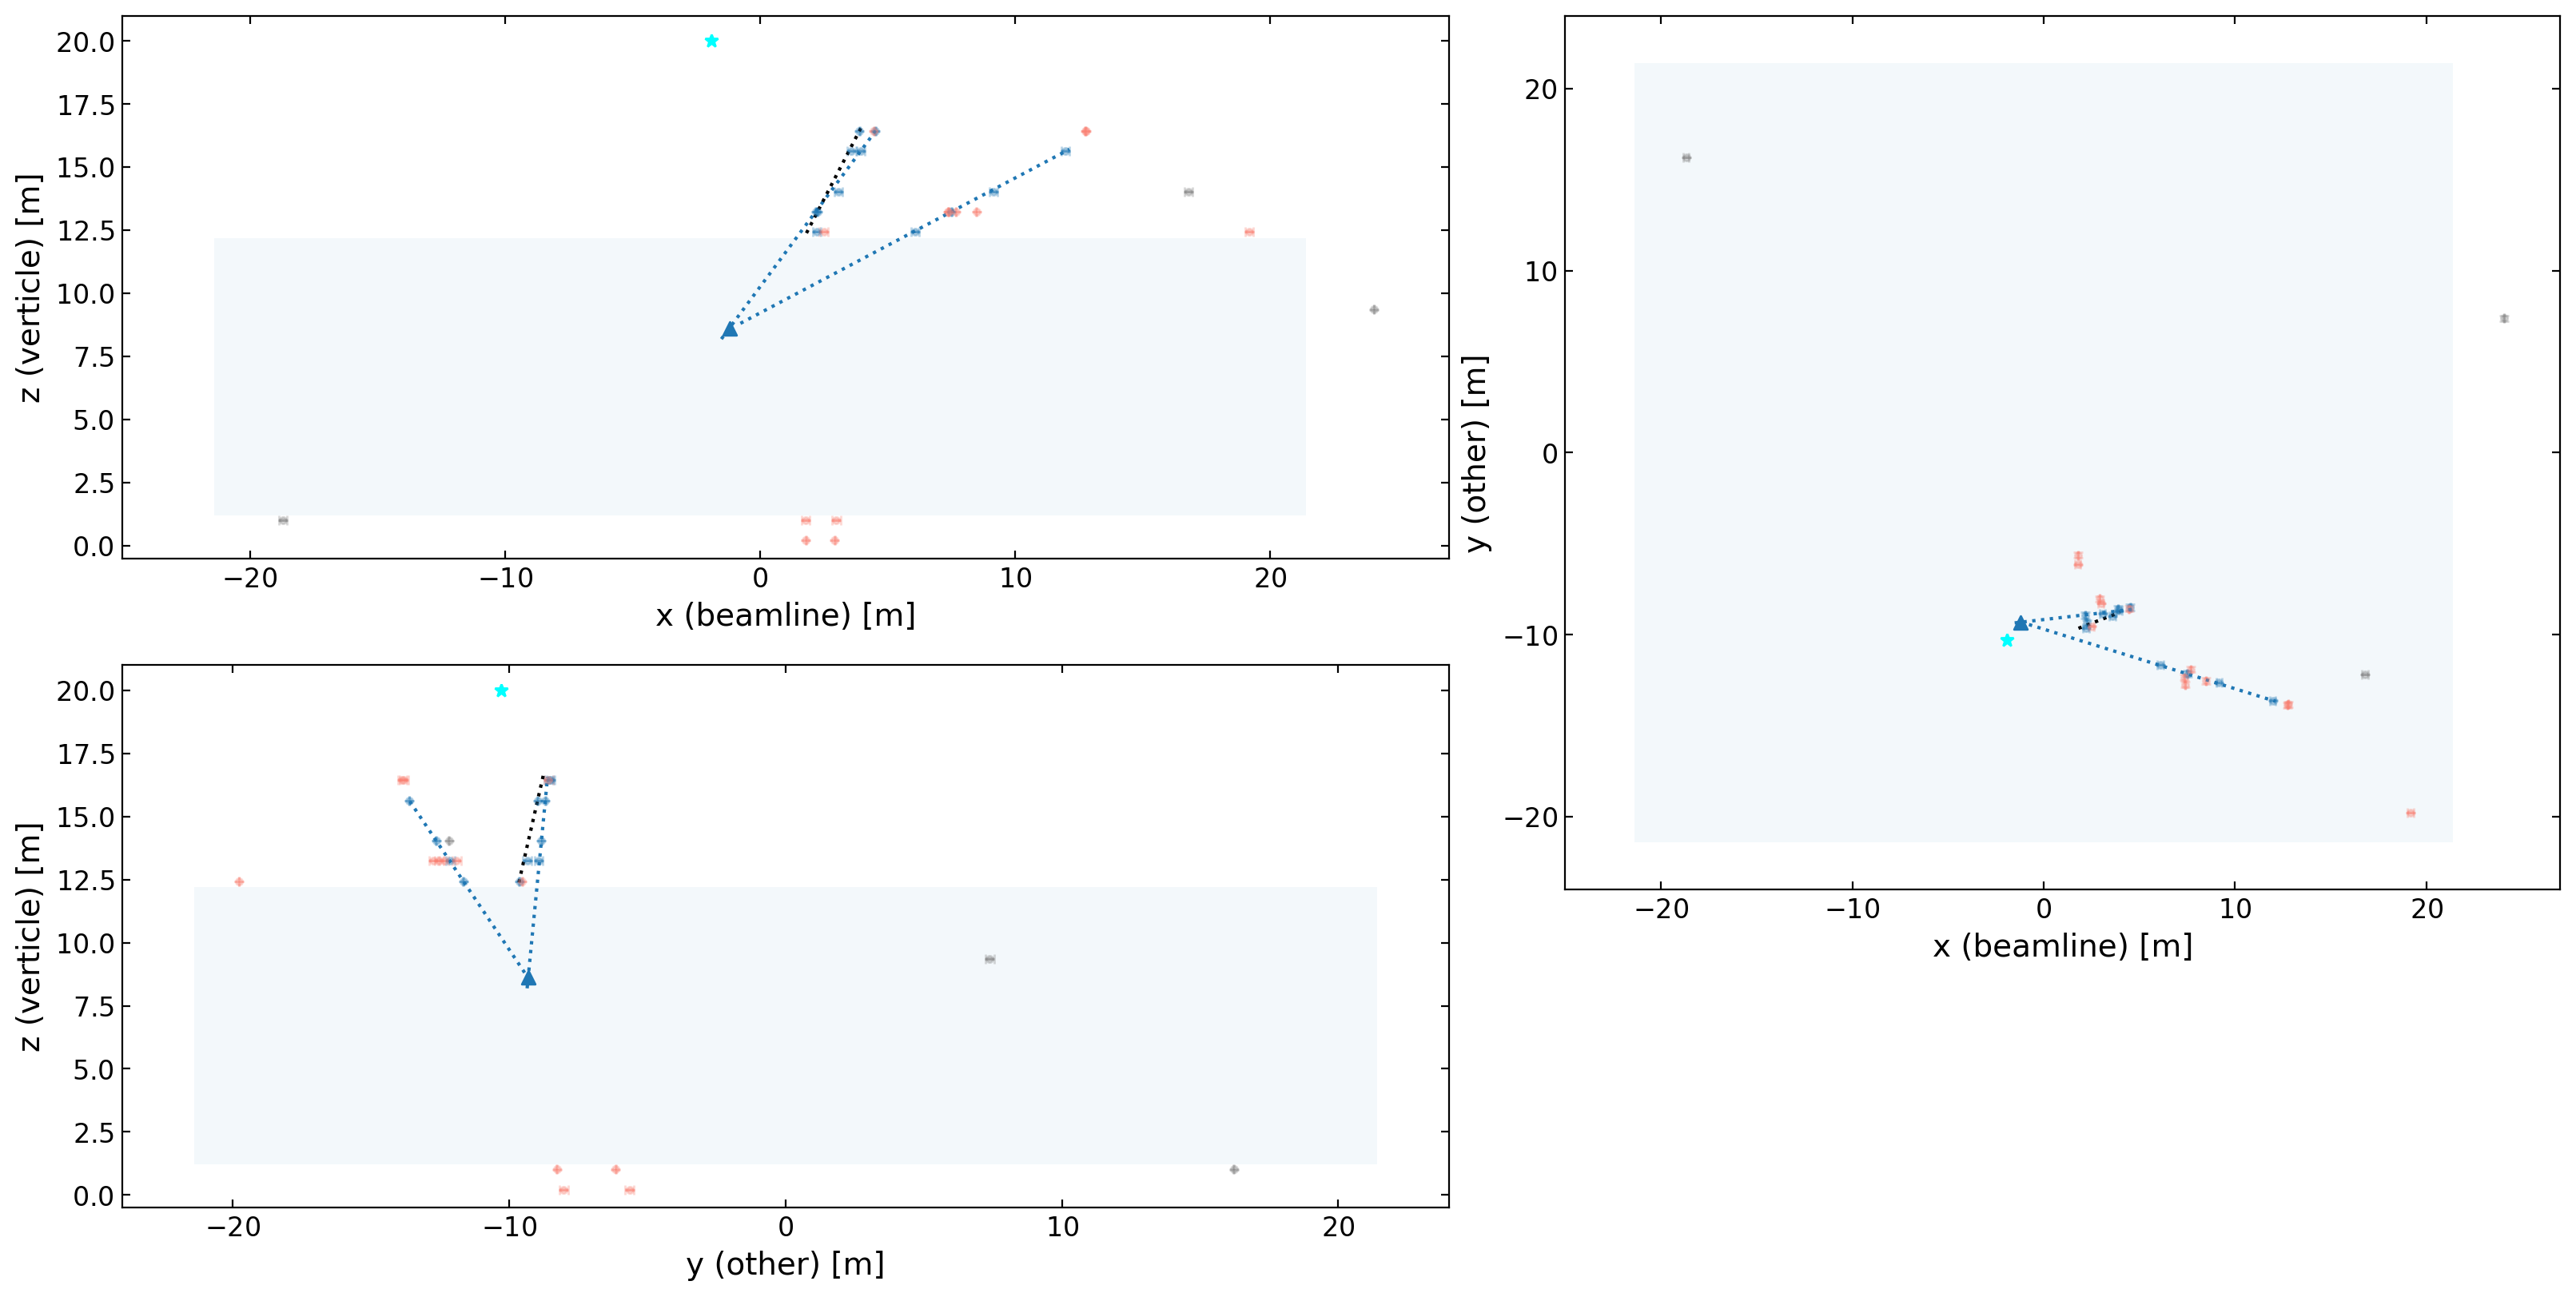

3 90506
8
[20948.094 -4888.287  6621.604   -56.402]
0.342920037372185
consistent, inconsistent 15 20


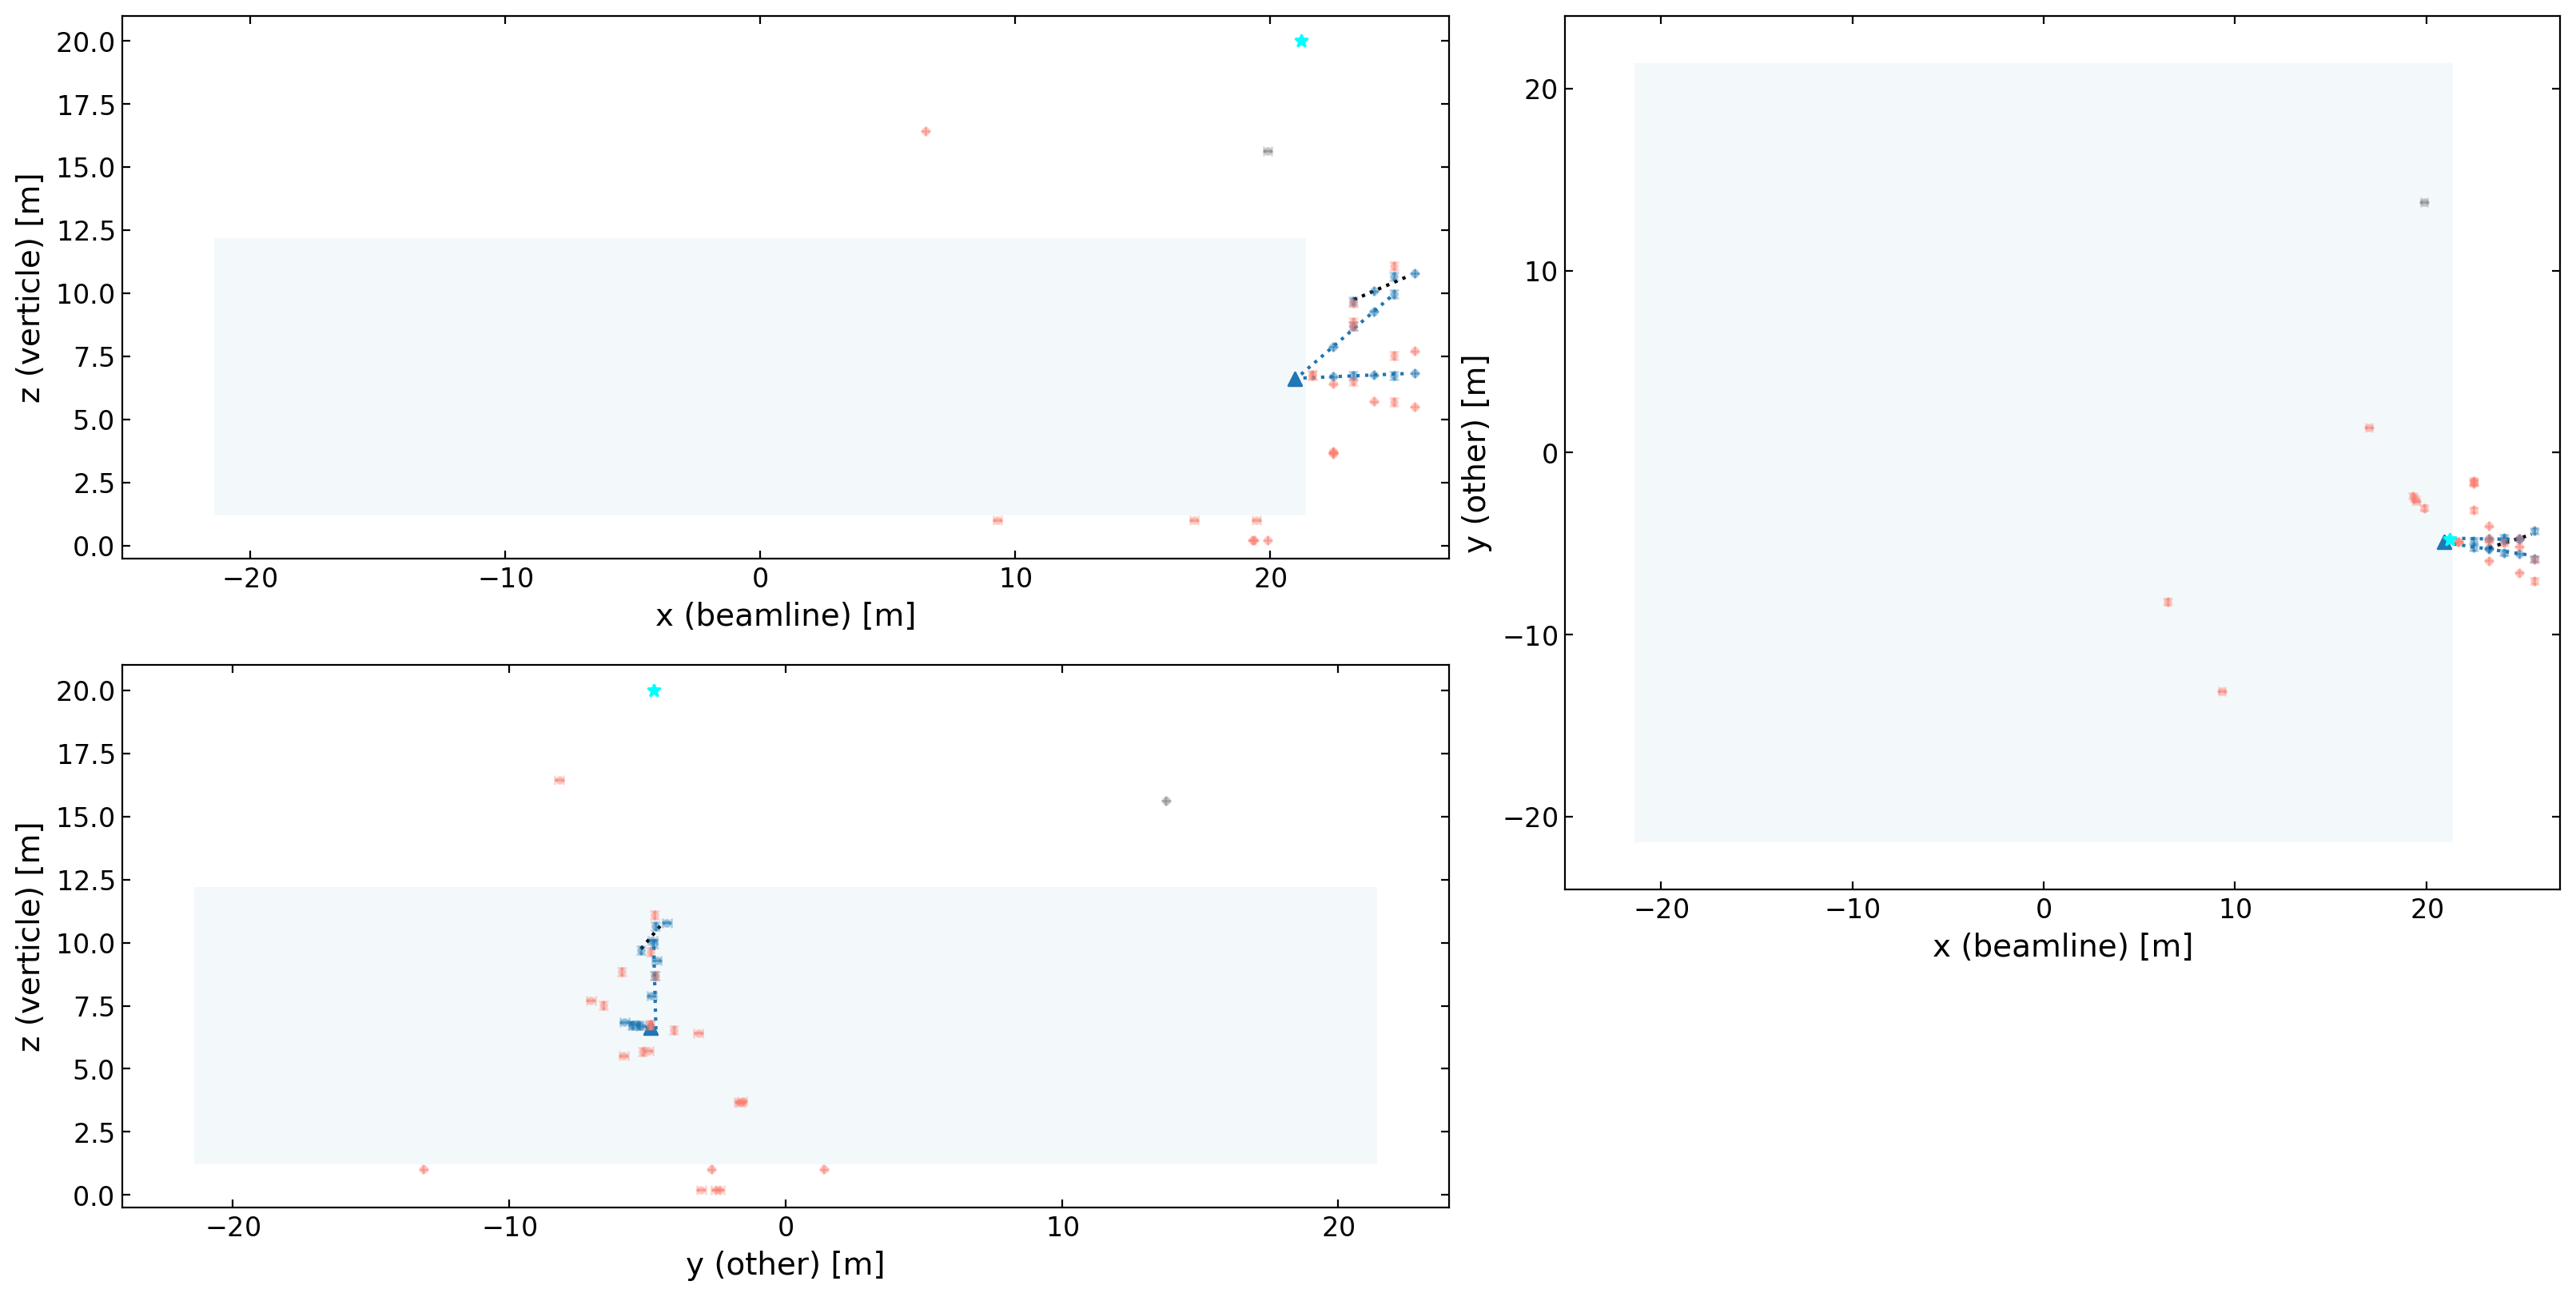

4 120493
4
[  9805.677 -15936.382  10058.769    443.831]
0.46856625638984084
consistent, inconsistent 16 18


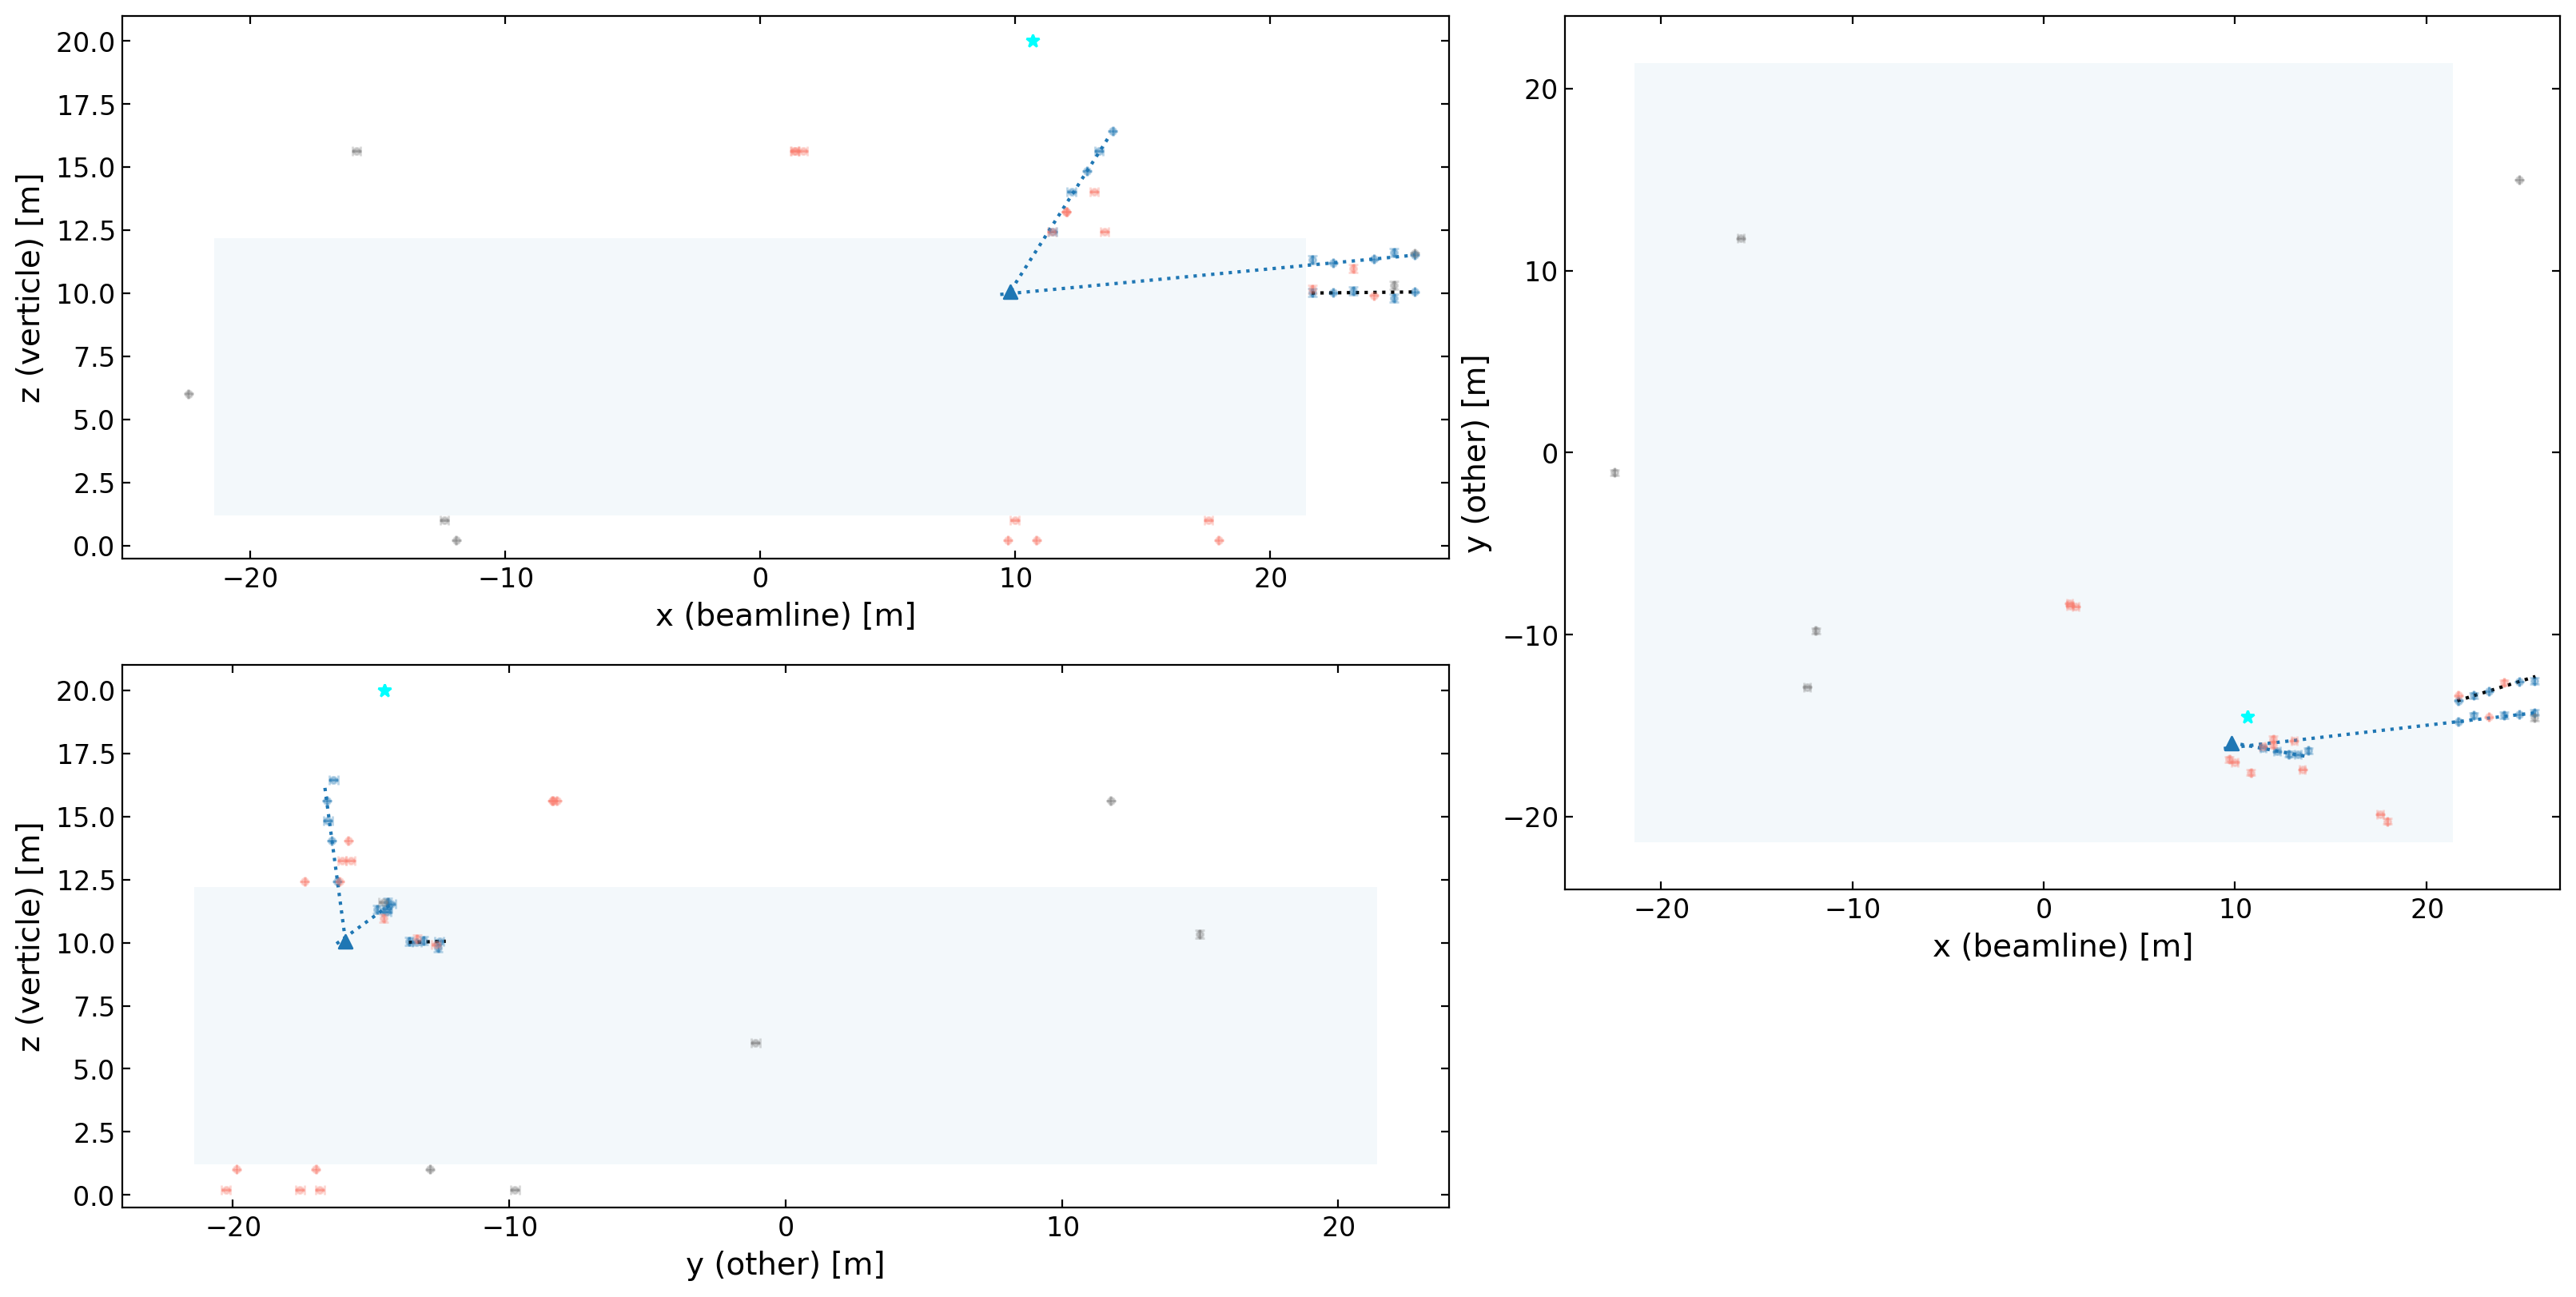

5 237210
3
[-19544.807  15930.827   2503.852    111.111]
0.2923533074065546
consistent, inconsistent 23 12


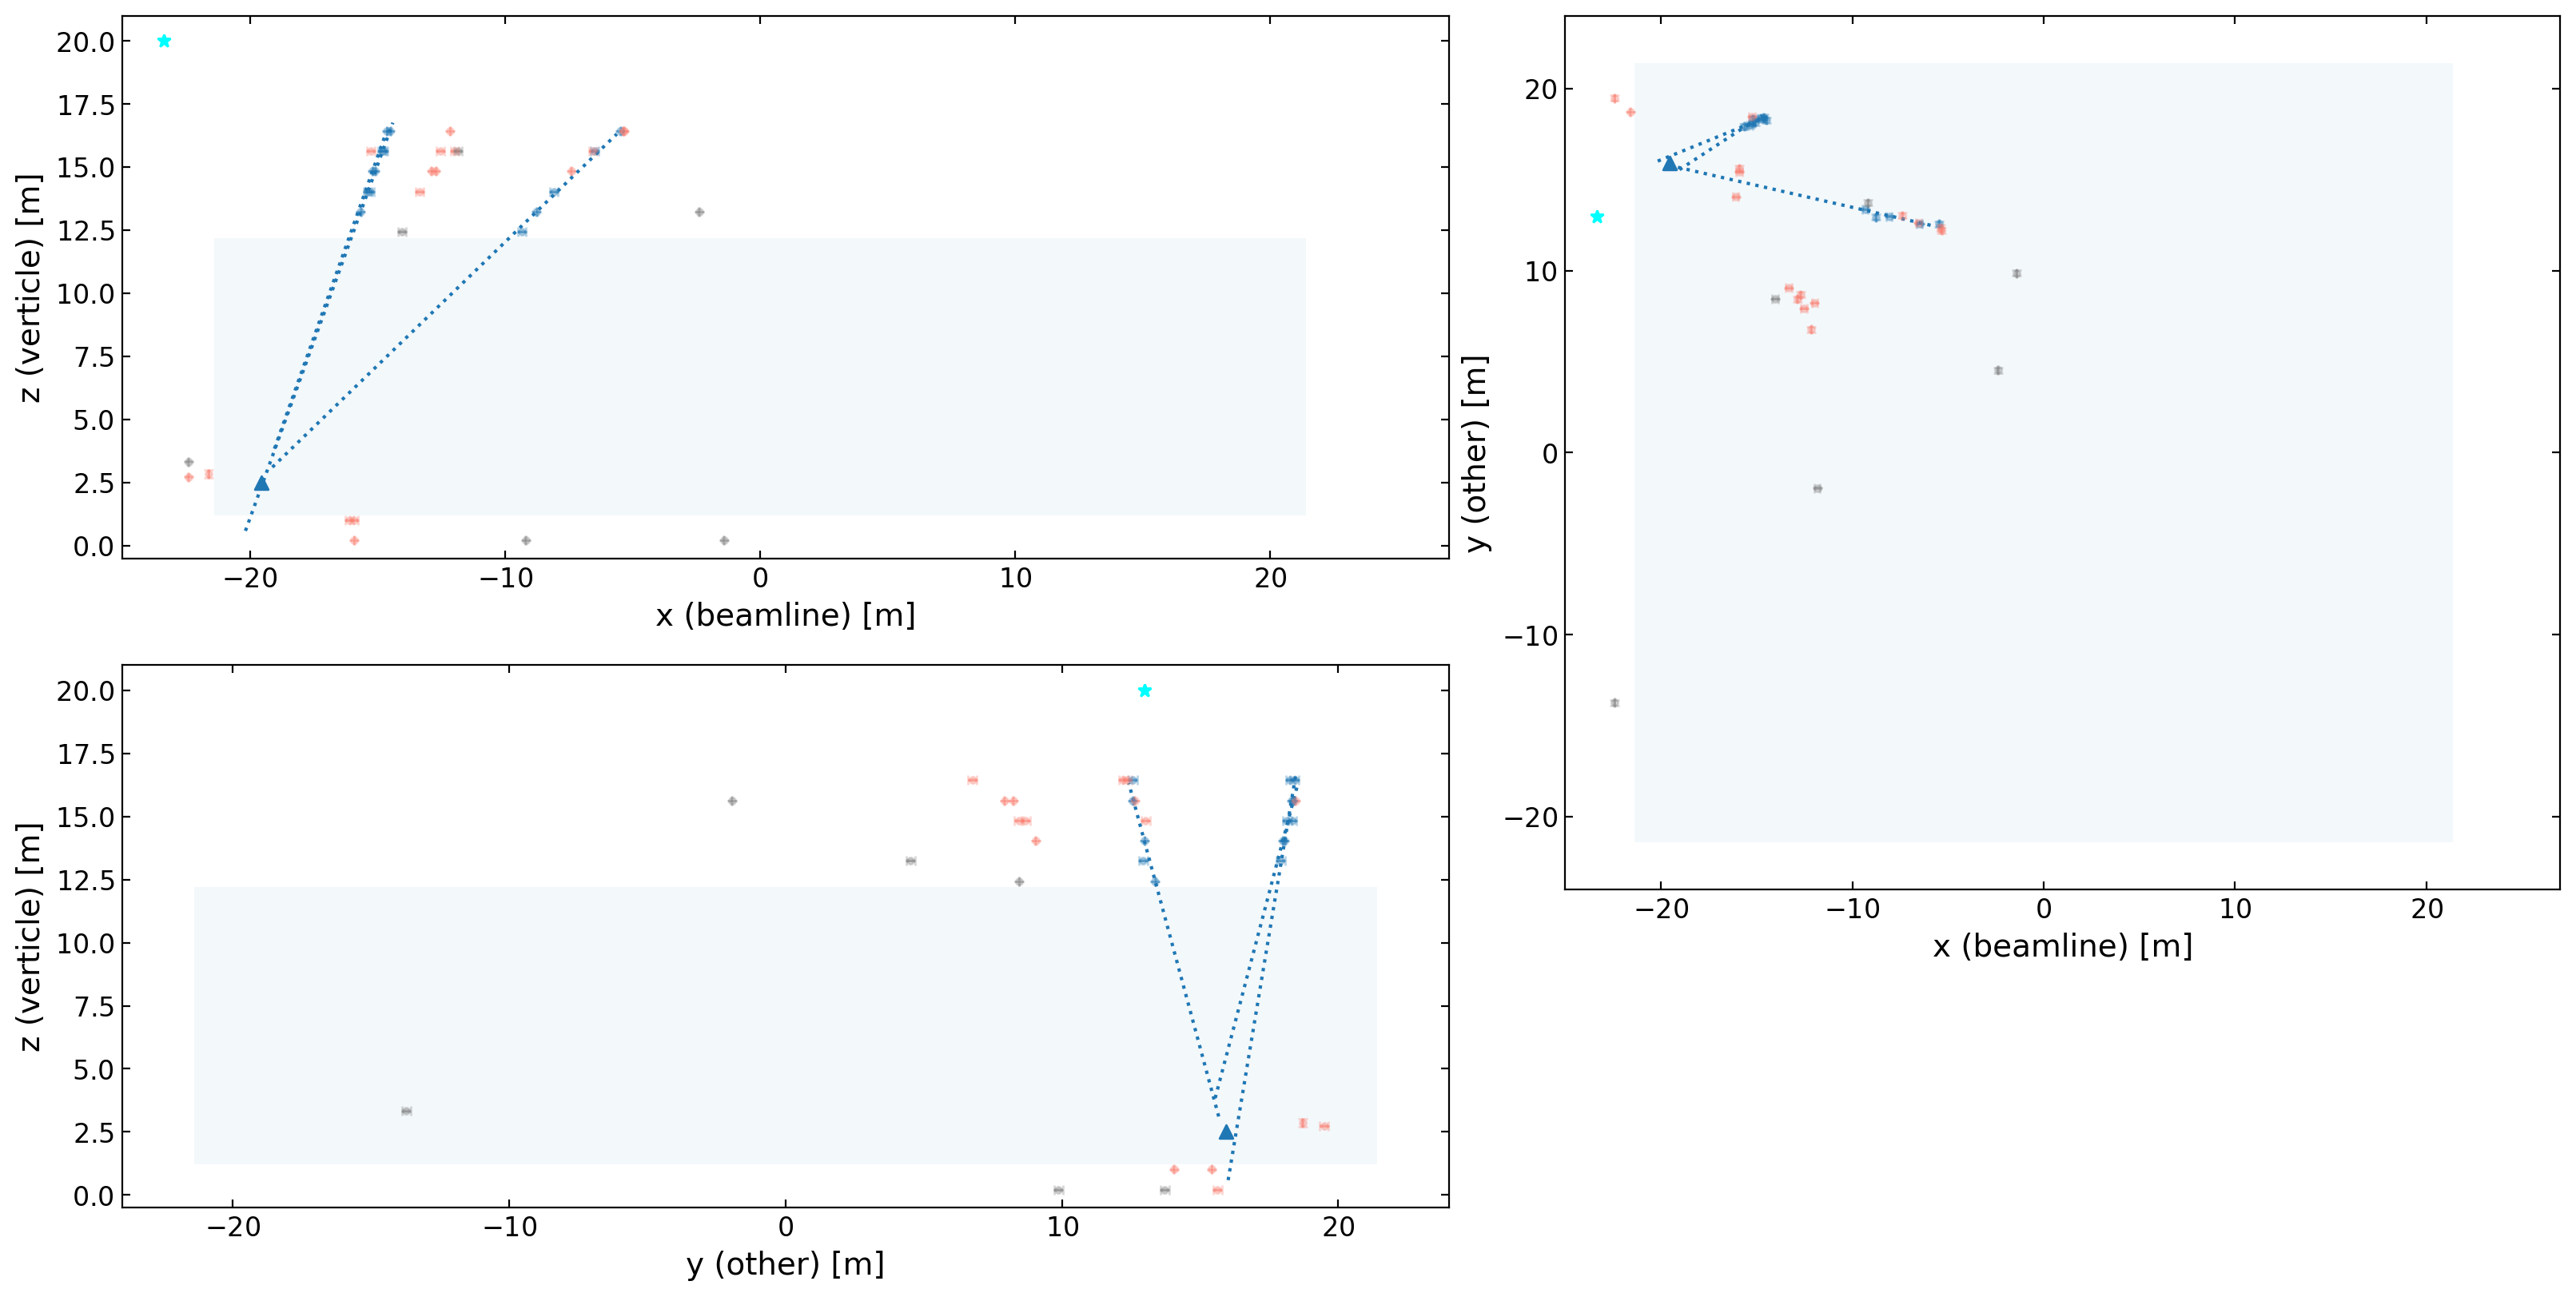

6 526927
1
[-11979.751   9140.52    2422.796    815.963]
0.3842295032275917
consistent, inconsistent 26 26


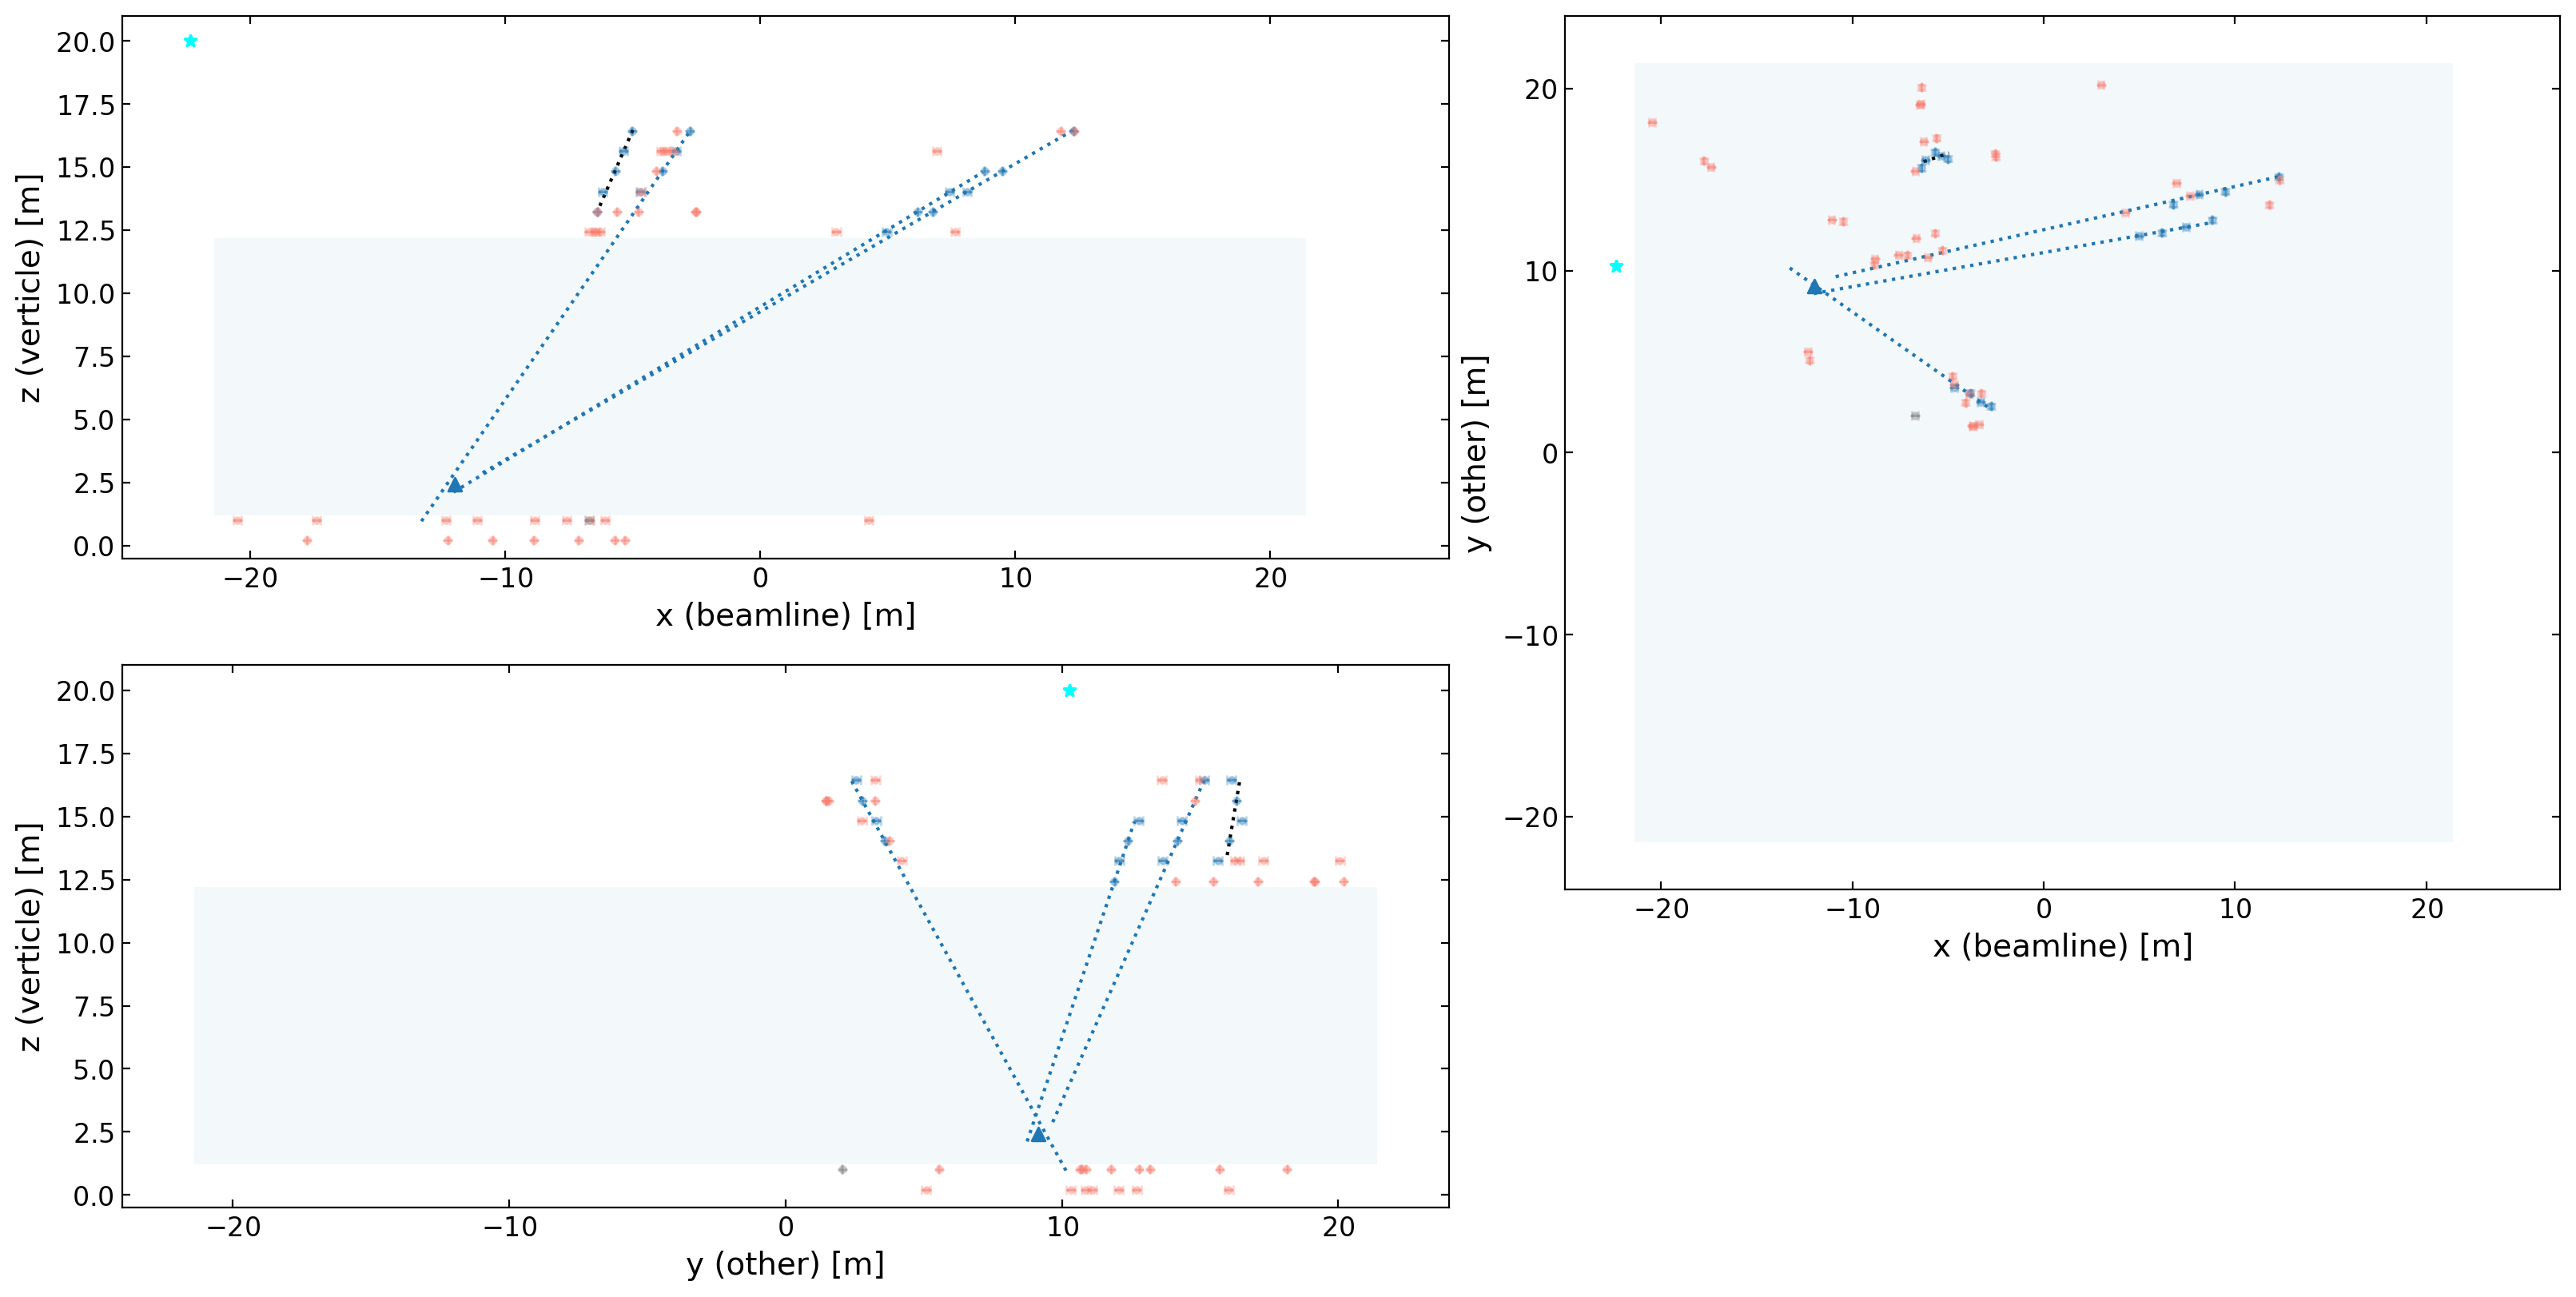

7 592217
2
[   261.821 -13073.489   2813.712    390.968]
0.3880033831400294
consistent, inconsistent 18 26


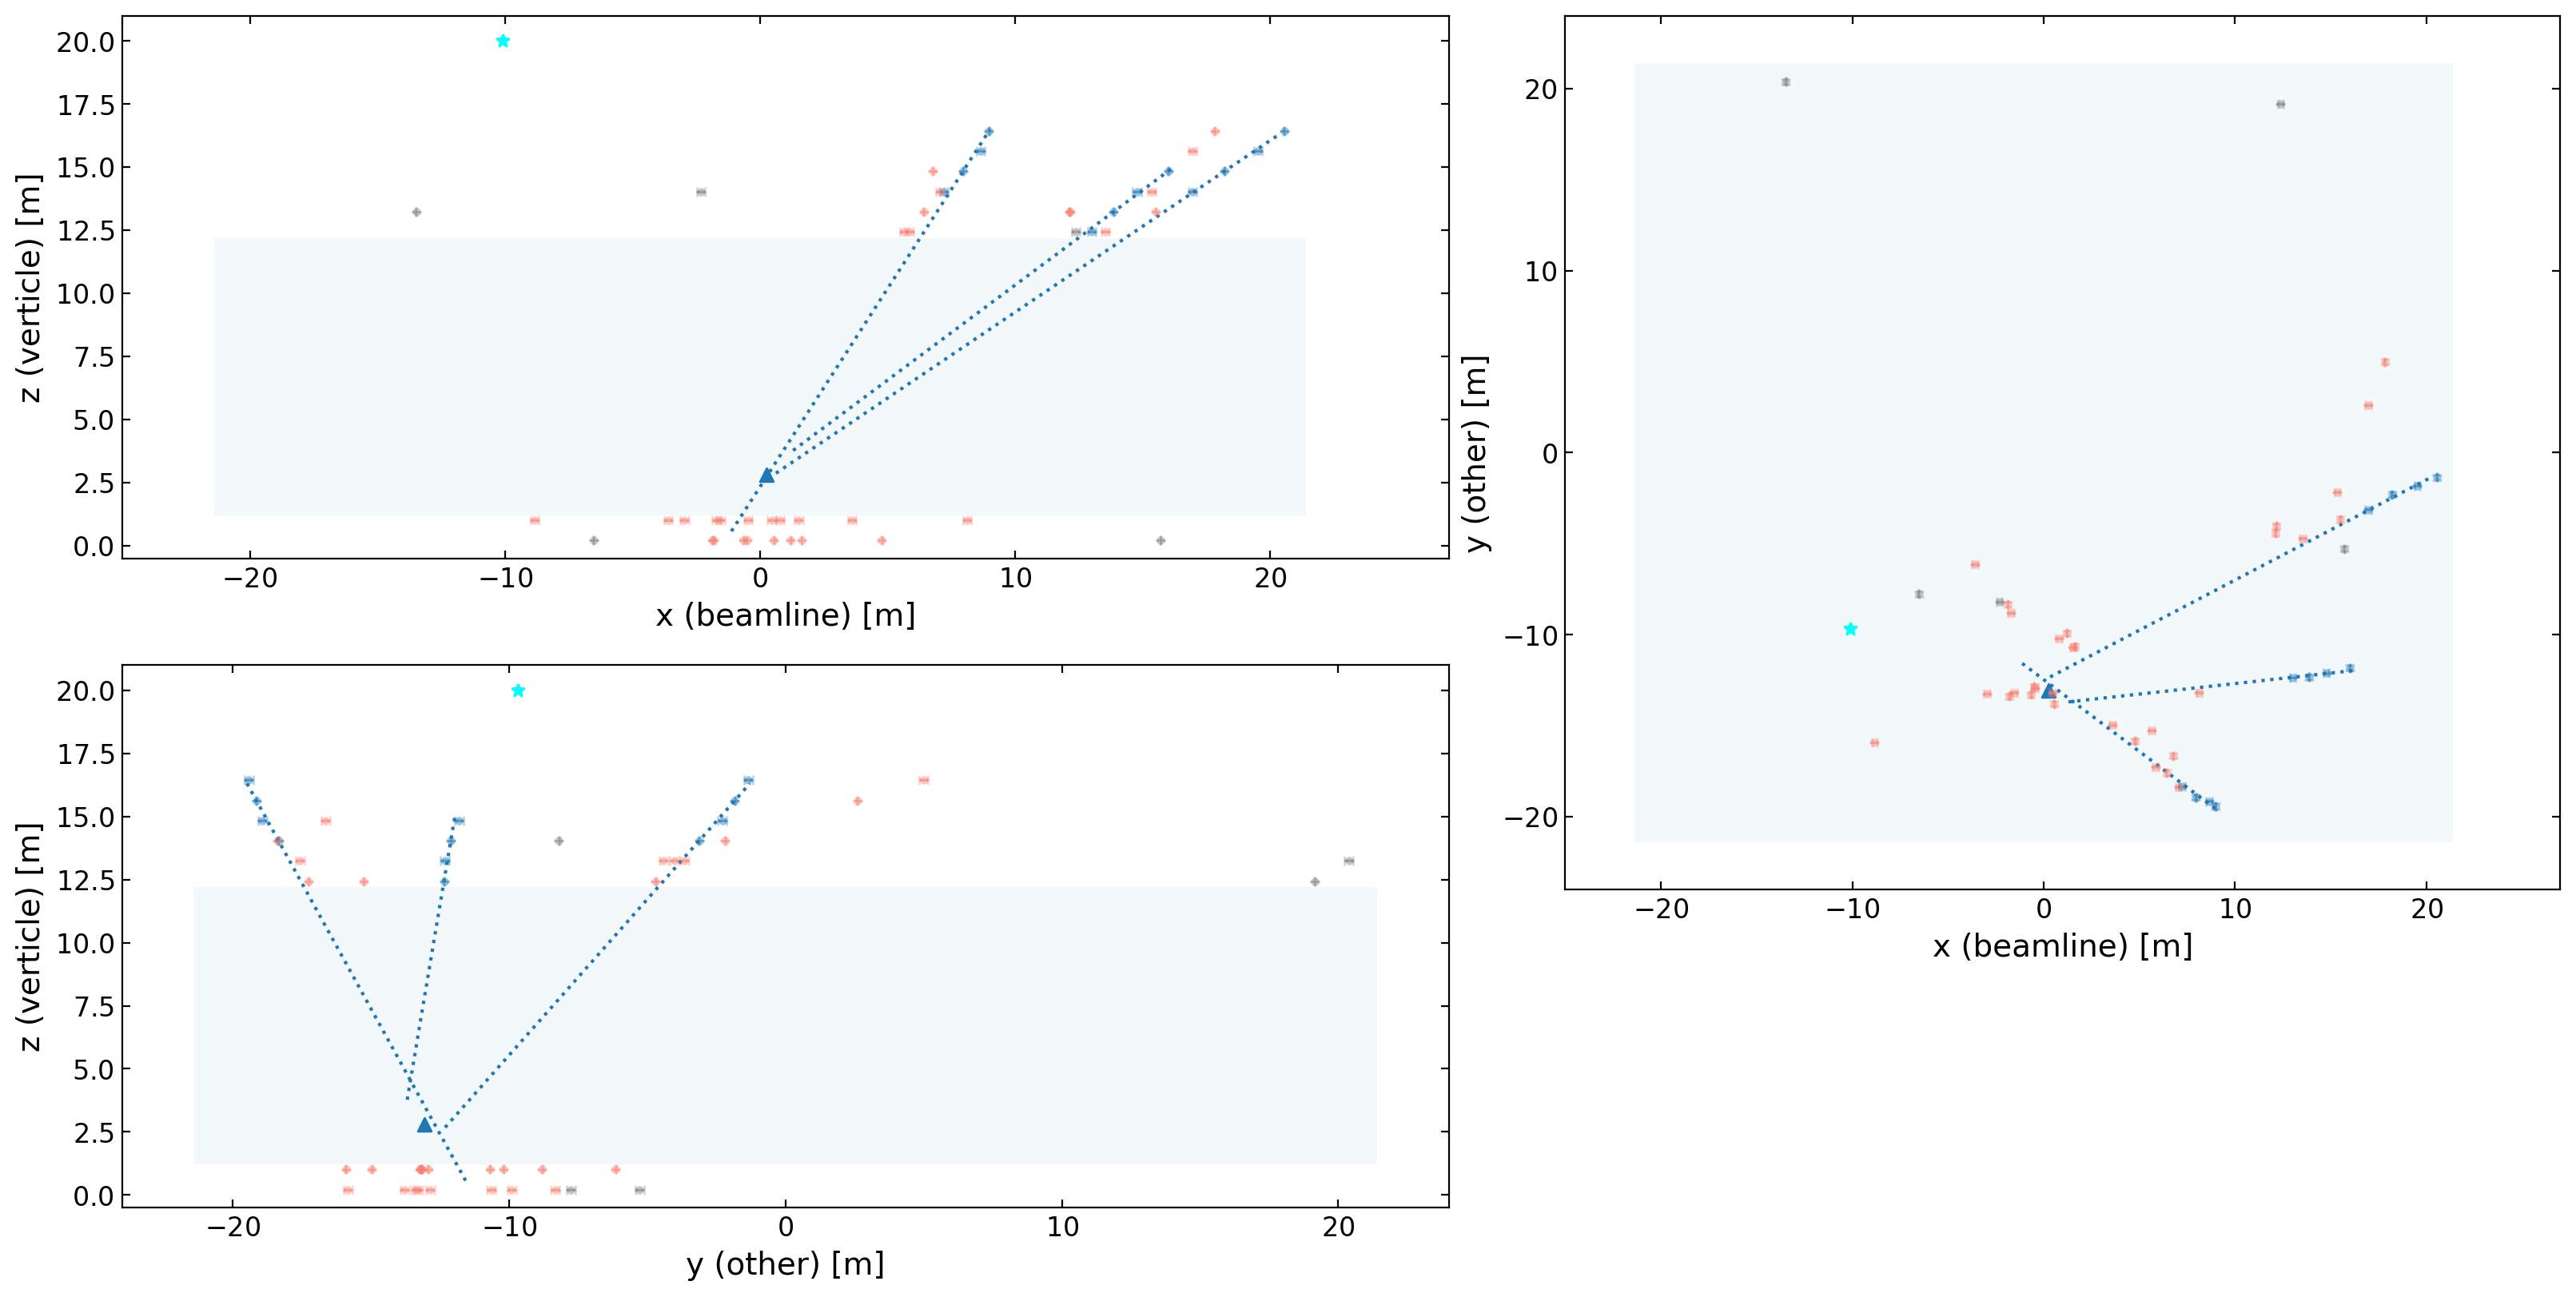

8 599636
3
[-13029.06    9532.321   3886.814    928.737]
0.4893288647632791
consistent, inconsistent 19 18


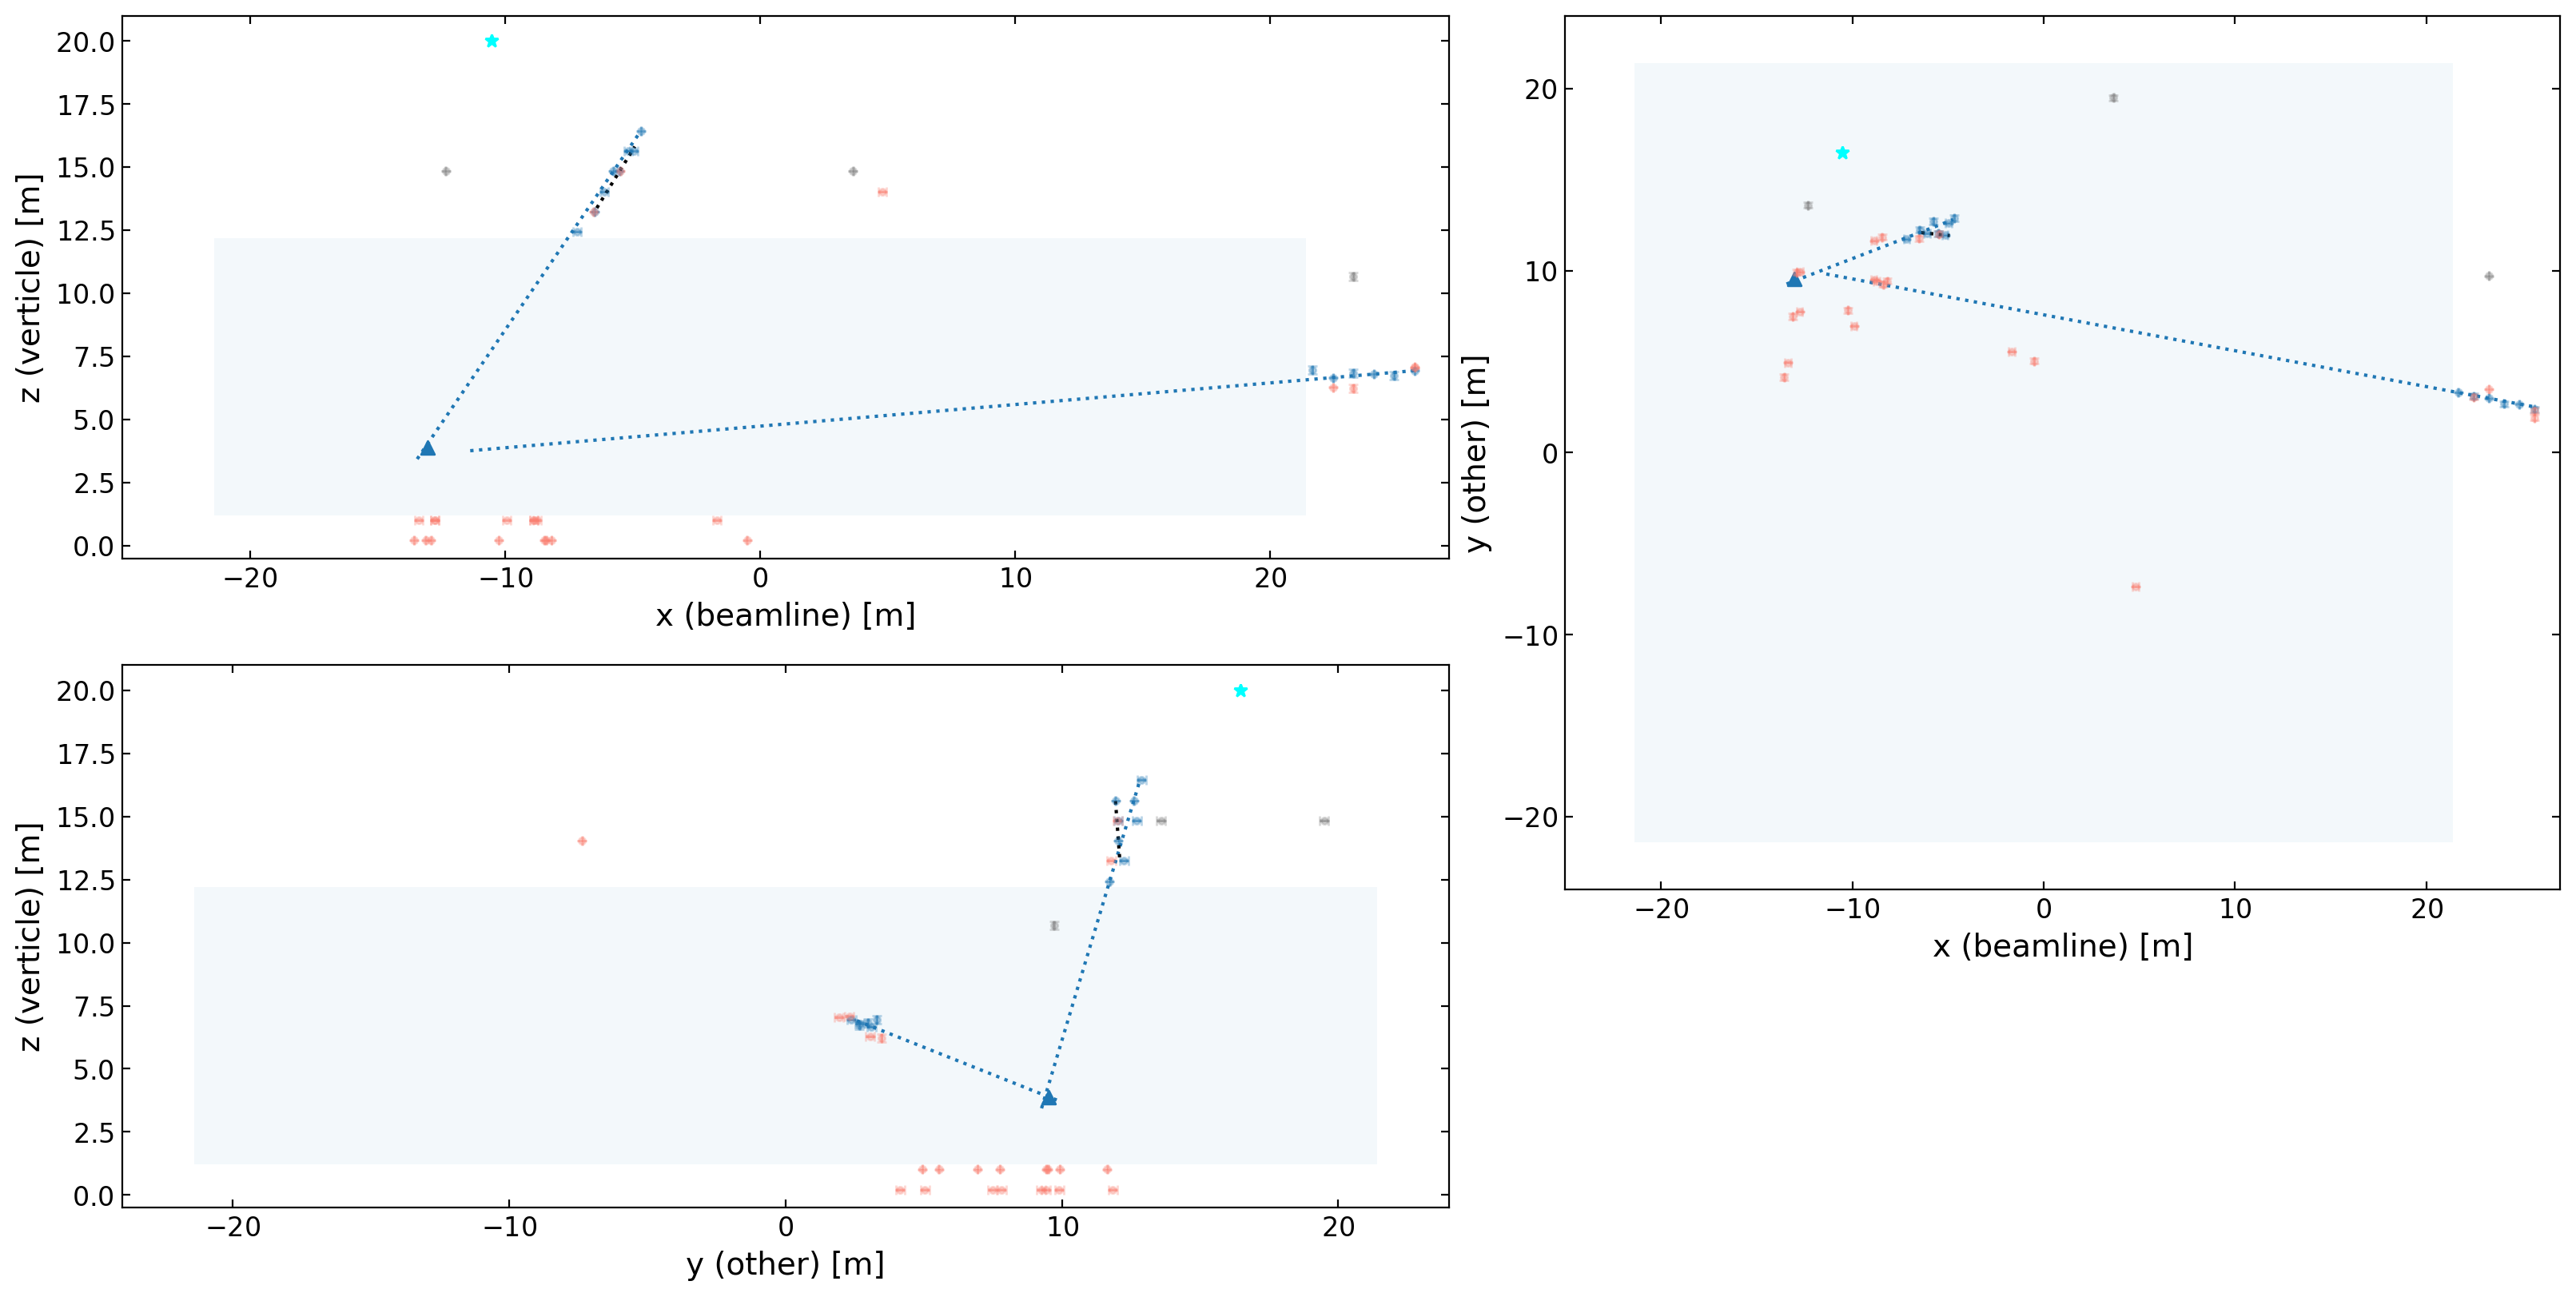

9 716520
2
[ -6816.1   -16417.506   2984.996    623.554]
0.4081395507345837
consistent, inconsistent 12 13


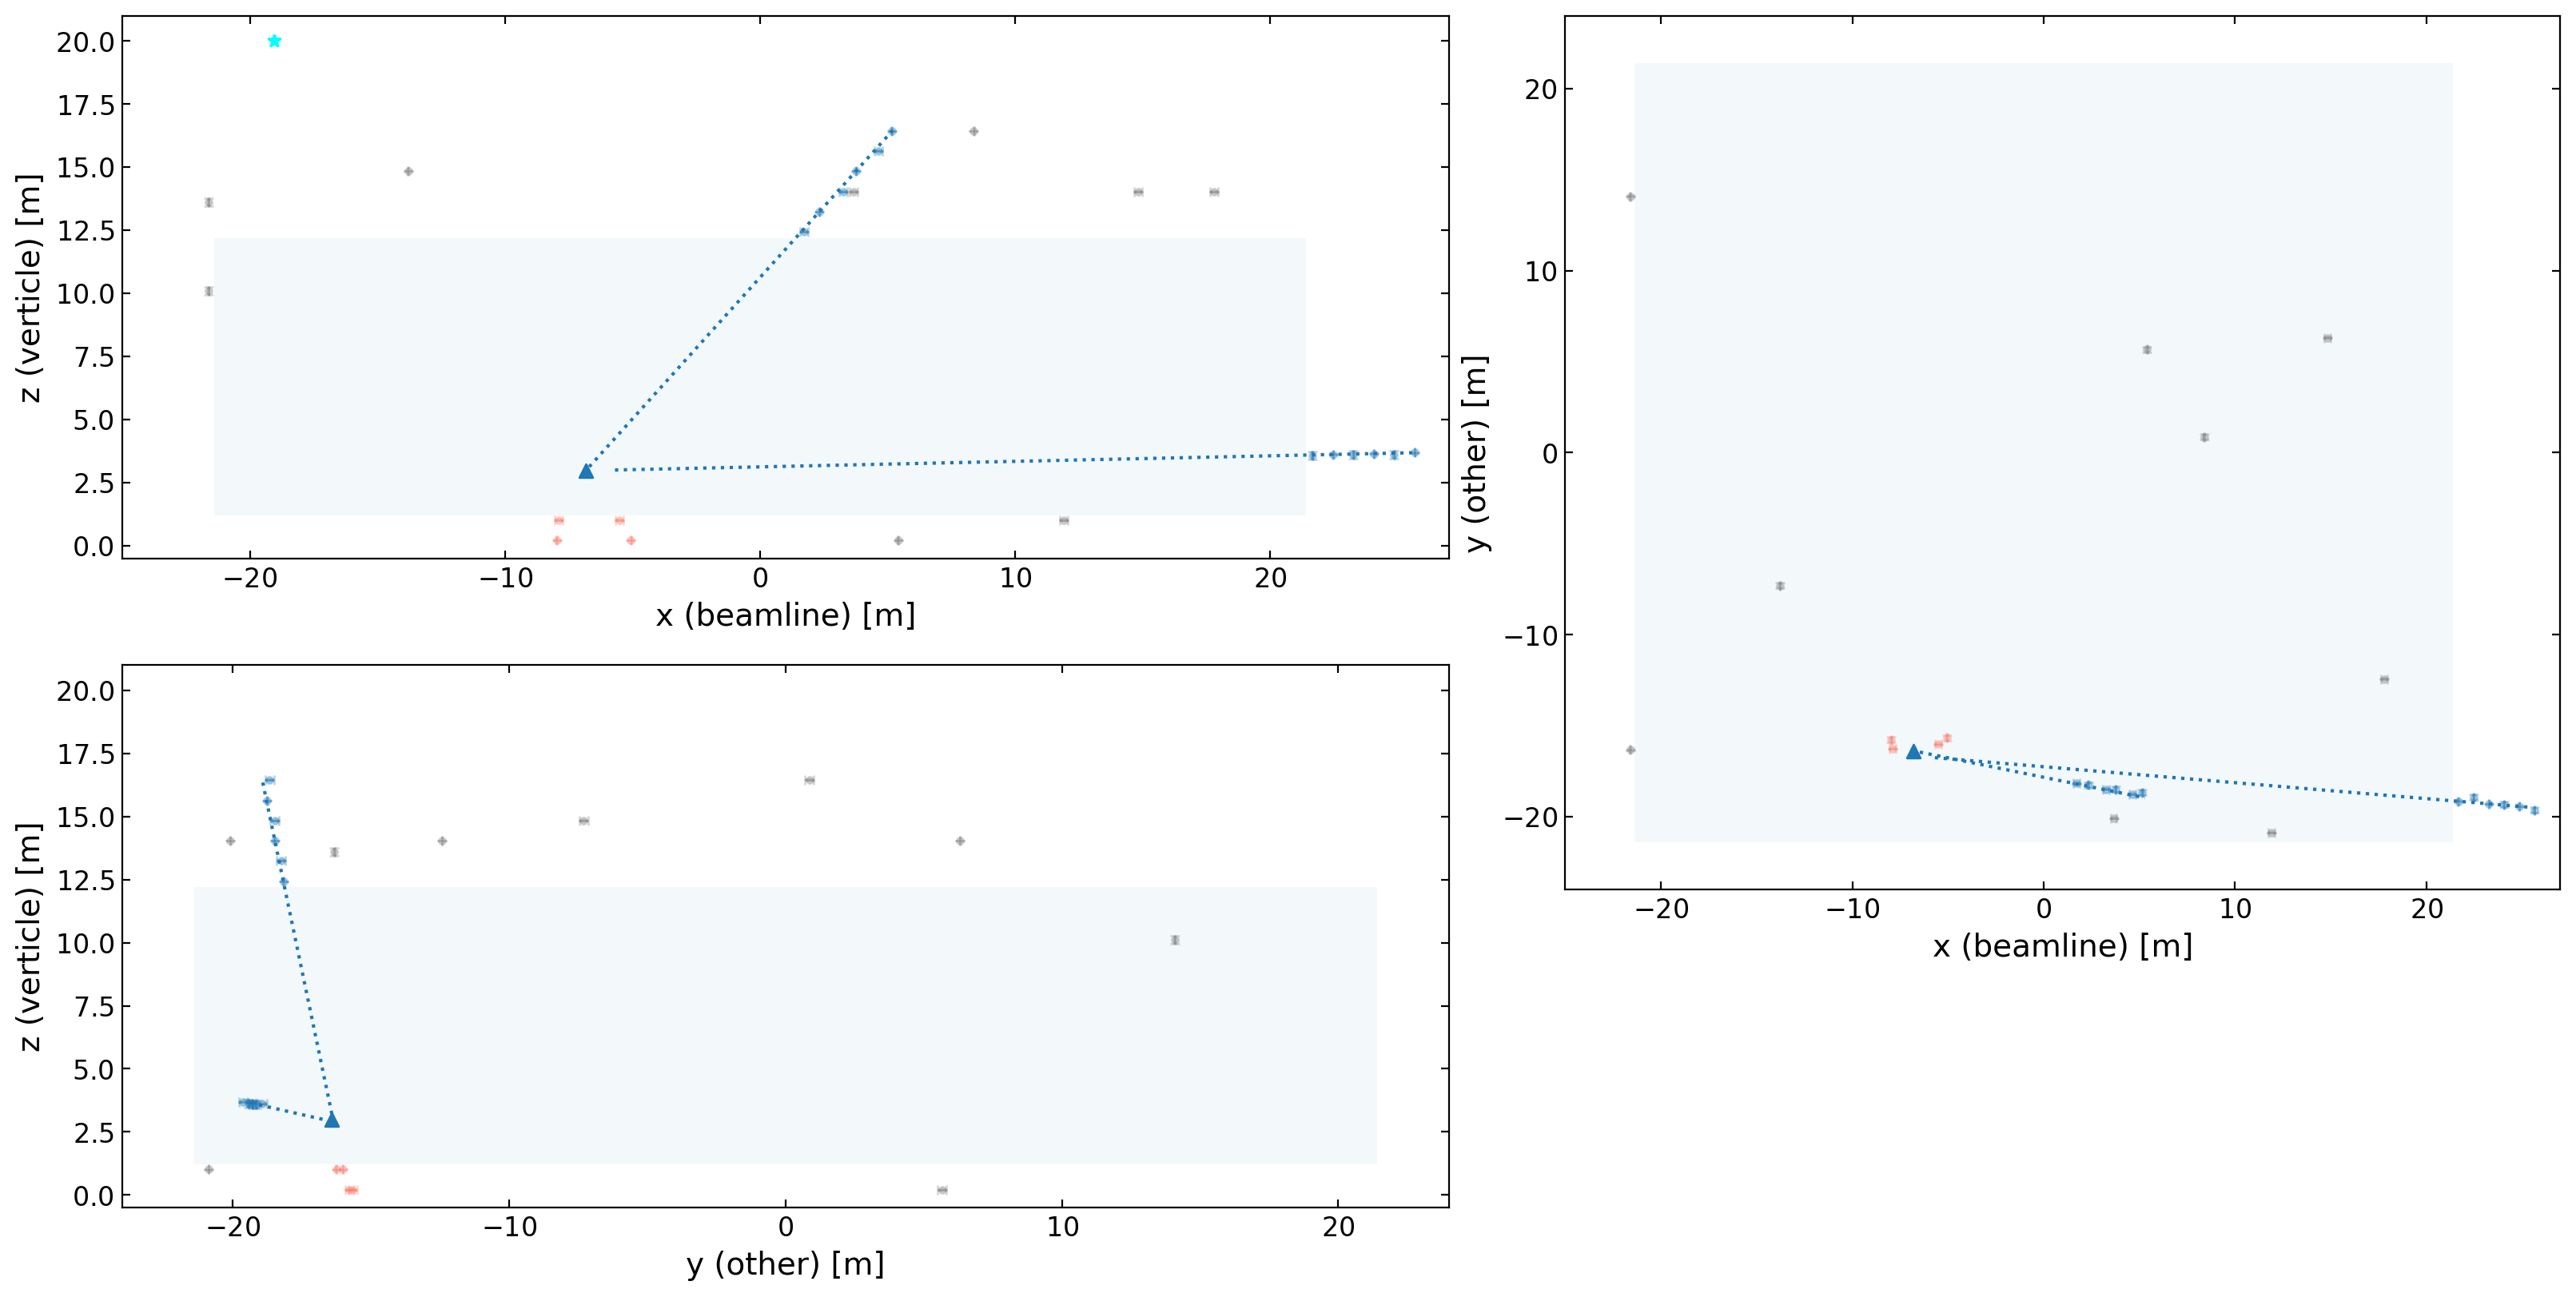

10 734313
3
[-20268.295  18465.141  10314.315   1093.209]
0.16049002701882456
consistent, inconsistent 9 10


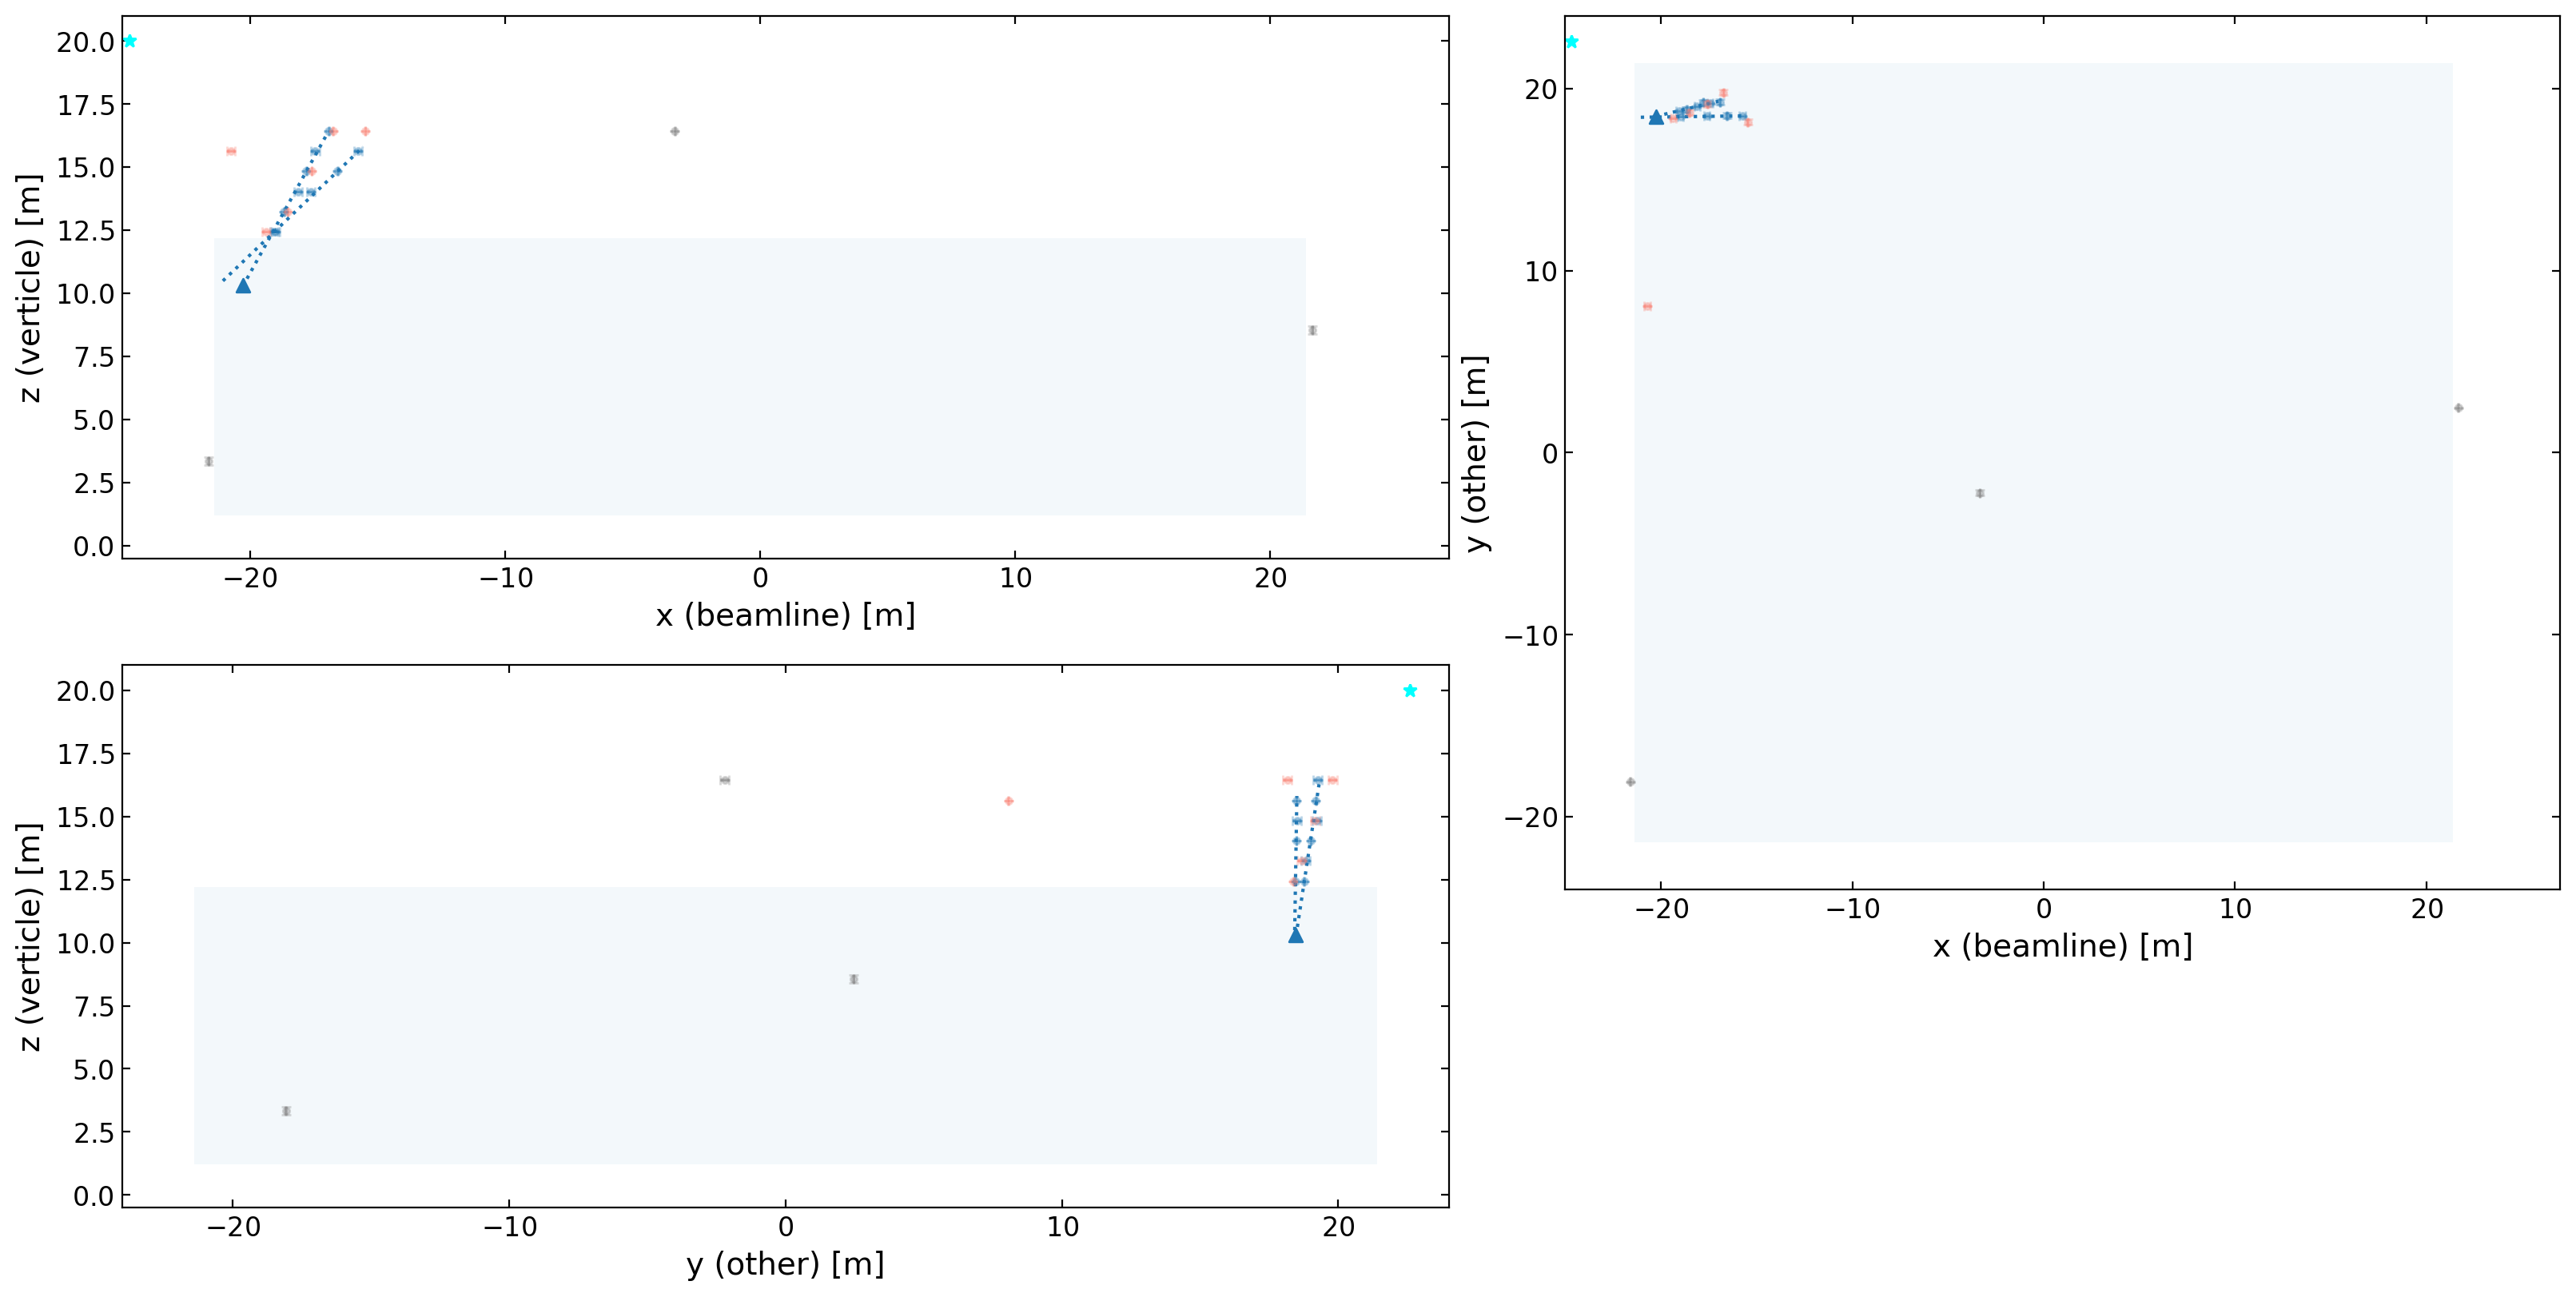

11 789401
7
[ 10262.703 -12239.019   4202.248   1027.369]
0.42956780009168455
consistent, inconsistent 10 22


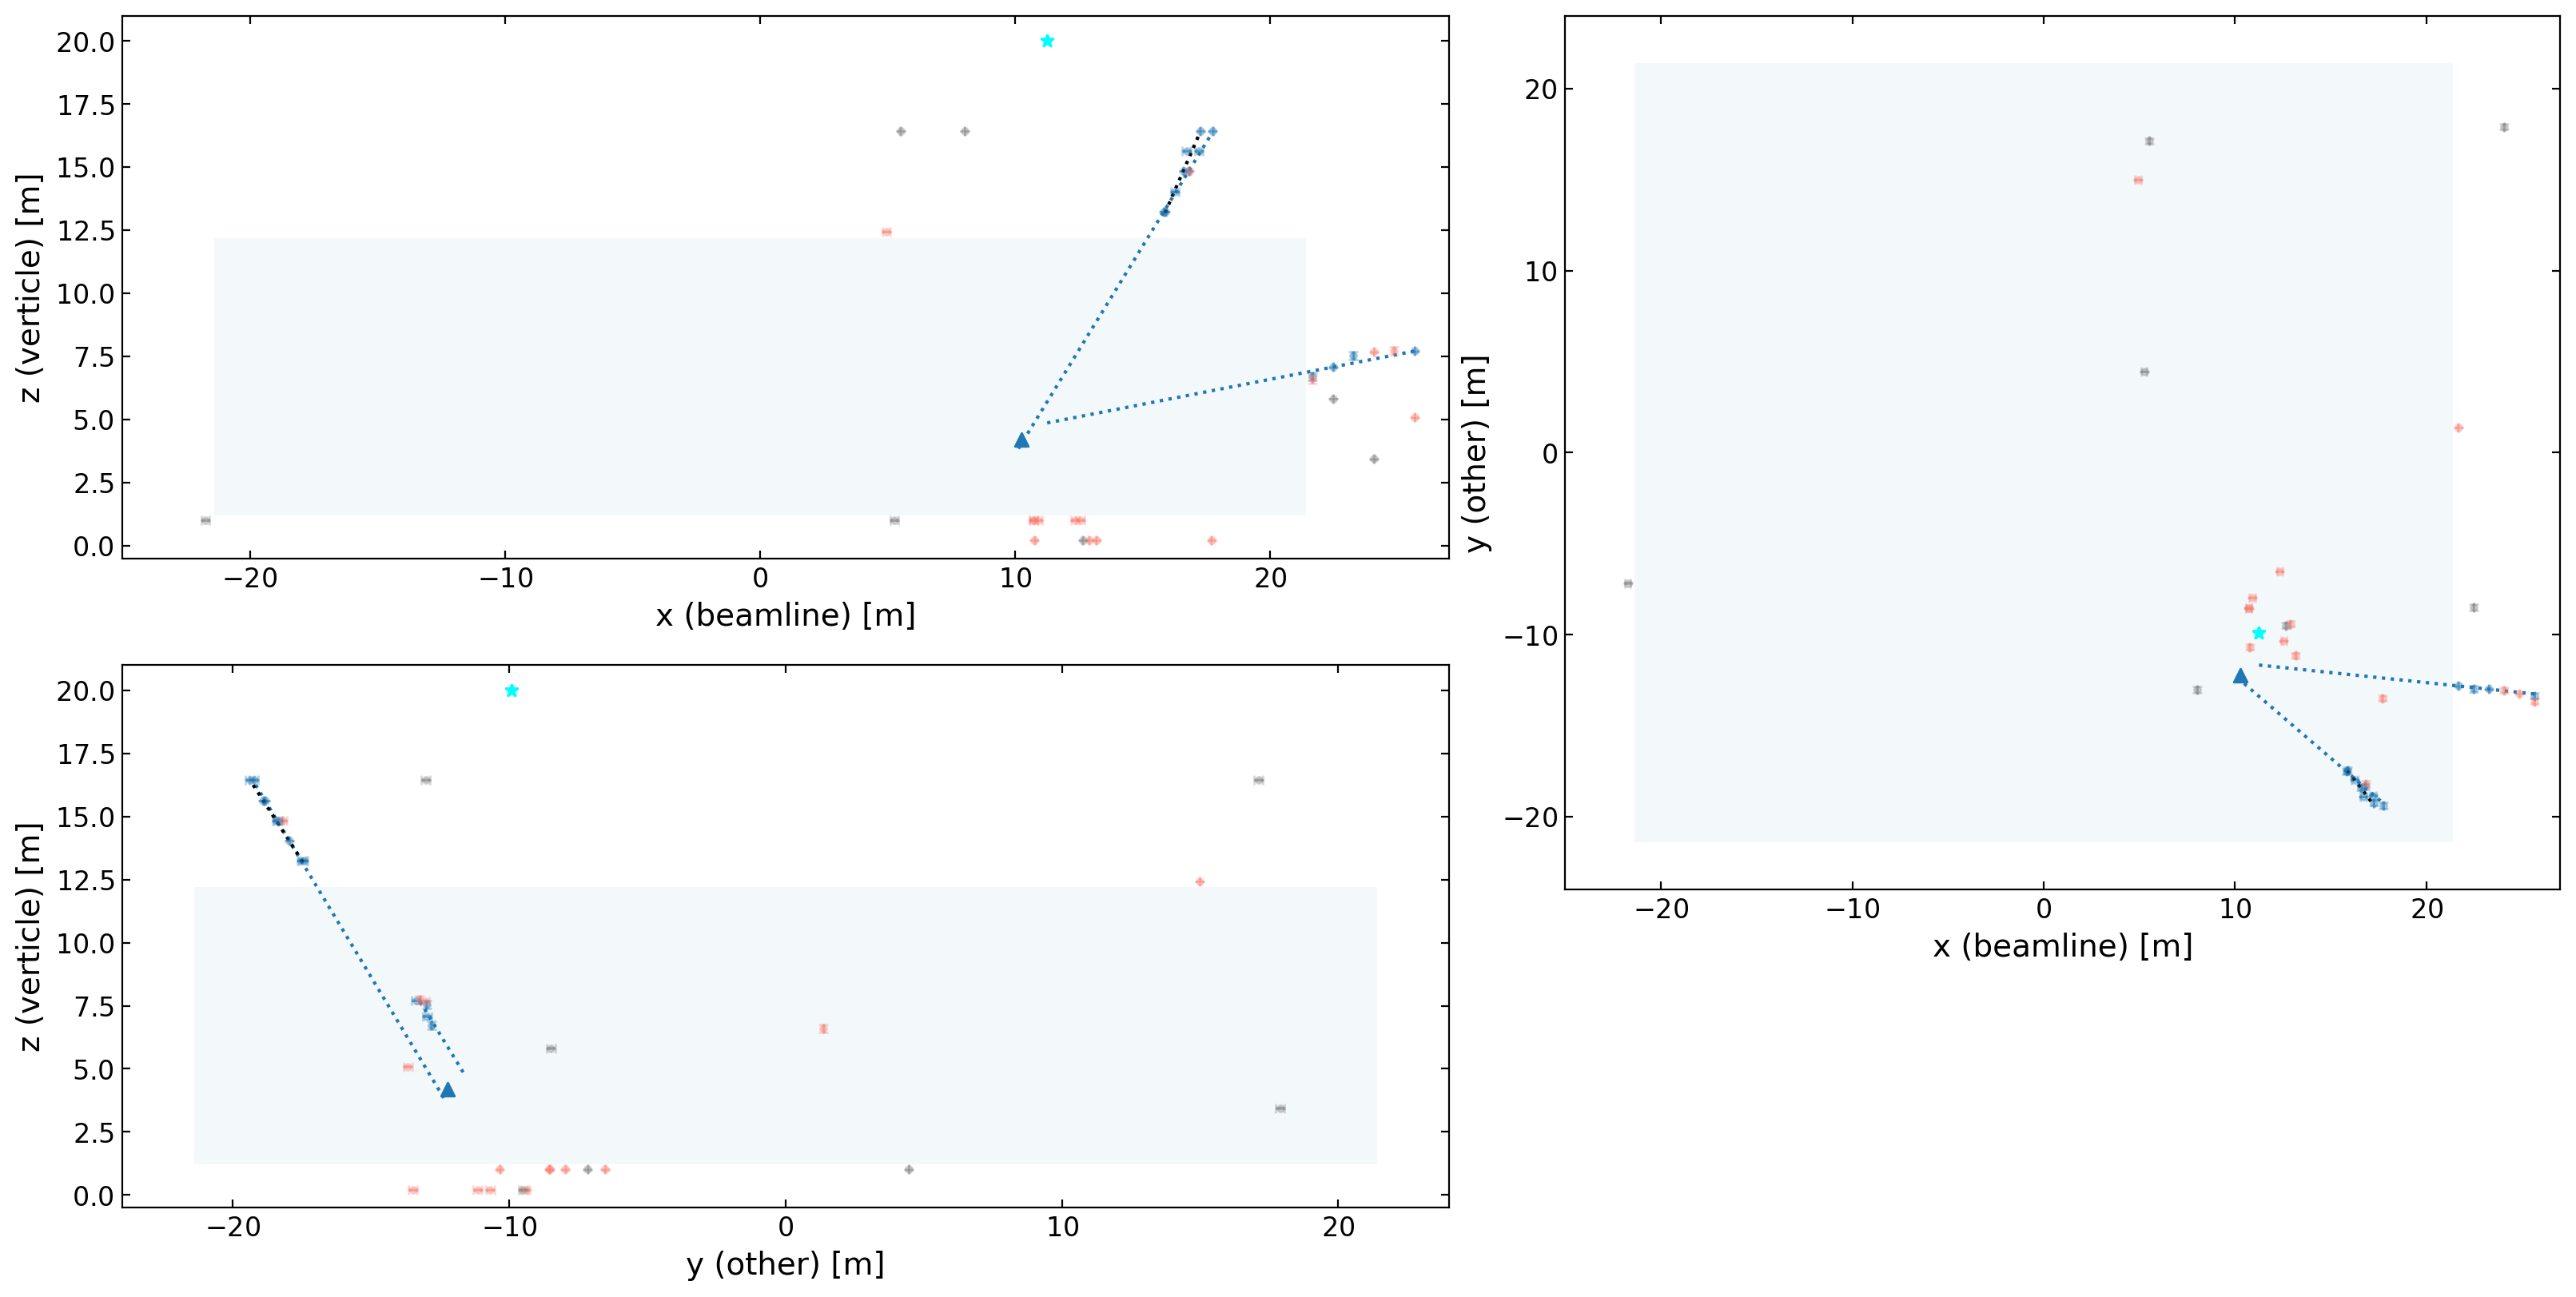

12 791183
2
[-1899.336  -451.79   7484.474   441.413]
0.33496755969155617
consistent, inconsistent 10 21


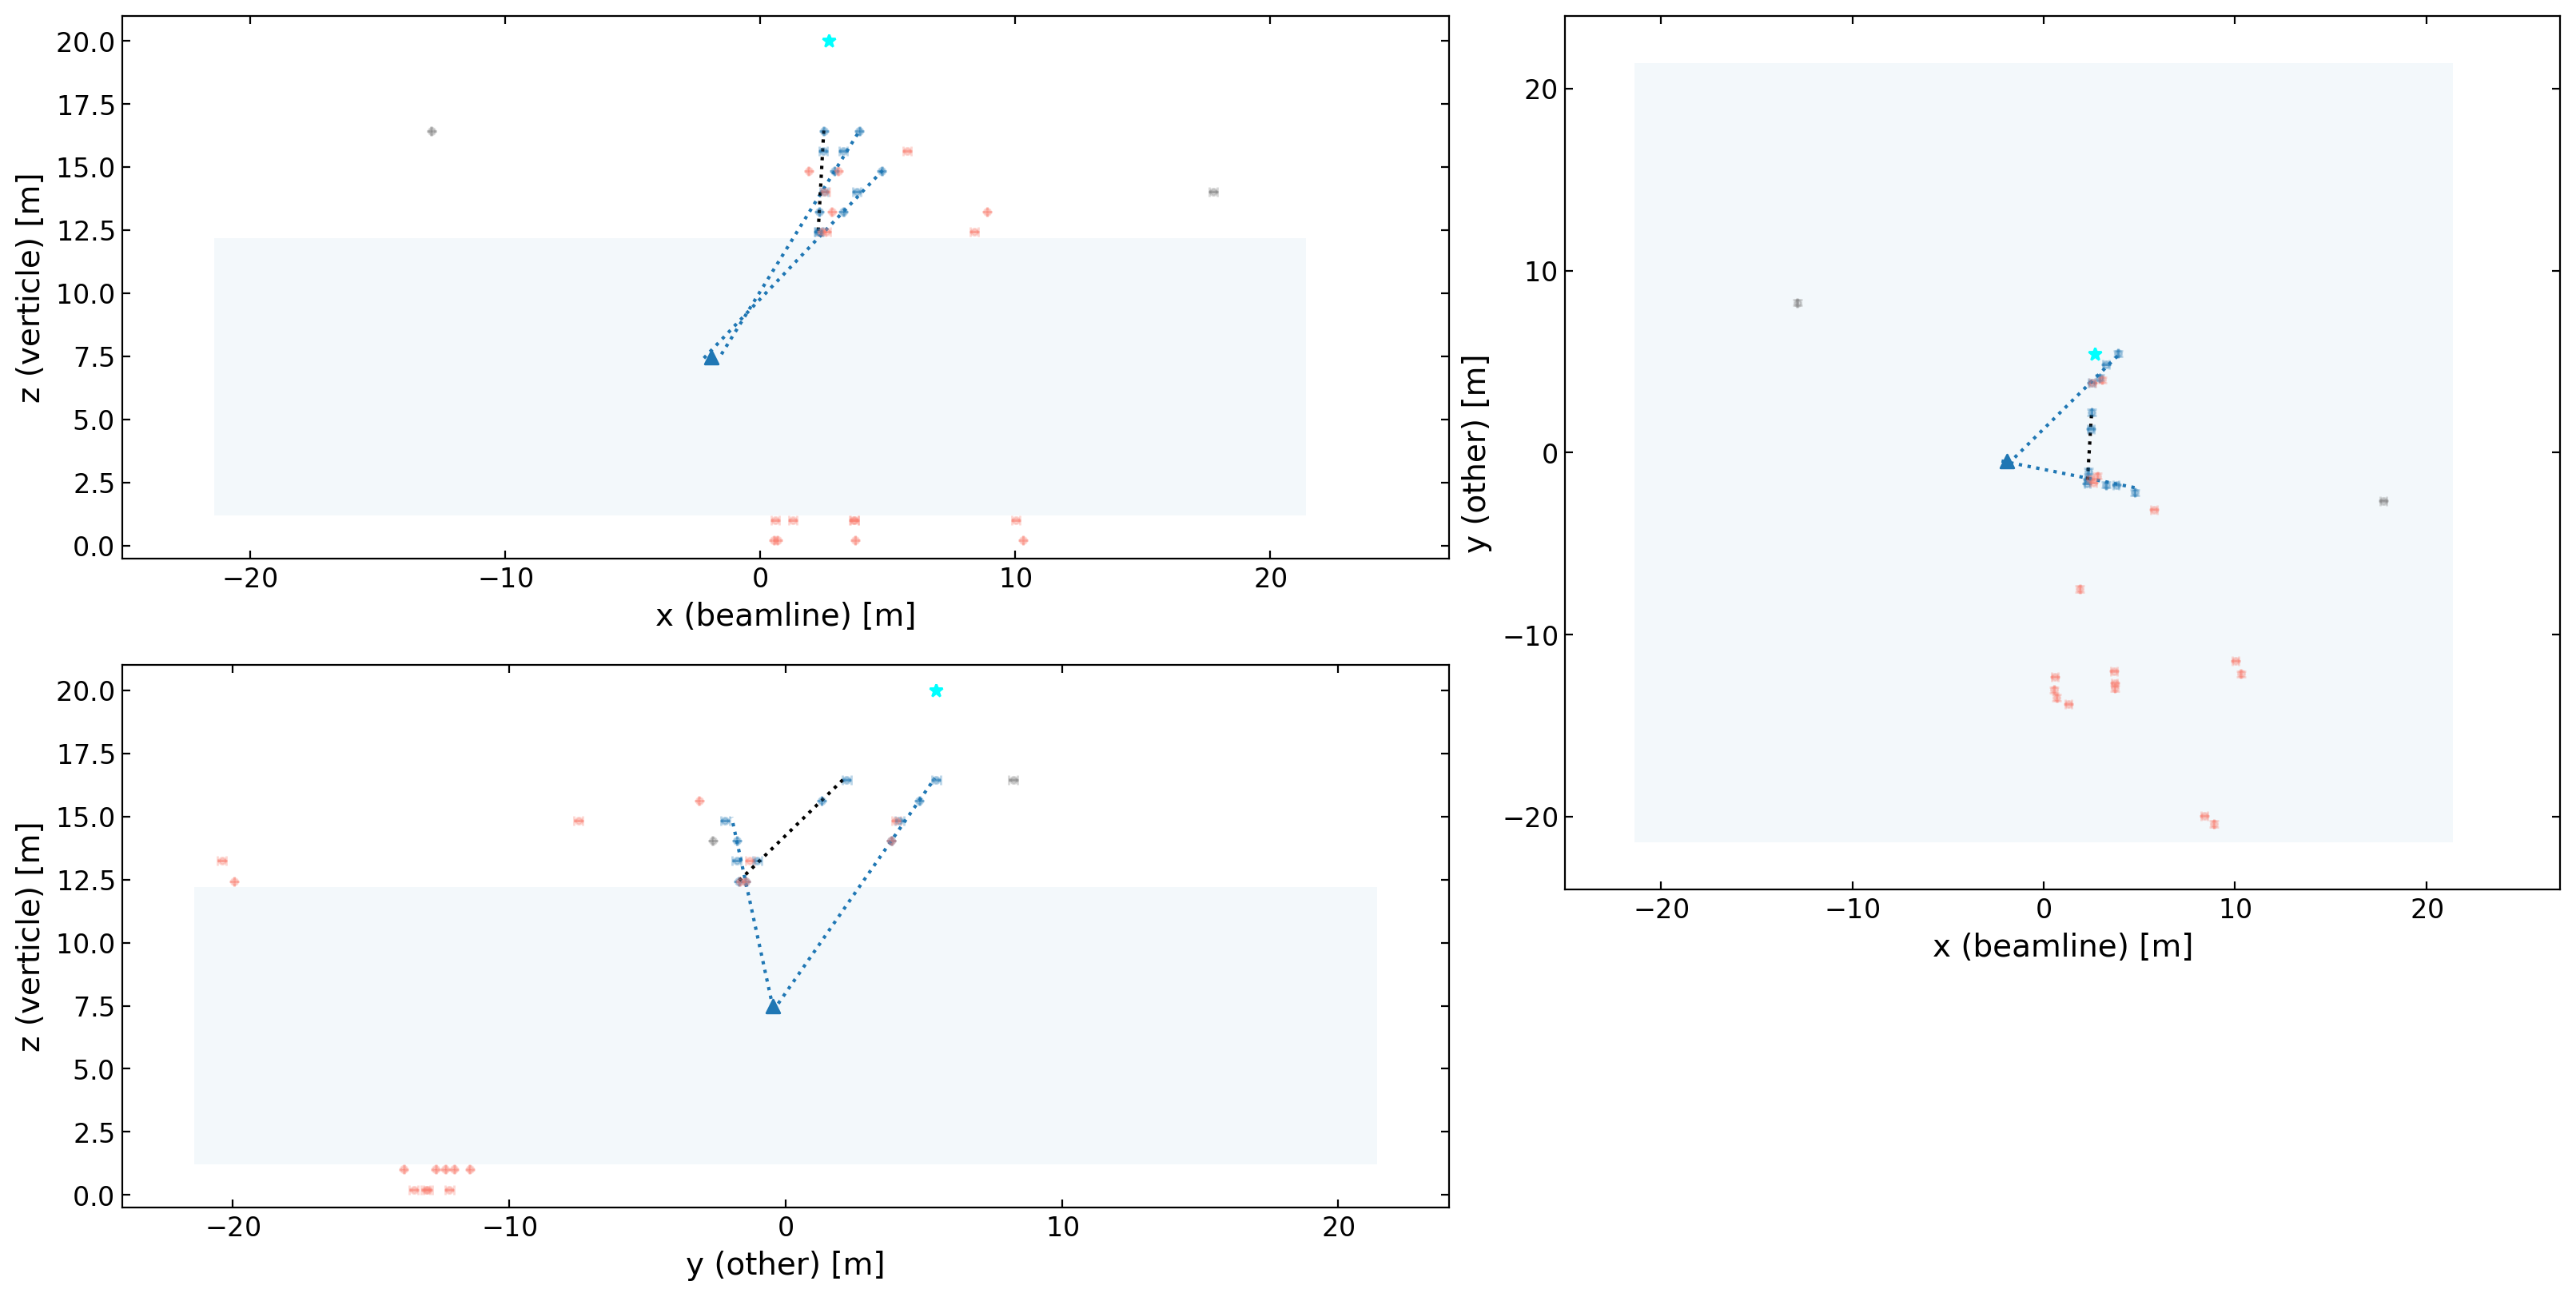

13 796473
3
[-18023.5    14523.787  10489.924   -162.203]
0.3224240786647892
consistent, inconsistent 10 14


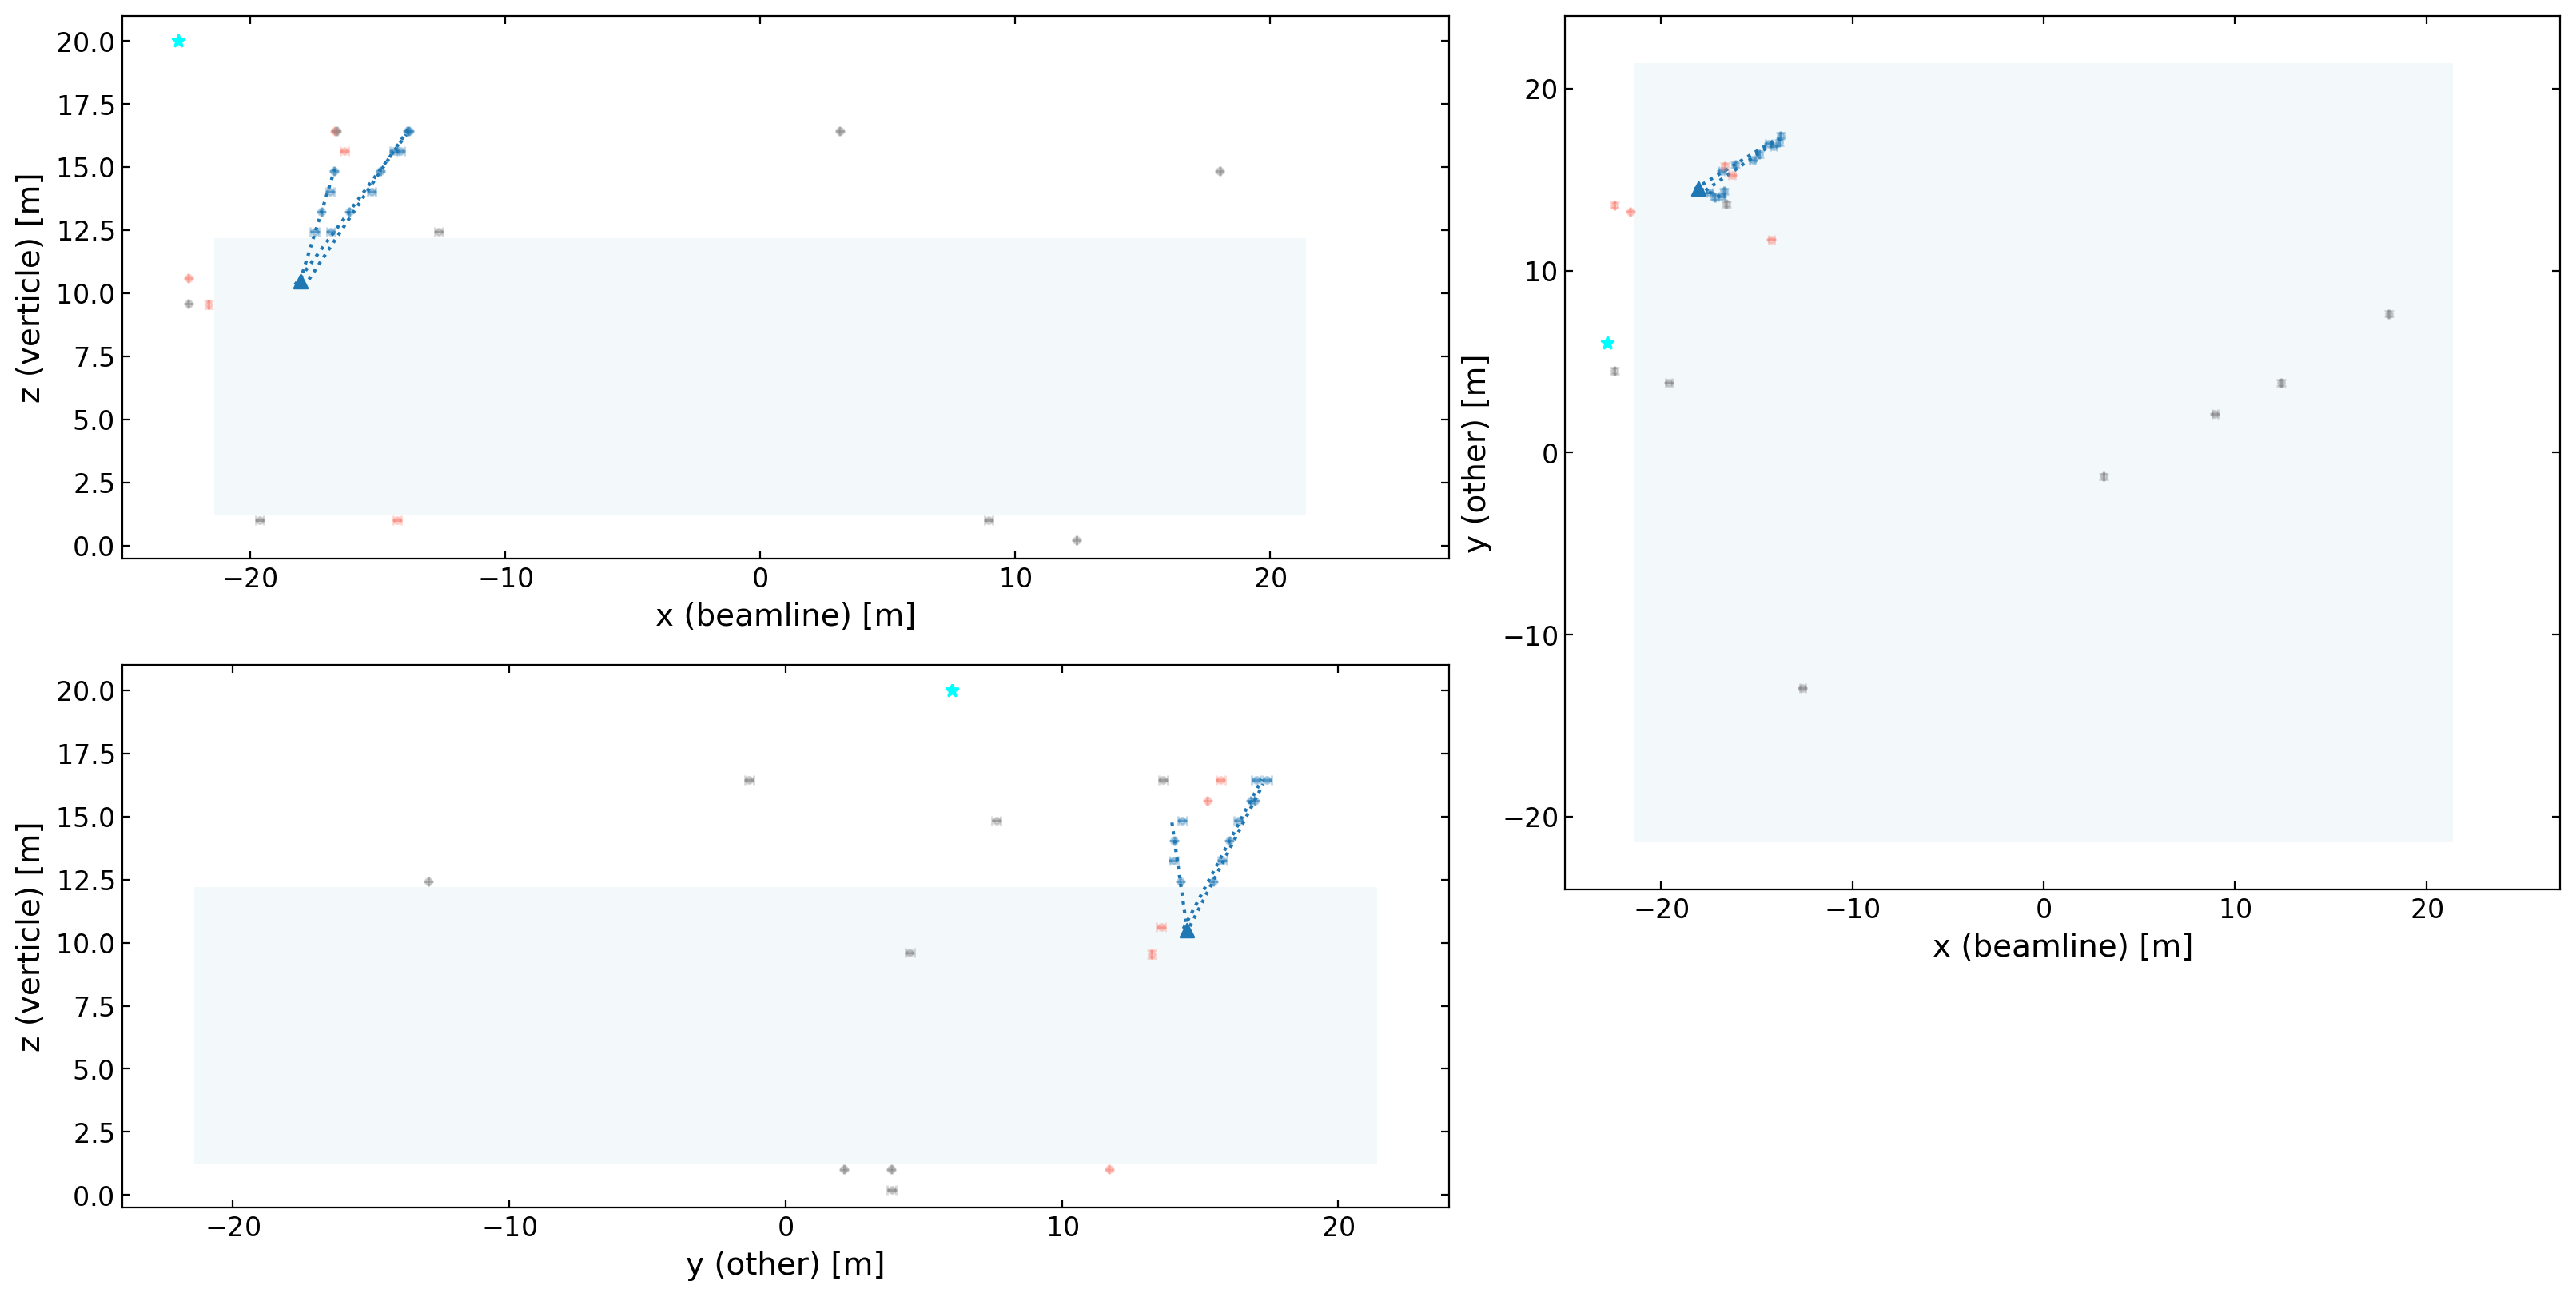

In [25]:
i+=1
# i=100

for i in range(len(plot_inds)):
    
    j=plot_inds[i]
    k = rq_inds[i]
    print(i,j)
    
    x = (res["vertex_ndigi_active_after_comp"])[k]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[k]
    
    print(res["vertex_ntracklet_3+"][rq_inds[i]])
    print(res["vertex_xyzt"][rq_inds[i]])
    print(res["vertex_open_angle"][rq_inds[i]])
    print("consistent, inconsistent", x,y)
    
    rawdata = fbkg.get_entry(j)
    event = datatypes.Event(rawdata, metadata_digi, parse_truth=0)  
    event.plot()


In [591]:
res["event_ndigi_veto"][k], res["event_ndigi_active"][k], res["vertex_ndigi_veto_after_comp"] [k]

(5, 19, 0)

In [626]:
rawdata["Vertex_x0"],rawdata["Vertex_y0"],rawdata["Vertex_z0"],rawdata["Vertex_t0"]

([11495.4482421875],
 [-16230.056640625],
 [8834.1513671875],
 [-397.7176513671875])

In [627]:
for kk in range(len(rawdata["Digi_z"])):
    print(f"""{rawdata["Digi_x"][kk]:>12.3f},{rawdata["Digi_y"][kk]:>12.3f},{rawdata["Digi_z"][kk]:>12.3f}, {rawdata["Digi_t"][kk]:>12.3f},""")

   12919.801,   17887.500,   15635.100,      286.490,
   16642.500,  -19424.865,     211.700,     -190.578,
   -4709.182,   -4637.500,    1011.700,     -212.688,
   12343.821,  -15542.500,   12435.100,     -383.631,
   12392.500,  -15359.266,   13235.100,     -380.353,
   12778.835,  -15157.500,   14035.100,     -380.671,
   12707.500,  -15177.101,   14835.100,     -375.941,
   13039.157,  -14912.500,   15635.100,     -371.327,
   13057.500,  -14777.472,   16435.100,     -368.029,
   15427.172,  -16662.500,   12435.100,     -377.847,
   16207.500,  -16806.830,   13235.100,     -374.098,
   17037.293,  -16907.500,   14035.100,     -369.031,
   17887.500,  -16762.066,   14835.100,     -364.069,
   12807.317,  -15557.500,    1011.700,     -339.878,
   12862.500,  -15292.281,     211.700,     -333.957,
   14904.705,  -15137.500,    1011.700,     -361.744,
   15277.500,  -14945.120,     211.700,     -358.543,
    8070.946,  -14087.500,    1011.700,     -359.395,
    7822.500,  -14076.648,  

In [631]:
r = np.array([11495.4482421875,-16230.056640625,8834.1513671875,-397.7176513671875])
x = [12862.500,  -15292.281,     211.700,     -333.957]
# x = [12807.317,  -15557.500,    1011.700,     -339.878,]

np.linalg.norm(r[:3]-x[:3])/(x[3]-r[3])

137.7083071283825